In [275]:
%matplotlib inline
# Imports Required for random forest
# Pandas is used for data manipulation, h5py for data (conda install h5py)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from os.path import join
from glob import glob
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import h5py
import numpy.ma as ma
import pvlib


In [276]:
idaho_flux_data = pd.read_csv('/Users/mccandle/Documents/CurrentProjects/Reinvestment/FRD_ECFlux_2015-2017.csv')
idaho_met_data = pd.read_csv('/Users/mccandle/Documents/CurrentProjects/Reinvestment/FRD_TallTower_Met_2015-2017.csv')

In [277]:
idaho_flux_no_missing = idaho_flux_data.replace(-9999.0, np.NaN).dropna(axis=0,how='any')
print(idaho_flux_no_missing.shape)
print(idaho_flux_data.shape)
idaho_met_no_missing = idaho_met_data.replace(-999.0, np.NaN).dropna(axis=0,how='any')
print(idaho_met_no_missing.shape)
print(idaho_met_data.shape)

idaho_flux_data['Tau1'] = idaho_flux_data.rolling(window=2)['Tau'].mean()
idaho_flux_data['H1'] = idaho_flux_data.rolling(window=2)['H'].mean()
idaho_flux_data['LE1'] = idaho_flux_data.rolling(window=2)['LE'].mean()

idaho_flux_data['Tau'] = idaho_flux_data['Tau1']
idaho_flux_data['H'] = idaho_flux_data['H1']
idaho_flux_data['LE'] = idaho_flux_data['LE1']

(42637, 11)
(52608, 11)
(295129, 44)
(315648, 44)


In [278]:
for col in idaho_flux_data.columns:
    print(col)
    
    
print(idaho_flux_data['date'][2])
print(idaho_flux_data['time'][2])

date
time
DOY
daytime
Tau
H
LE
co2_flux
h2o_flux
air_density
air_heat_capacity
Tau1
H1
LE1
1/1/2015
1:30


In [279]:
for col in idaho_met_data.columns:
    print(col)

Year
Month
Day
Hour
Minute
2m Wind Speed m/s
2m Wind Gust m/s
2m Wind Dir deg
2m Sigma Theta deg
10m Wind Speed m/s
10m Wind Gust m/s
10m Wind Dir deg
10m Sigma Theta deg
15m Wind Speed m/s
15m Wind Gust m/s
15m Wind Dir deg
15m Sigma Theta deg
45m Wind Speed m/s
45m Wind Gust m/s
45m Wind Dir deg
45m Sigma Theta deg
Top Wind Speed m/s
Top Wind Gust m/s
Top Wind Dir deg
Top Sigma Theta deg
2m Temp C
10m Temp C
15m Temp C
45m Temp C
Top Temp C
2m RH %
Solar Rad w/m^2
BP inches Hg
Rain inches
5cm Water Content
10cm Water Content
20cm Water Content
50cm Water Content
100cm Water Content
5cm Soil Temp C
10cm Soil Temp C
20cm Soil Temp C
50cm Soil Temp C
100cm Soil Temp C


In [280]:
idaho_met_no_missing['Year'].astype(int)
idaho_met_no_missing['Month'].astype(int)
idaho_met_no_missing['Day'].astype(int)
idaho_met_no_missing['Hour'].astype(int)
idaho_met_no_missing['Minute'].astype(int)

year = idaho_met_no_missing.iloc[1:,0]
month = idaho_met_no_missing.iloc[1:,1]
day = idaho_met_no_missing.iloc[1:,2]
hour = idaho_met_no_missing.iloc[1:,3]
minute = idaho_met_no_missing.iloc[1:,4]

#idaho_met_no_missing['date'] = pd.to_datetime((idaho_met_no_missing.Year*10000+idaho_met_no_missing.Month*100+idaho_met_no_missing.Day).apply(str),format='%Y%M%d')
#print(idaho_met_no_missing['date'][1:3])

idaho_met_no_missing['DateTime'] = idaho_met_no_missing[['Year', 'Month', 'Day', 'Hour','Minute']].apply(lambda s : datetime.datetime(*s),axis = 1)
print(idaho_met_no_missing['DateTime'][1:3])

idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
#idaho_flux_no_missing['DateTime3'] = idaho_flux_no_missing.time.apply(lambda y: pd.to_datetime(y).strftime('%h:m'))
#idaho_flux_no_missing['DateTime2'] = pd.to_datetime(idaho_flux_no_missing.DateTime) 
#print(idaho_flux_no_missing['DateTime3'][-5:-1])

idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing['DateTime'] + ' ' + idaho_flux_no_missing['time']
#print(idaho_flux_no_missing['Test'][-5:-1])
#idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing.Test.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M:%S'))
idaho_flux_no_missing['DateTime'] = pd.to_datetime(idaho_flux_no_missing['DateTime'])
print(idaho_flux_no_missing['DateTime'][1:3])

result = pd.merge(idaho_met_no_missing,idaho_flux_no_missing,on='DateTime')
print(result)

1   2015-01-01 00:10:00
2   2015-01-01 00:15:00
Name: DateTime, dtype: datetime64[ns]
1   2015-01-01 01:00:00
2   2015-01-01 01:30:00
Name: DateTime, dtype: datetime64[ns]
       Year  Month  Day  Hour  Minute  2m Wind Speed m/s  2m Wind Gust m/s  \
0      2015      1    1     0      30                0.9               1.4   
1      2015      1    1     1       0                1.3               1.6   
2      2015      1    1     1      30                1.4               1.6   
3      2015      1    1     2       0                0.7               1.0   
4      2015      1    1     2      30                1.3               1.4   
...     ...    ...  ...   ...     ...                ...               ...   
40683  2017     12   31    18       0                0.7               0.7   
40684  2017     12   31    18      30                0.8               0.8   
40685  2017     12   31    19       0                0.6               0.9   
40686  2017     12   31    19      30           

                     apparent_zenith     zenith  apparent_elevation  \
DateTime                                                              
2015-01-01 00:30:00        83.931703  84.072456            6.068297   
2015-01-01 01:00:00        79.928223  80.018156           10.071777   
2015-01-01 01:30:00        76.290113  76.357078           13.709887   
2015-01-01 02:00:00        73.099478  73.153799           16.900522   
2015-01-01 02:30:00        70.428560  70.475234           19.571440   

                     elevation     azimuth  equation_of_time  
DateTime                                                      
2015-01-01 00:30:00   5.927544  129.463132         -3.195131  
2015-01-01 01:00:00   9.981844  135.100482         -3.204993  
2015-01-01 01:30:00  13.642922  141.075655         -3.214852  
2015-01-01 02:00:00  16.846201  147.410058         -3.224709  
2015-01-01 02:30:00  19.524766  154.103466         -3.234564  
(40688,)


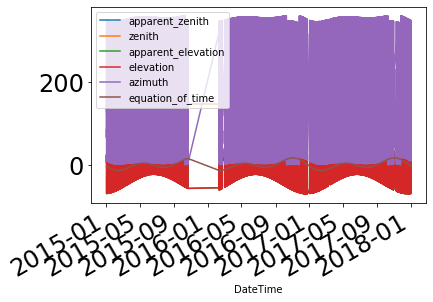

In [281]:
import pvlib
lat = 43.06
lon = 116.74
solpos = pvlib.solarposition.get_solarposition(result['DateTime'],lat,lon)
print(solpos.head())
solpos.plot()
print(solpos.zenith.shape)
result['solar_zenith_angle'] = np.array(solpos['zenith'])

In [282]:
# Unit Conversion from C to K
def celsius_to_kelvin(temperature_c):
    return temperature_c + 273.15

# Unit Conversion from wind speed to wind components
def wind_components(wind_speed_m_s, wind_direction_degrees):
    math_dir = 270 - wind_direction_degrees
    math_dir[math_dir < 0] = 360 + math_dir[math_dir < 0]
    u = wind_speed_m_s * np.cos(np.radians(math_dir))
    v = wind_speed_m_s * np.sin(np.radians(math_dir))
    return u, v

# Unit Conversion from temperature and pressure to potential temperature
def inHg_to_hpa(pressure_inHg):
    """
    Convert pressure in inches of mercury (inHg) to pressure in hectopascals (hpa)

    Args:
        pressure_inHg: The air pressure in units inHg

    Returns:
        The air pressure in units hpa
    """
    return pressure_inHg * 33.86

def potential_temperature(temperature_k, pressure_hpa, pressure_reference_hpa=1000.0):
    """
    Convert temperature to potential temperature based on the available pressure. Potential temperature is at a
    reference pressure of 1000 mb.

    Args:
        temperature_k: The air temperature in units K
        pressure_hpa: The atmospheric pressure in units hPa
        pressure_reference_hpa: The reference atmospheric pressure for the potential temperature in hPa;
            default 1000 hPa

    Returns:
        The potential temperature in units K
    """
    return temperature_k * (pressure_reference_hpa / pressure_hpa) ** (2.0 / 7.0)

def friction_velocity(tau, density):
    """
    Compute friction velocity from tau and air density.

    Args:
        tau: The surface stress
        pressure_hpa: The atmospheric density in kg/m^3

    Returns:
        The friction velocity
    """
    u2 = np.array(result['Tau']) / np.array(result['air_density'])
    fv = np.sqrt(tau/density)
    return fv

def temperature_scale(sensible_heat_flux_W_m2, air_density_kg_m3, friction_velocity_m_s,
                      min_friction_velocity=0.001, min_sensible_heat_flux_mag=0.001):
    """
    Caclulate the temperature turbulence scale value theta* from the sensible heat flux.

    Args:
        sensible_heat_flux_W_m2: The sensible heat flux in units W m-2.
        air_density_kg_m3: The density of air in units kg m-3.
        friction_velocity_m_s: The friction velocity in units m s-1.

    Returns:
        The temperature turbulence scale value in units K.
    """
    heat_flux_sign = np.where(sensible_heat_flux_W_m2 >= 0, 1, -1)
    heat_flux_adjusted = heat_flux_sign * np.maximum(np.abs(sensible_heat_flux_W_m2), min_sensible_heat_flux_mag)
    return -heat_flux_adjusted / (air_density_kg_m3 * 287.0 * 7.0 / 2.0 *
                                  np.maximum(friction_velocity_m_s, min_friction_velocity))

def virtual_temperature(temperature_k, mixing_ratio_g_kg):
    """
    Convert temperature and mixing ratio to virtual temperature.

    Args:
        temperature_k: The temperature or potential temperature in units K.
        mixing_ratio_kg_kg: The mixing ratio in units kg kg-1.

    Returns:
        The virtual temperature in units K.
    """
    return temperature_k * (1 + 0.61 * mixing_ratio_g_kg / 1000.0)

def moisture_scale(latent_heat_flux_W_m2, air_density_kg_m3, friction_velocity_m_s,
                   min_friction_velocity=0.001, min_latent_heat_flux_mag=0.001):
    """
    Calculate the turblulent moisture scale factor from the latent heat flux.

    Args:
        latent_heat_flux_W_m2: Latent heat flux in units W m-2
        air_density_kg_m3: Density of air in units kg m-3
        friction_velocity_m_s: The friction velocity (u*) in units m s-1

    Returns:
        The turbulent moisture scale factor in g kg-1
    """
    latent_heat_of_vaporization_J_kg = 2264705.0  # J kg-1
    heat_flux_sign = np.where(latent_heat_flux_W_m2 >= 0, 1, -1)
    heat_flux_adjusted = heat_flux_sign * np.maximum(np.abs(latent_heat_flux_W_m2), min_latent_heat_flux_mag)
    g_per_kg = 1000.0
    return heat_flux_adjusted / (latent_heat_of_vaporization_J_kg * air_density_kg_m3
                                 * np.maximum(friction_velocity_m_s, min_friction_velocity)) * g_per_kg


def obukhov_length(potential_temperature_k, temperature_scale_k, friction_velocity_m_s, von_karman_constant=0.4,
                   min_friction_velocity=0.01, min_temperature_scale=0.01):
    """
    Caclulates the Obukhov length, a measure of stability based on the friction velocity and temperature scale.

    Args:
        potential_temperature_k: The potential temperature in units K
        temperature_scale_k: The turbulent temperature scale (theta*) in units K
        friction_velocity_m_s: The friction velocity (u*) in units m s-1
        von_karman_constant: The von Karman constant (default=0.4)

    Returns:
        The Obukhov length in units m.
    """
    g = 9.81 # m s-2
    temperature_scale_sign = np.where(temperature_scale_k >= 0, 1, -1)
    adjusted_temperature_scale = temperature_scale_sign * np.maximum(np.abs(temperature_scale_k), min_temperature_scale)
    return np.maximum(friction_velocity_m_s, min_friction_velocity) ** 2 * potential_temperature_k / (
            von_karman_constant * g * adjusted_temperature_scale)

def mixing_ratio(temp_2m_C, relative_humidity, pressure_hpa):
    """
    Calculate the mixing ratio.

    Args:
        temp_2m_C: 2-meter temperature in units of Celcius
        relative humidity: as a percentage
        pressure_hpa: atmospheric pressure in hPa

    Returns:
        The mixing ratio 
    """
    saturation_vapor_pressure= (0.6108 * np.exp(17.27 * temp_2m_C / (temp_2m_C + 237.3)))*10
    vapor_pressure = relative_humidity / 100 * saturation_vapor_pressure 
    return 621.97 * vapor_pressure / (pressure_hpa-vapor_pressure), vapor_pressure, saturation_vapor_pressure

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure
    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA
    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

def bulk_richardson_number(potential_temperature_k, height,
                           mixing_ratio_g_kg, virtual_potential_skin_temperature_k, wind_speed_m_s,
                           minimum_wind_speed=1):
    """
    Calculate the bulk Richardson number, a measure of stability.

    Args:
        potential_temperature_k: The potential or virtual potential temperature in K
        height: The height at which the potential temperature calculation is performed in m.
        mixing_ratio_kg_kg: The mixing ratio at the same height as the potential temperature in units kg kg-1.
        virtual_potential_skin_temperature_k: The virtual potential temperature at the surface
        wind_speed_m_s: The wind speed in m s-1

    Returns:

    """
    g = 9.81  # m s-2
    virtual_potential_temperature_k = virtual_temperature(potential_temperature_k, mixing_ratio_g_kg)
    return g / potential_temperature_k * height * (virtual_potential_temperature_k
                                                   - virtual_potential_skin_temperature_k) / \
           np.maximum(wind_speed_m_s ** 2, minimum_wind_speed ** 2)

# Need to convert Idaho data from celsius to kelvin
result['2m Temp K'] = celsius_to_kelvin(result['2m Temp C'])
result['10m Temp K'] = celsius_to_kelvin(result['10m Temp C'])
result['15m Temp K'] = celsius_to_kelvin(result['15m Temp C'])
result['45m Temp K'] = celsius_to_kelvin(result['45m Temp C'])

# Need to convert Idaho data to wind components from speed and direction
result['2m U-Wind m/s'],result['2m V-Wind m/s'] = wind_components(result['2m Wind Speed m/s'],result['2m Wind Dir deg'])
result['10m U-Wind m/s'],result['10m V-Wind m/s'] = wind_components(result['10m Wind Speed m/s'],result['10m Wind Dir deg'])
result['15m U-Wind m/s'],result['15m V-Wind m/s'] = wind_components(result['15m Wind Speed m/s'],result['15m Wind Dir deg'])
result['45m U-Wind m/s'],result['45m V-Wind m/s'] = wind_components(result['45m Wind Speed m/s'],result['45m Wind Dir deg'])

# Need to convert temperatures in inches of mercury to hectopascals
result['Barometric Pressure hpa'] = inHg_to_hpa(result['BP inches Hg'])  

# Need to convert from Kelvin to Potential Temperature
result['2m potential temperature k'] = potential_temperature(result['2m Temp K'],result['Barometric Pressure hpa'])    
result['10m potential temperature k'] = potential_temperature(result['10m Temp K'],result['Barometric Pressure hpa'])
result['15m potential temperature k'] = potential_temperature(result['15m Temp K'],result['Barometric Pressure hpa'])
result['45m potential temperature k'] = potential_temperature(result['45m Temp K'],result['Barometric Pressure hpa'])

# Compute the friction velocity
result['friction velocity'] = friction_velocity(result['Tau'],result['air_density'])

# Compute the temperature scale
result['temperature scale'] = temperature_scale(result['H'],result['air_density'],result['friction velocity'])

# Compute the moisture scale
result['moisture scale'] = moisture_scale(result['LE'],result['air_density'],result['friction velocity'])

# Compute the Monin Obukhov Length
result['obukhov length'] = obukhov_length(result['2m potential temperature k'], result['temperature scale'], 
                                          result['friction velocity'], von_karman_constant=0.4)

# Compute the mixing ratio
result['2m mixing ratio g_kg'], vapor_pressure, saturation_vapor_pressure = mixing_ratio(result['2m Temp C'], result['2m RH %'], result['Barometric Pressure hpa'])

# Compute the virtual potential temperature
result['2m virtual potential temperature'] = virtual_temperature(result['2m potential temperature k'], 
                                                                 result['2m mixing ratio g_kg'])
# Compute the Bulk Richardson Number
result['bulk richardson number'] = bulk_richardson_number(result['2m potential temperature k'], 2, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['2m virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])


In [283]:
# Try computing Bulk Richardson Number between 10M and 2M
# Compute the Bulk Richardson Number
result['10m bulk richardson number'] = bulk_richardson_number(result['10m potential temperature k'], 10, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['2m virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])
# Try computing Bulk Richardson Number between 2M and 5cm soil temperature
# Compute the Bulk Richardson Number
# Compute the virtual potential temperature

result['5cm Soil Temp K'] = celsius_to_kelvin(result['5cm Soil Temp C'])
result['5cm potential temperature k'] = potential_temperature(result['5cm Soil Temp K'],result['Barometric Pressure hpa'])
result['5cm virtual potential temperature'] = virtual_temperature(result['5cm potential temperature k'], 
                                                                 result['2m mixing ratio g_kg'])
result['Soil bulk richardson number'] = bulk_richardson_number(result['2m potential temperature k'], 10, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['5cm virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])

result["roughness length surface m"] = np.minimum(9, np.maximum(0.001, 10 * np.exp(-0.4 * np.maximum(result["10m Wind Speed m/s"], 1) / result["friction velocity"])))



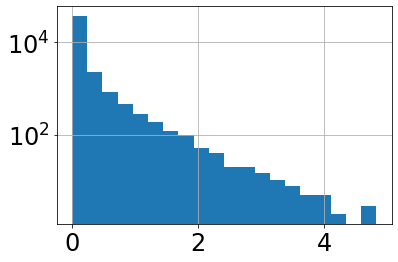

In [284]:
result["roughness length surface m"].hist(bins=20)
plt.gca().set_yscale("log")

326.9966420337985
255.85241728460775
296.87365394554695
326.9966420337985
255.85241728460775
296.87365394554695
40688
40688
(40688,)


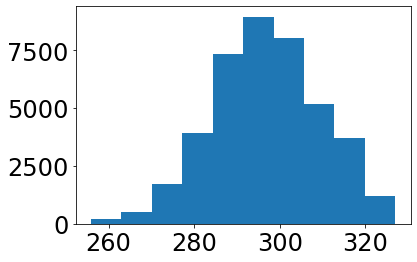

In [285]:
t = np.array(result['2m virtual potential temperature'])
print(np.max(t))
print(np.min(t))
print(np.mean(t))
result_no_missing = np.array(result['2m virtual potential temperature'].replace(-999.0, np.nan).dropna(axis=0,how='any'))
print(np.max(result_no_missing))
print(np.min(result_no_missing))
print(np.mean(result_no_missing))
plt.hist(result_no_missing)
print(np.size(t))
print(np.size(result_no_missing))
print(result['2m Wind Speed m/s'].shape)

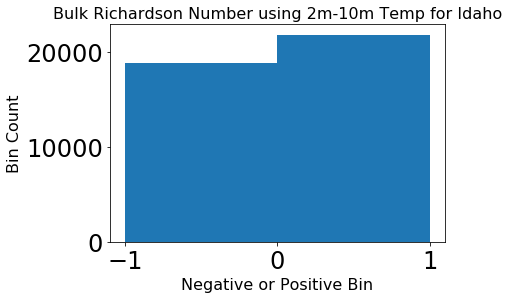

In [286]:
result['10m bulk richardson number'].drop(result['10m bulk richardson number'].idxmax())
result["BRN_sign"] = np.sign(result['10m bulk richardson number'])
plt.title('Bulk Richardson Number using 2m-10m Temp for Idaho', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(result["BRN_sign"],bins=2)
plt.savefig('BRN_2-10m_idaho.png')

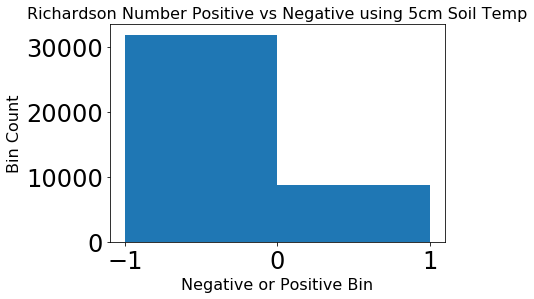

In [287]:
result['Soil bulk richardson number'].drop(result['Soil bulk richardson number'].idxmin())
result["BRN_sign_5cm"] = np.sign(result['Soil bulk richardson number'])
plt.title('Richardson Number Positive vs Negative using 5cm Soil Temp', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(result["BRN_sign_5cm"],bins=2)
plt.savefig('BRN_5cmSoil-10m_idaho.png')

In [288]:
# Subset into different years for training and testing
# Set training years as 2015, 2016 and predict 2017
#resultTest = result[(result['Year'] == 2017)]
#resultTrain = result[(result['Year'] != 2017)]
# Set training years as 2015, 2017 and predict 2016
#resultTest = result[(result['Year'] == 2016)]
#resultTrain = result[(result['Year'] != 2016)]
# Set training years as 2016, 2017 and predict 2015
resultTest = result[(result['Year'] == 2015)]
resultTrain = result[(result['Year'] != 2015)]
print(resultTrain.shape)
print(resultTest.shape)

(28918, 89)
(11770, 89)


In [289]:
# Test adding in Bulk Richardson Number as a Predictor
dataset = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
dataset['LowLevel Potential Temp K'] = resultTrain['10m potential temperature k']
dataset['MidLevel Potential Temp K'] = resultTrain['15m potential temperature k']
dataset['TopLevel Potential Temp K'] = resultTrain['45m potential temperature k']
dataset['LowLevel Wind Speed m/s'] = resultTrain['10m Wind Speed m/s']
dataset['LowLevel Wind Dir deg'] = resultTrain['10m Wind Dir deg']
dataset['MidLevel Wind Speed m/s'] = resultTrain['15m Wind Speed m/s']
dataset['MidLevel Wind Dir deg'] = resultTrain['15m Wind Dir deg']
dataset['TopLevel Wind Speed m/s'] = resultTrain['45m Wind Speed m/s']
dataset['TopLevel Wind Dir deg'] = resultTrain['45m Wind Dir deg']
dataset['2m RH %'] = resultTrain['2m RH %']
dataset['0m GHI w/m^2'] = resultTrain['Solar Rad w/m^2']
dataset['2m Pressure hPa'] = resultTrain['Barometric Pressure hpa']
dataset['0m Solar Zenith Angle deg'] = resultTrain['solar_zenith_angle']
dataset['TopLevel Soil Water Content m3/m3'] = resultTrain['5cm Water Content']
dataset['TopLevel Soil Temp K'] = resultTrain['5cm Soil Temp C']
dataset['10m Bulk Richardson'] = resultTrain['10m bulk richardson number']
# These are potentially needed for other computations, but not as predictors
dataset['10m Temp K'] = resultTrain['10m Temp K']
dataset['2m Temp K'] = resultTrain['2m Temp K']
dataset['10m U-Wind m/s'] = resultTrain['10m U-Wind m/s']
dataset['10m V-Wind m/s'] = resultTrain['10m V-Wind m/s']

datasetTest = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetTest['LowLevel Potential Temp K'] = resultTest['10m potential temperature k']
datasetTest['MidLevel Potential Temp K'] = resultTest['15m potential temperature k']
datasetTest['TopLevel Potential Temp K'] = resultTest['45m potential temperature k']
datasetTest['LowLevel Wind Speed m/s'] = resultTest['10m Wind Speed m/s']
datasetTest['LowLevel Wind Dir deg'] = resultTest['10m Wind Dir deg']
datasetTest['MidLevel Wind Speed m/s'] = resultTest['15m Wind Speed m/s']
datasetTest['MidLevel Wind Dir deg'] = resultTest['15m Wind Dir deg']
datasetTest['TopLevel Wind Speed m/s'] = resultTest['45m Wind Speed m/s']
datasetTest['TopLevel Wind Dir deg'] = resultTest['45m Wind Dir deg']
datasetTest['2m RH %'] = resultTest['2m RH %']
datasetTest['0m GHI w/m^2'] = resultTest['Solar Rad w/m^2']
datasetTest['2m Pressure hPa'] = resultTest['Barometric Pressure hpa']
datasetTest['0m Solar Zenith Angle deg'] = resultTest['solar_zenith_angle']
datasetTest['TopLevel Soil Water Content m3/m3'] = resultTest['5cm Water Content']
datasetTest['TopLevel Soil Temp K'] = resultTest['5cm Soil Temp C']
datasetTest['10m Bulk Richardson'] = resultTest['10m bulk richardson number']
# These are potentially needed for other computations, but not as predictors
datasetTest['10m Temp K'] = resultTest['10m Temp K']
datasetTest['2m Temp K'] = resultTest['2m Temp K']
datasetTest['10m U-Wind m/s'] = resultTest['10m U-Wind m/s']
datasetTest['10m V-Wind m/s'] = resultTest['10m V-Wind m/s']

featuresM = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresB = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresF = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']

MoistureScaleTrain = resultTrain['moisture scale']
TemperatureScaleTrain = resultTrain['temperature scale']
FrictionVelocityTrain = resultTrain['friction velocity']

MoistureScaleTest = resultTest['moisture scale']
TemperatureScaleTest = resultTest['temperature scale']
FrictionVelocityTest = resultTest['friction velocity']

# Put in nomenclature so that either yearly or random split can be used
train_featuresM = dataset
train_labelsM = MoistureScaleTrain
train_featuresF = dataset
train_labelsF = FrictionVelocityTrain
train_featuresT = dataset
train_labelsT = TemperatureScaleTrain

test_featuresM = datasetTest
test_labelsM = MoistureScaleTest
test_featuresF = datasetTest
test_labelsF = FrictionVelocityTest
test_featuresT = datasetTest
test_labelsT = TemperatureScaleTest

#train_featuresM = train_featuresM.iloc[:,0:14]




######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
rfM = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfT = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfF = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
# Train the model on training data
rfM.fit(train_featuresM.iloc[:,0:16], train_labelsM);
rfF.fit(train_featuresF.iloc[:,0:16], train_labelsF);
rfT.fit(train_featuresT.iloc[:,0:16], train_labelsT);

# Use the forest's predict method on the test data
predictionsM = rfM.predict(test_featuresM.iloc[:,0:16])
predictionsT = rfT.predict(test_featuresT.iloc[:,0:16])
predictionsF = rfF.predict(test_featuresF.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM = abs(predictionsM - test_labelsM)
errorsT = abs(predictionsT - test_labelsT)
errorsF = abs(predictionsF - test_labelsF)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF), 4))
print('Moisture Scale Mean: ',np.mean(MoistureScaleTest))
print('Moisture Scale Standard Deviation: ',np.std(MoistureScaleTest))
print('Temperature Scale Mean: ',np.mean(TemperatureScaleTest))
print('Temperature Scale Standard Deviation: ',np.std(TemperatureScaleTest))
print('Friction Velocity Mean: ',np.mean(FrictionVelocityTest))
print('Friction Velocity Standard Deviation: ',np.std(FrictionVelocityTest))

# Feature selection
importancesM = list(rfM.feature_importances_)
feature_listM = featuresM
feature_importancesM = [(featuresM,round(importancesM,2)) for featuresM, importancesM in zip(feature_listM,importancesM)]
feature_importancesM = sorted(feature_importancesM,key = lambda x: x[1],reverse=True)
print("Features importances for predicting moisture scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesM];

# Feature selection
importancesT = list(rfT.feature_importances_)
feature_listT = featuresB
feature_importancesT = [(featuresT,round(importancesT,2)) for featuresT, importancesT in zip(feature_listT,importancesT)]
feature_importancesT = sorted(feature_importancesT,key = lambda x: x[1],reverse=True)
print("Features importances for predicting temperature scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesT];

# Feature selection
importancesF = list(rfF.feature_importances_)
featuresF = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
feature_listF = featuresF
feature_importancesF = [(featuresF,round(importancesF,2)) for featuresF, importancesF in zip(feature_listF,importancesF)]
feature_importancesF = sorted(feature_importancesF,key = lambda x: x[1],reverse=True)
print("Features importances for predicting friction velocity")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesF];

Mean Absolute Error for predicting Moisture Scale: 0.0232
Mean Absolute Error for predicting Temperature Scale: 0.0788
Mean Absolute Error for predicting Friction Velocity: 0.0473
Moisture Scale Mean:  0.024799827182640313
Moisture Scale Standard Deviation:  0.06228143833030081
Temperature Scale Mean:  -0.16748345962055036
Temperature Scale Standard Deviation:  0.39779457382886946
Friction Velocity Mean:  0.2926149115470208
Friction Velocity Standard Deviation:  0.21440500863554918
Features importances for predicting moisture scale
Variable:0m GHI w/m^2         Importance: 0.4
Variable:10m bulk richardson number Importance: 0.2
Variable:5cm Water Content    Importance: 0.19
Variable:5cm Soil Temp C      Importance: 0.1
Variable:2m RH %              Importance: 0.03
Variable:LowLevel Potential Temp K Importance: 0.02
Variable:TopLevel Wind Speed m/s Importance: 0.02
Variable:MidLevel Potential Temp K Importance: 0.01
Variable:TopLevel Potential Temp K Importance: 0.01
Variable:LowLevel 

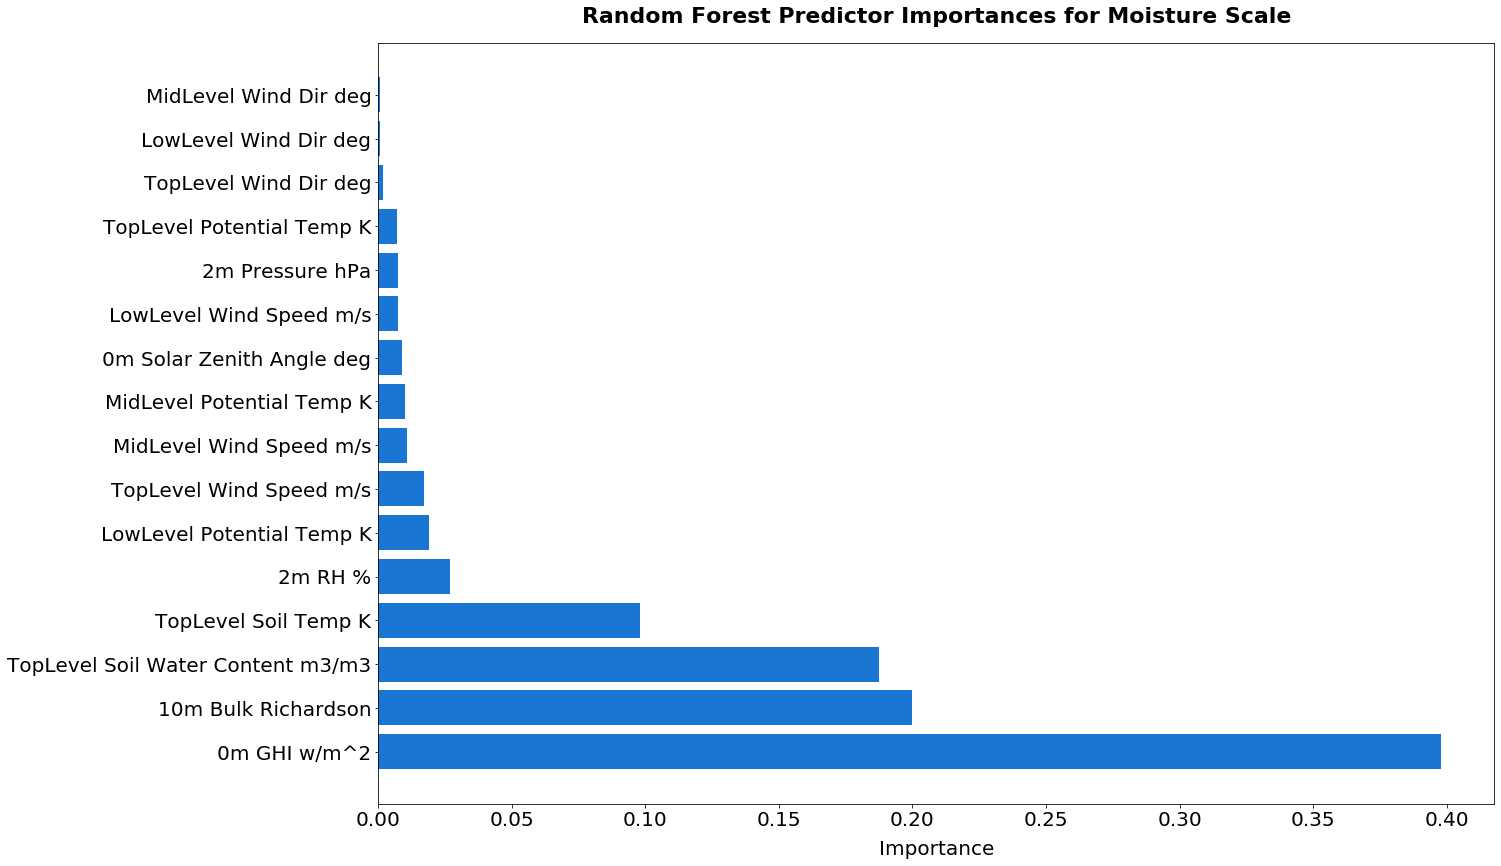

In [290]:
dset = pd.DataFrame()
train_featuresM = train_featuresM.iloc[:,0:16]
dset['attr'] = train_featuresM.columns
dset['importance'] = rfM.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Moisture Scale', fontsize=22, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-MoistureScale-Idaho.png')
plt.show()

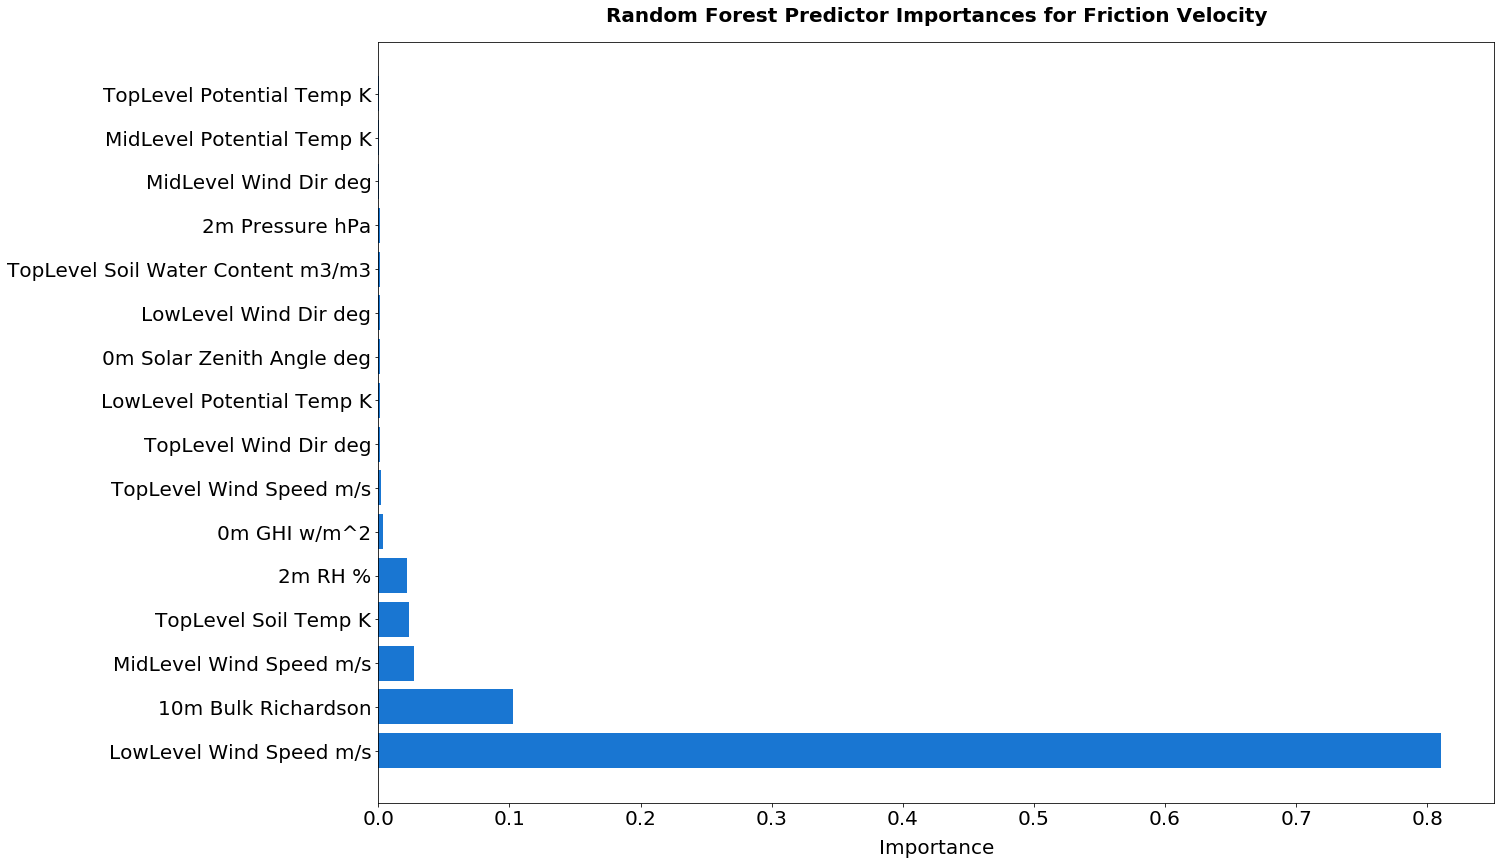

In [291]:
dset = pd.DataFrame()
train_featuresF = train_featuresF.iloc[:,0:16]
dset['attr'] = train_featuresF.columns
dset['importance'] = rfF.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Friction Velocity', fontsize=20, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-FrictionVelocity-Idaho.png')
plt.show()

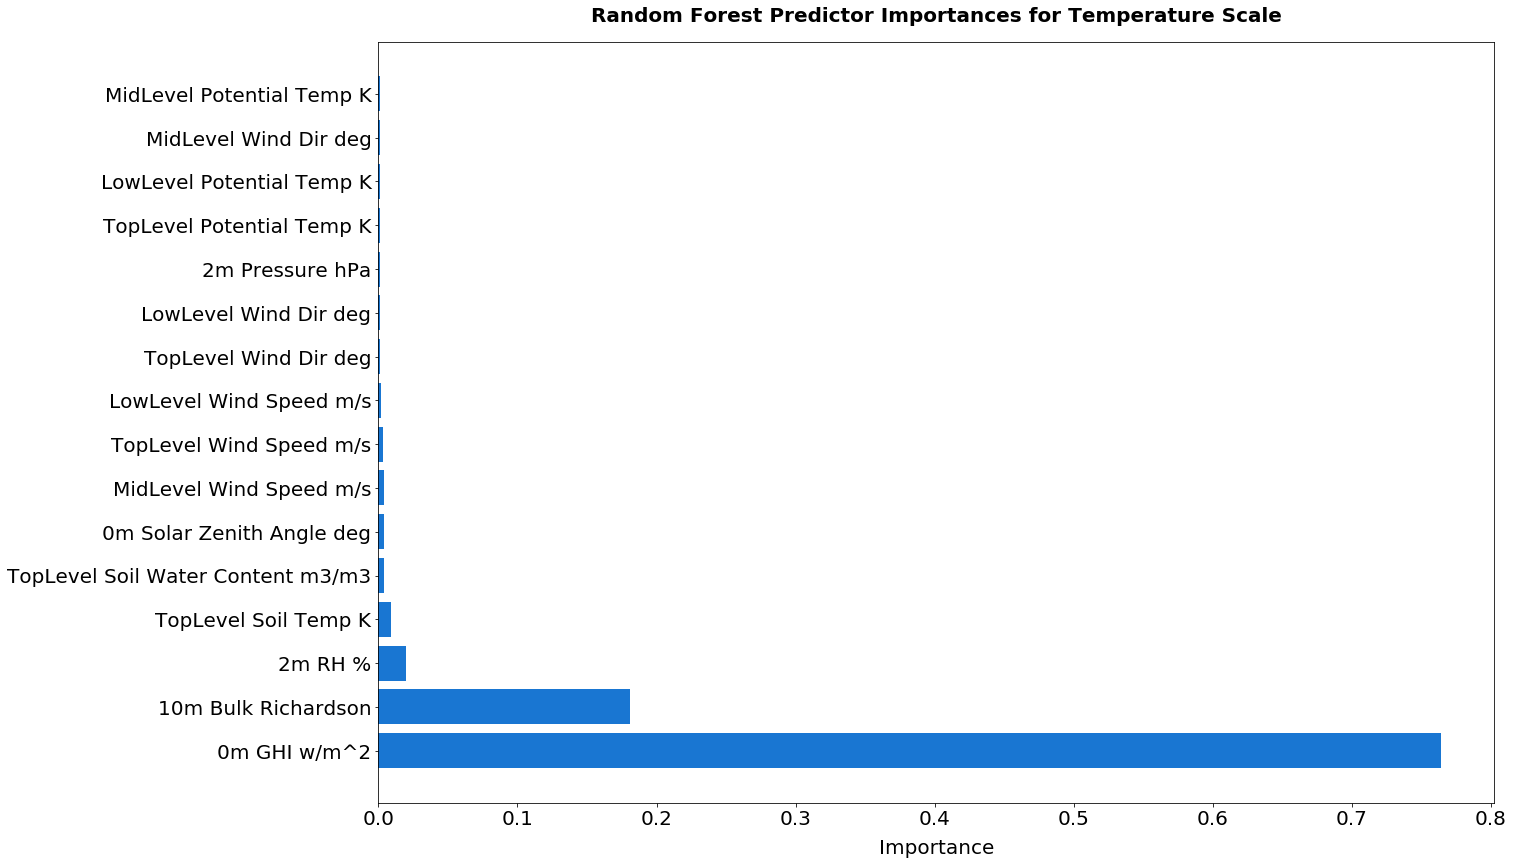

In [292]:
dset = pd.DataFrame()
train_featuresT = train_featuresT.iloc[:,0:16]
dset['attr'] = train_featuresT.columns
dset['importance'] = rfT.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Temperature Scale', fontsize=20, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-TemperatureScale-Idaho.png')
plt.show()

In [366]:
## Update this to train ANN rather than RF for different regimes
import tensorflow as tf
from tensorflow import keras
def build_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    #batch_size=512
    batch_size=32
    model.compile(loss='mae',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

# Train ANN on negative BRN predictions
EPOCHS = 10

######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
ANN_M = build_model(np.asarray(train_featuresM.iloc[:,0:16]))
ANN_T = build_model(np.asarray(train_featuresT.iloc[:,0:16]))
ANN_F = build_model(np.asarray(train_featuresF.iloc[:,0:16]))

# Train the model on training data
historyM = ANN_M.fit(np.asarray(train_featuresM.iloc[:,0:16]), np.asarray(train_labelsM), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyF = ANN_F.fit(np.asarray(train_featuresF.iloc[:,0:16]), np.asarray(train_labelsF), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyT = ANN_T.fit(np.asarray(train_featuresT.iloc[:,0:16]), np.asarray(train_labelsT), epochs=EPOCHS, validation_split=0.2,verbose=0)

# Use the forest's predict method on the test data
ANNpredictionsM = ANN_M.predict(np.asarray(test_featuresM.iloc[:,0:16]))
ANNpredictionsT = ANN_T.predict(np.asarray(test_featuresT.iloc[:,0:16]))
ANNpredictionsF = ANN_F.predict(np.asarray(test_featuresF.iloc[:,0:16]))

ANNpredictionsM = ANNpredictionsM.reshape(len(ANNpredictionsM,))
ANNpredictionsT = ANNpredictionsT.reshape(len(ANNpredictionsT,))
ANNpredictionsF = ANNpredictionsF.reshape(len(ANNpredictionsF,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsM = abs(ANNpredictionsM - test_labelsM)
ANNerrorsT = abs(ANNpredictionsT - test_labelsT)
ANNerrorsF = abs(ANNpredictionsF - test_labelsF)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF), 4))

Mean Absolute Error for predicting Moisture Scale: 0.0387
Mean Absolute Error for predicting Temperature Scale: 0.1113
Mean Absolute Error for predicting Friction Velocity: 0.0851


(array([4.000e+00, 1.800e+01, 9.870e+03, 1.614e+03, 1.910e+02, 4.600e+01,
        1.600e+01, 4.000e+00, 4.000e+00, 3.000e+00]),
 array([-0.38814832, -0.24186828, -0.09558824,  0.05069179,  0.19697183,
         0.34325187,  0.48953191,  0.63581195,  0.78209198,  0.92837202,
         1.07465206]),
 <a list of 10 Patch objects>)

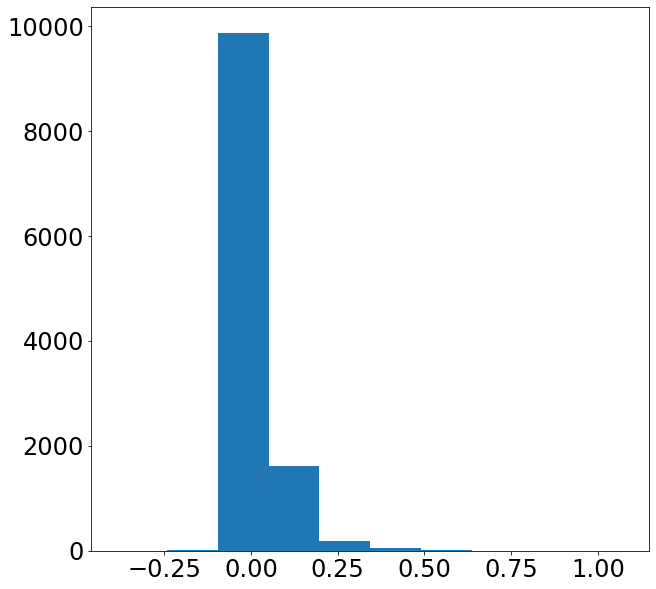

In [367]:

plt.hist(test_labelsM)

(array([1.000e+00, 5.000e+00, 6.900e+01, 9.934e+03, 1.724e+03, 1.900e+01,
        1.000e+01, 2.000e+00, 2.000e+00, 4.000e+00]),
 array([-0.21619426, -0.15925762, -0.10232097, -0.04538433,  0.01155232,
         0.06848896,  0.1254256 ,  0.18236226,  0.2392989 ,  0.29623553,
         0.35317218], dtype=float32),
 <a list of 10 Patch objects>)

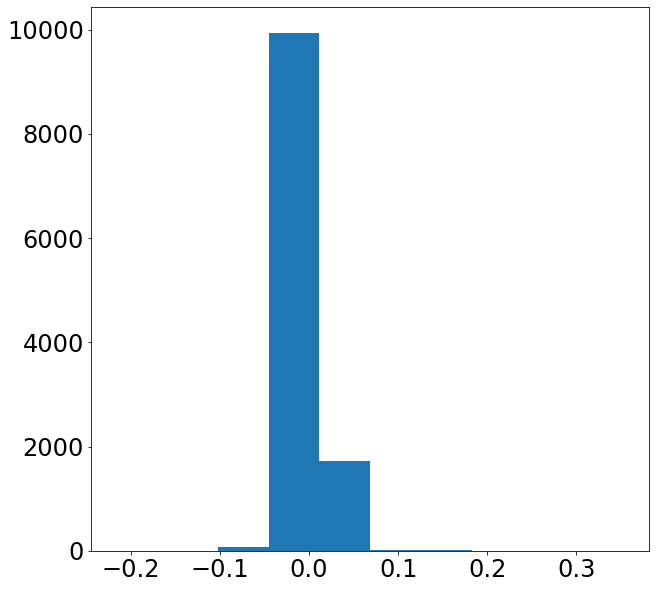

In [368]:
plt.hist(ANNpredictionsM)

In [295]:
data = pd.read_csv("/Volumes/d1/mccandle/mlsurfacelayer/cabauw_derived_data_20200330_10min_raw.csv", index_col="Time", parse_dates=["Time"])
data = data.dropna()

In [296]:
split_date = pd.Timestamp("2011-01-01")
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

In [297]:
data.columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_2 m_K', 'temperature_10 m_K',
       'temperature_20 m_K', 'temperature_40 m_K', 'pressure_2 m_hPa',
       'potential temperature_2 m_K', 'potential temperature_10 m_K',
       'potential temperature_20 m_K', 'potential temperature_40 m_K',
       'virtual potential temperature_2 m_K',
       'virtual potential temperature_10 m_K',
       'virtual potential temperature_20 m_K',
       'virtual potential temperature_40 m_K', 'mixing ratio_2 m_g kg-1',
       'mixing ratio_10 m_g kg-1', 'mixing ratio_20 m_g kg-1',
       'mixing ratio_40 m_g kg-1', 'relative humidity_2 m_%',
       'relative humidity_10 m_%', 'relative humidity_20 m_%',
       'relative humidity_40 m_%', 'temperature change_4 m_K m-1',
       'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
       'mixing ratio change_4 m_g kg-1 m-1',
       'mixing ratio change_15 m_g kg-1 m-1',
       'mix

In [298]:
input_cols = ['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees',
       'pressure_2 m_hPa', 'potential temperature_10 m_K',
       'potential temperature_2 m_K', 'mixing ratio_10 m_g kg-1',
       'relative humidity_10 m_%',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind speed_20 m_m s-1',
       'wind speed_40 m_m s-1',
       'mixing ratio_2 m_g kg-1',
       'relative humidity_2 m_%', 'bulk richardson_10-2 m_']
output_col_1 = 'friction velocity_surface_m s-1'

In [299]:
# Test adding in Bulk Richardson Number as a Predictor
datasetC = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetC['LowLevel Potential Temp K'] = train_data['potential temperature_10 m_K']
datasetC['MidLevel Potential Temp K'] = train_data['potential temperature_20 m_K']
datasetC['TopLevel Potential Temp K'] = train_data['potential temperature_40 m_K']
datasetC['LowLevel Wind Speed m/s'] = train_data['wind speed_10 m_m s-1']
datasetC['LowLevel Wind Dir deg'] = train_data['wind direction_10 m_degrees']
datasetC['MidLevel Wind Speed m/s'] = train_data['wind speed_20 m_m s-1']
datasetC['MidLevel Wind Dir deg'] = train_data['wind direction_20 m_degrees']
datasetC['TopLevel Wind Speed m/s'] = train_data['wind speed_40 m_m s-1']
datasetC['TopLevel Wind Dir deg'] = train_data['wind direction_40 m_degrees']
datasetC['2m RH %'] = train_data['relative humidity_2 m_%']
datasetC['0m GHI w/m^2'] = train_data['global horizontal irradiance_0 m_W m-2']
datasetC['2m Pressure hPa'] = train_data['pressure_2 m_hPa']
datasetC['0m Solar Zenith Angle deg'] = train_data['zenith_0 m_degrees']
datasetC['TopLevel Soil Water Content m3/m3'] = train_data['soil water content_3 cm_m3 m-3']
datasetC['TopLevel Soil Temp K'] = train_data['soil temperature_4 cm_K']
datasetC['10m Bulk Richardson'] = train_data['bulk richardson_10-2 m_']
# These are potentially needed for other computations, but not as predictors
datasetC['10m Temp K'] = train_data['temperature_10 m_K']
datasetC['2m Temp K'] = train_data['temperature_2 m_K']
datasetC['10m U-Wind m/s'] = train_data['u wind_10 m_m s-1']
datasetC['10m V-Wind m/s'] = train_data['v wind_10 m_m s-1']

datasetTestC = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetTestC['LowLevel Potential Temp K'] = test_data['potential temperature_10 m_K']
datasetTestC['MidLevel Potential Temp K'] = test_data['potential temperature_20 m_K']
datasetTestC['TopLevel Potential Temp K'] = test_data['potential temperature_40 m_K']
datasetTestC['LowLevel Wind Speed m/s'] = test_data['wind speed_10 m_m s-1']
datasetTestC['LowLevel Wind Dir deg'] = test_data['wind direction_10 m_degrees']
datasetTestC['MidLevel Wind Speed m/s'] = test_data['wind speed_20 m_m s-1']
datasetTestC['MidLevel Wind Dir deg'] = test_data['wind direction_20 m_degrees']
datasetTestC['TopLevel Wind Speed m/s'] = test_data['wind speed_40 m_m s-1']
datasetTestC['TopLevel Wind Dir deg'] = test_data['wind direction_40 m_degrees']
datasetTestC['2m RH %'] = test_data['relative humidity_2 m_%']
datasetTestC['0m GHI w/m^2'] = test_data['global horizontal irradiance_0 m_W m-2']
datasetTestC['2m Pressure hPa'] = test_data['pressure_2 m_hPa']
datasetTestC['0m Solar Zenith Angle deg'] = test_data['zenith_0 m_degrees']
datasetTestC['TopLevel Soil Water Content m3/m3'] = test_data['soil water content_3 cm_m3 m-3']
datasetTestC['TopLevel Soil Temp K'] = test_data['soil temperature_4 cm_K']
datasetTestC['10m Bulk Richardson'] = test_data['bulk richardson_10-2 m_']
# These are potentially needed for other computations, but not as predictors
datasetTestC['10m Temp K'] = test_data['temperature_10 m_K']
datasetTestC['2m Temp K'] = test_data['temperature_2 m_K']
datasetTestC['10m U-Wind m/s'] = test_data['u wind_10 m_m s-1']
datasetTestC['10m V-Wind m/s'] = test_data['v wind_10 m_m s-1']

featuresMC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresBC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresFC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']

MoistureScaleTrainC = train_data['moisture scale_surface_g kg-1']
TemperatureScaleTrainC = train_data['temperature scale_surface_K']
FrictionVelocityTrainC = train_data['friction velocity_surface_m s-1']

MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
TemperatureScaleTestC = test_data['temperature scale_surface_K']
FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

# Put in nomenclature so that either yearly or random split can be used
train_featuresMC = datasetC
train_labelsMC = MoistureScaleTrainC
train_featuresFC = datasetC
train_labelsFC = FrictionVelocityTrainC
train_featuresTC = datasetC
train_labelsTC = TemperatureScaleTrainC

test_featuresMC = datasetTestC
test_labelsMC = MoistureScaleTestC
test_featuresFC = datasetTestC
test_labelsFC = FrictionVelocityTestC
test_featuresTC = datasetTestC
test_labelsTC = TemperatureScaleTestC

######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
rfMC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfTC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfFC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
# Train the model on training data
rfMC.fit(train_featuresMC.iloc[:,0:16], train_labelsMC);
rfFC.fit(train_featuresFC.iloc[:,0:16], train_labelsFC);
rfTC.fit(train_featuresTC.iloc[:,0:16], train_labelsTC);

# Use the forest's predict method on the test data
predictionsMC = rfMC.predict(test_featuresMC.iloc[:,0:16])
predictionsTC = rfTC.predict(test_featuresTC.iloc[:,0:16])
predictionsFC = rfFC.predict(test_featuresFC.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMC = abs(predictionsMC - test_labelsMC)
errorsTC = abs(predictionsTC - test_labelsTC)
errorsFC = abs(predictionsFC - test_labelsFC)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMC), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTC), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFC), 4))
print('Moisture Scale Mean: ',np.mean(MoistureScaleTestC))
print('Moisture Scale Standard Deviation: ',np.std(MoistureScaleTestC))
print('Temperature Scale Mean: ',np.mean(TemperatureScaleTestC))
print('Temperature Scale Standard Deviation: ',np.std(TemperatureScaleTestC))
print('Friction Velocity Mean: ',np.mean(FrictionVelocityTestC))
print('Friction Velocity Standard Deviation: ',np.std(FrictionVelocityTestC))

# Feature selection
importancesMC = list(rfMC.feature_importances_)
feature_listMC = featuresMC
feature_importancesMC = [(featuresMC,round(importancesMC,2)) for featuresMC, importancesMC in zip(feature_listMC,importancesMC)]
feature_importancesMC = sorted(feature_importancesMC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting moisture scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesMC];

# Feature selection
importancesTC = list(rfTC.feature_importances_)
feature_listTC = featuresBC
feature_importancesTC = [(featuresTC,round(importancesTC,2)) for featuresTC, importancesTC in zip(feature_listTC,importancesTC)]
feature_importancesTC = sorted(feature_importancesTC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting temperature scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesTC];

# Feature selection
importancesFC = list(rfFC.feature_importances_)
featuresFC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
feature_listFC = featuresFC
feature_importancesFC = [(featuresFC,round(importancesFC,2)) for featuresFC, importancesFC in zip(feature_listFC,importancesFC)]
feature_importancesFC = sorted(feature_importancesFC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting friction velocity")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesFC];

Mean Absolute Error for predicting Moisture Scale: 0.0554
Mean Absolute Error for predicting Temperature Scale: 0.0296
Mean Absolute Error for predicting Friction Velocity: 0.0312
Moisture Scale Mean:  0.03177048263835641
Moisture Scale Standard Deviation:  0.22914452358120893
Temperature Scale Mean:  0.0020681011458729935
Temperature Scale Standard Deviation:  0.12645654519778302
Friction Velocity Mean:  0.23987369628432456
Friction Velocity Standard Deviation:  0.15685092094636724
Features importances for predicting moisture scale
Variable:0m GHI w/m^2         Importance: 0.56
Variable:10m bulk richardson number Importance: 0.34
Variable:LowLevel Wind Speed m/s Importance: 0.02
Variable:0m Solar Zenith Angle deg Importance: 0.02
Variable:MidLevel Wind Speed m/s Importance: 0.01
Variable:TopLevel Wind Speed m/s Importance: 0.01
Variable:2m RH %              Importance: 0.01
Variable:5cm Water Content    Importance: 0.01
Variable:LowLevel Potential Temp K Importance: 0.0
Variable:MidLe

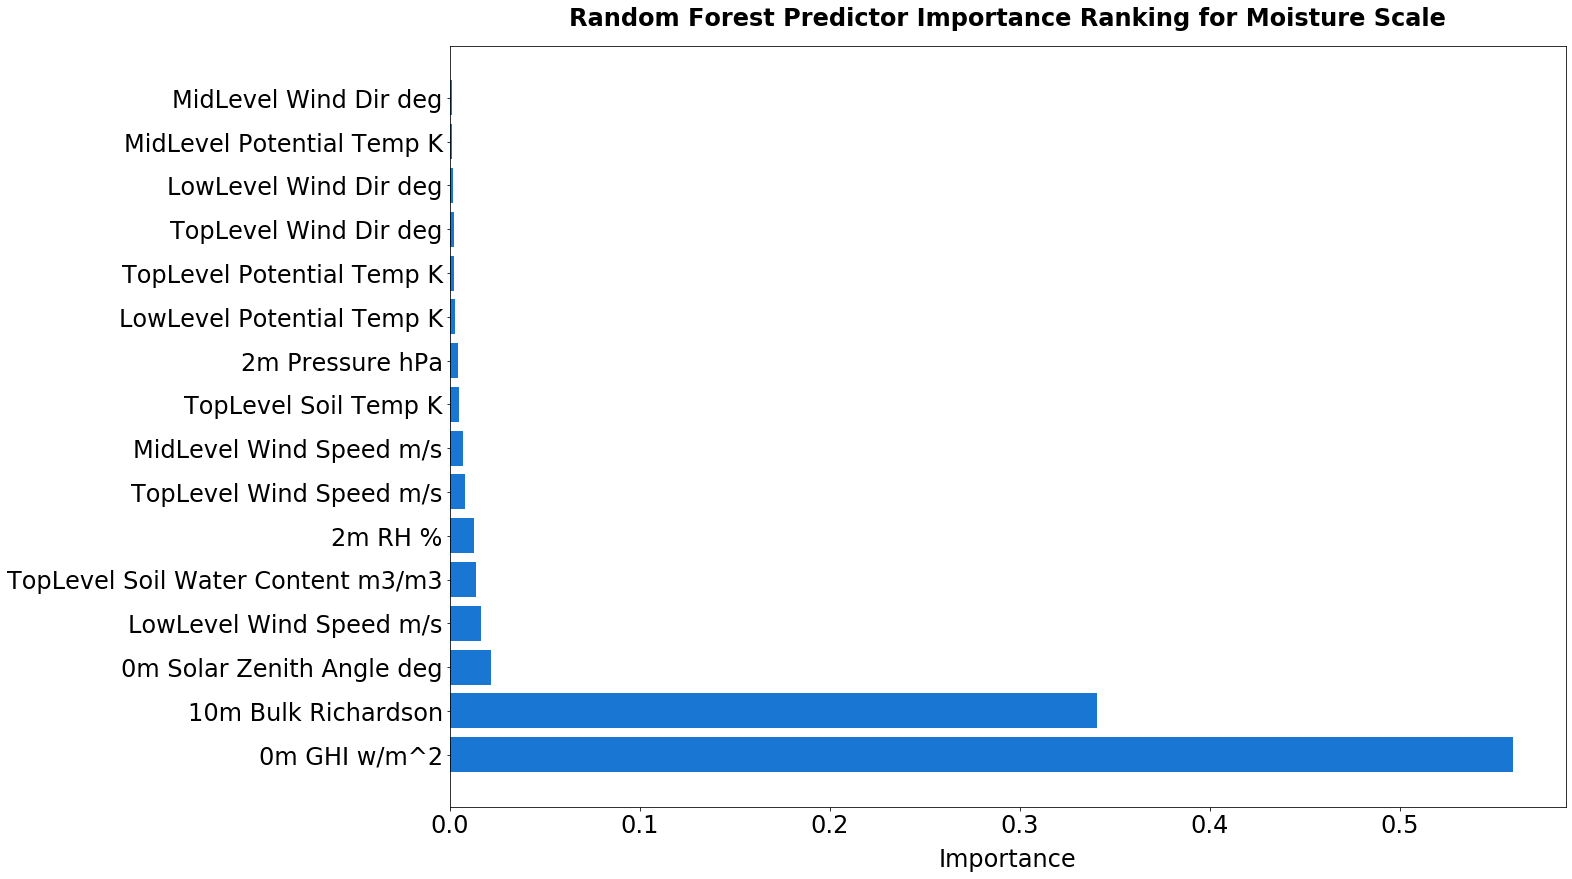

In [300]:
dset = pd.DataFrame()
tf_MC = train_featuresMC.iloc[:,0:16]
dset['attr'] = tf_MC.columns
dset['importance'] = rfMC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Moisture Scale', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-MoistureScale-Cabauw.png')
plt.show()



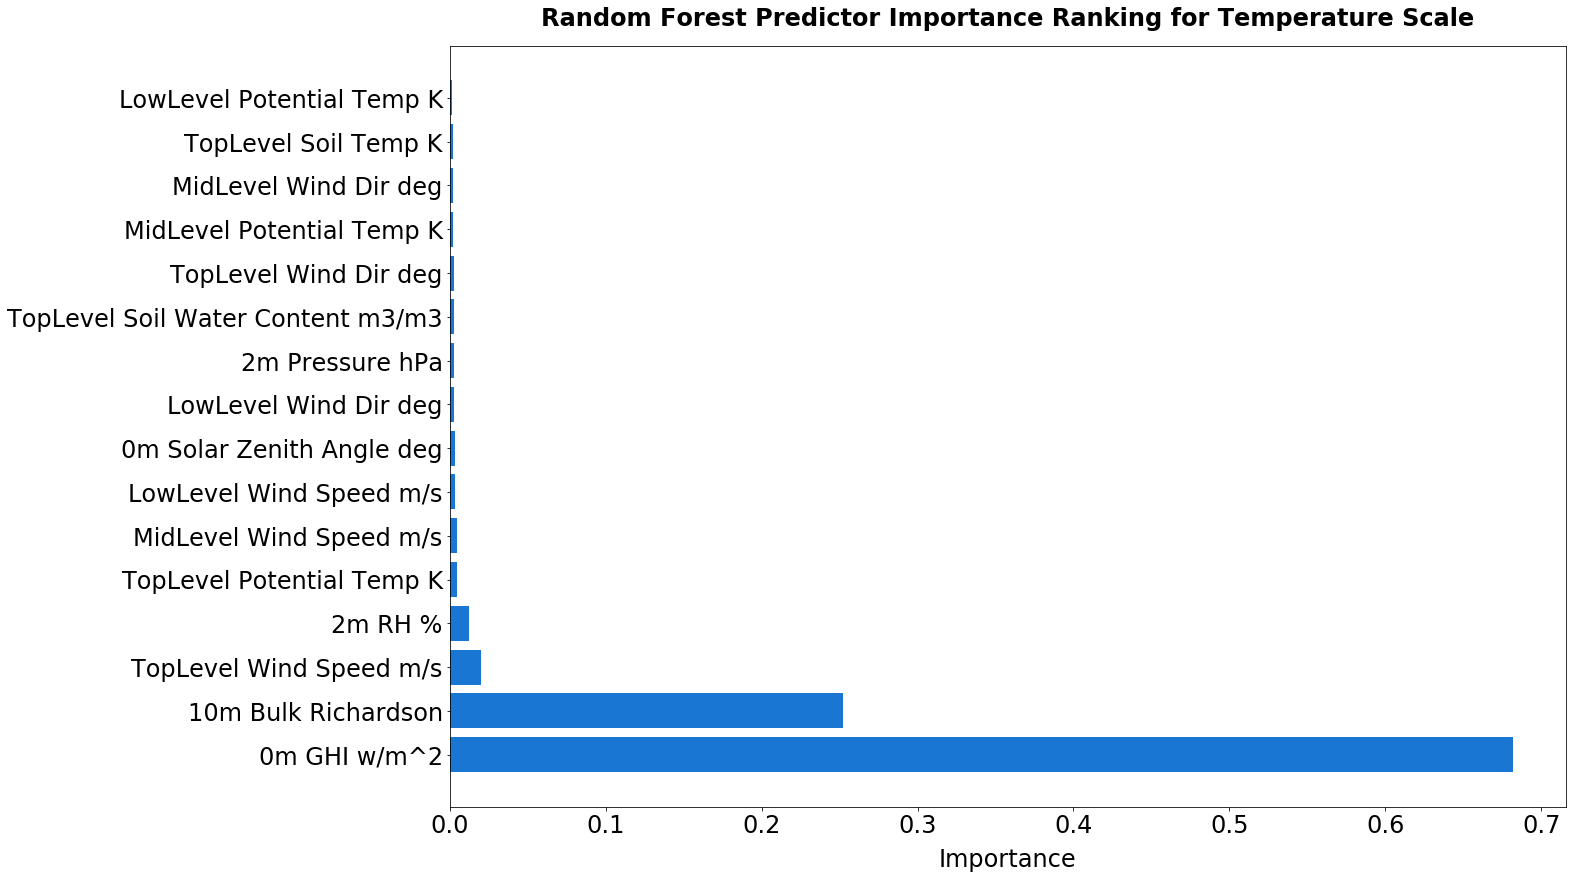

In [301]:
dset = pd.DataFrame()
tf_TC = train_featuresTC.iloc[:,0:16]
dset['attr'] = tf_TC.columns
dset['importance'] = rfTC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Temperature Scale', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-TemperatureScale-Cabauw.png')
plt.show()

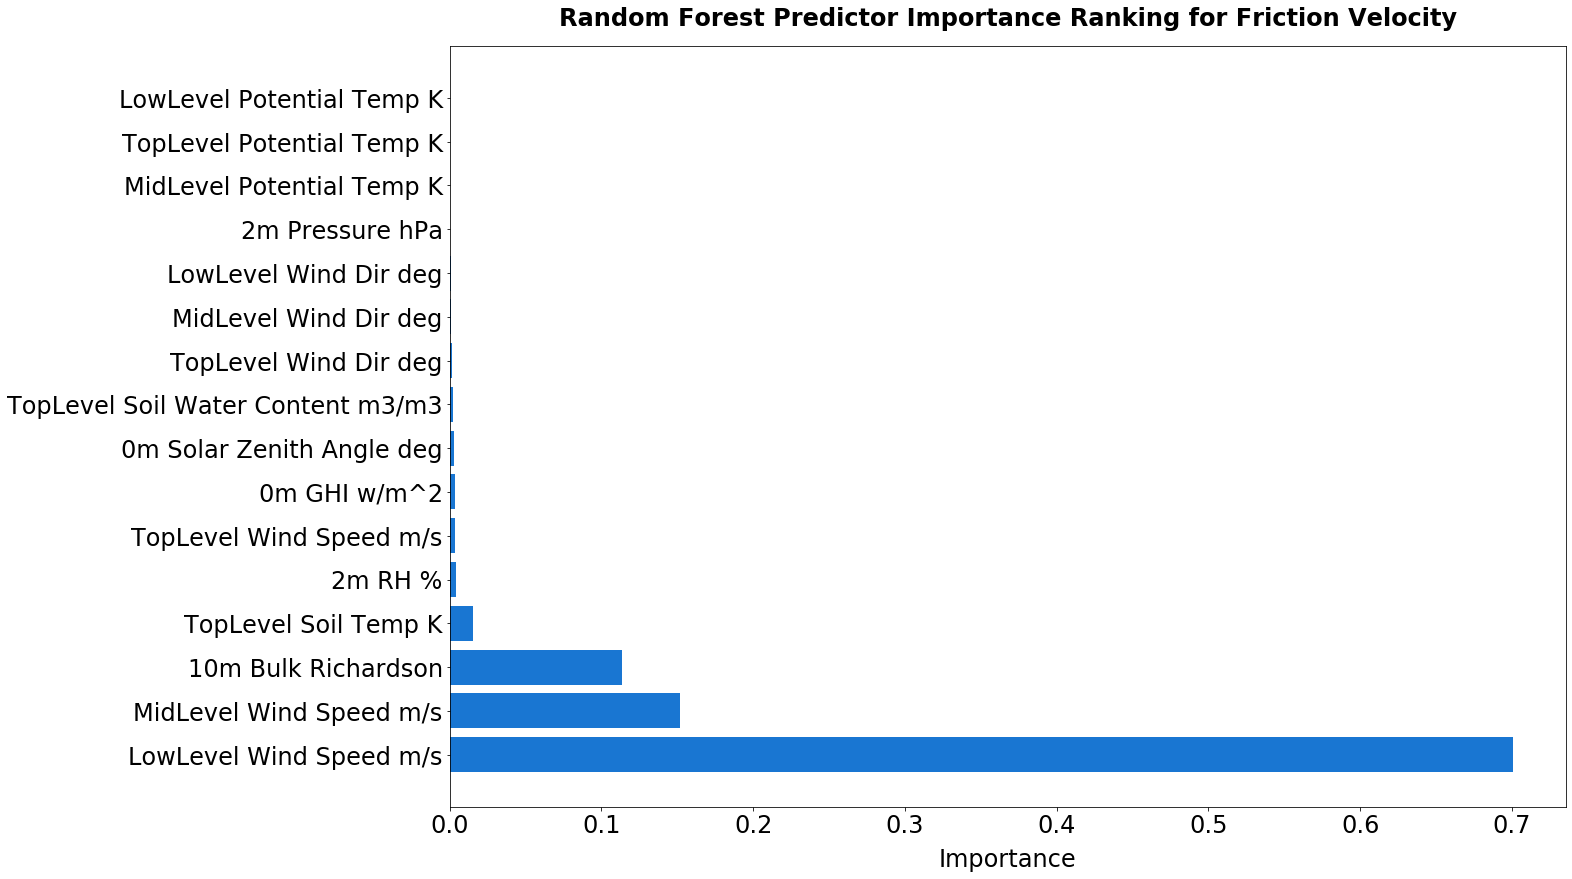

In [302]:
dset = pd.DataFrame()
tf_FC = train_featuresFC.iloc[:,0:16]
dset['attr'] = tf_FC.columns
dset['importance'] = rfFC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Friction Velocity', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-FrictionVelocity-Cabauw.png')
plt.show()

In [380]:
## Update this to train ANN rather than RF for different regimes
import tensorflow as tf
from tensorflow import keras
def build_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    batch_size=32
    model.compile(loss='mae',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

# Train ANN on negative BRN predictions
EPOCHS = 25

######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
ANN_MC = build_model(np.asarray(train_featuresMC.iloc[:,0:16]))
ANN_TC = build_model(np.asarray(train_featuresTC.iloc[:,0:16]))
ANN_FC = build_model(np.asarray(train_featuresFC.iloc[:,0:16]))

# Train the model on training data
historyMC = ANN_MC.fit(np.asarray(train_featuresMC.iloc[:,0:16]), np.asarray(train_labelsMC), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyFC = ANN_FC.fit(np.asarray(train_featuresFC.iloc[:,0:16]), np.asarray(train_labelsFC), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyTC = ANN_TC.fit(np.asarray(train_featuresTC.iloc[:,0:16]), np.asarray(train_labelsTC), epochs=EPOCHS, validation_split=0.2,verbose=0)

# Use the forest's predict method on the test data
ANNpredictionsMC = ANN_MC.predict(np.asarray(test_featuresMC.iloc[:,0:16]))
ANNpredictionsTC = ANN_TC.predict(np.asarray(test_featuresTC.iloc[:,0:16]))
ANNpredictionsFC = ANN_FC.predict(np.asarray(test_featuresFC.iloc[:,0:16]))

ANNpredictionsMC = ANNpredictionsMC.reshape(len(ANNpredictionsMC,))
ANNpredictionsTC = ANNpredictionsTC.reshape(len(ANNpredictionsTC,))
ANNpredictionsFC = ANNpredictionsFC.reshape(len(ANNpredictionsFC,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC = abs(ANNpredictionsMC - test_labelsMC)
ANNerrorsTC = abs(ANNpredictionsTC - test_labelsTC)
ANNerrorsFC = abs(ANNpredictionsFC - test_labelsFC)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC), 4))

Mean Absolute Error for predicting Moisture Scale: 0.0582
Mean Absolute Error for predicting Temperature Scale: 0.0316
Mean Absolute Error for predicting Friction Velocity: 0.0296


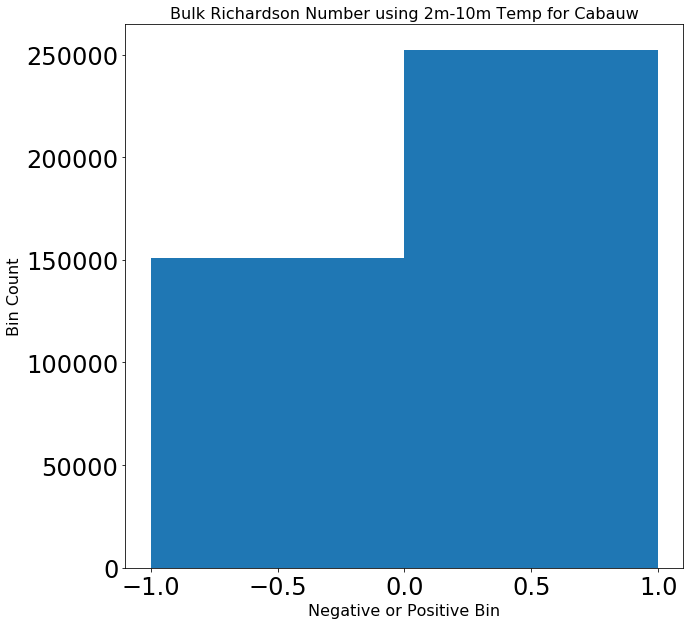

In [381]:
datasetC["BRN_sign"] = np.sign(datasetC['10m Bulk Richardson'])
plt.title('Bulk Richardson Number using 2m-10m Temp for Cabauw', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(datasetC["BRN_sign"],bins=2)
plt.savefig('BRN_2-10m_Cabauw.png')

In [382]:
from math import log, atan, sqrt
import numpy as np
from numba import jit
@jit(nopython=True)
def mo_similarity(u10, v10, tsk, t2, qsfc, q2, psfc, mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0):
    """
    Calculate flux information based on Monin-Obukhov similarity theory.

    Args:
        u10: 10 m level zonal wind speed [m/s]
        v10: 10 m level meridional wind speed [m/s]
        tsk: surface skin temperature [K]
        t2: 2 m level temperature [K]
        qsfc: ground mixing ratio [kg /kg]
        q2: 2 m level mixing ratio [kg / kg]
        psfc: surface pressure [hPa]
        z0: momentum roughness length
        zt0: heat flux roughness length
        z10: Height of "10 m" layer
        z2: Height of "2 m" layer

    Returns:
        ustar: friction velocity
        tstar: temperature scale
        wthv0: -ustar * tstar
        zeta10: z/L for a z of 10 m. Used for momentum flux
        phim10: momentum universal function at 10 m
        zeta2: z/L for a z of 2 m.
        phih2: sensible heat flux universal function at 2 m.
    """
    if z0 > 0:
        z10oz0 = z10 / z0
        z2oz0 = z2 / z0
        z2ozt0 = z2 / zt0
    else:
        raise ValueError("z0 must be greater than 0")
    # else:
    #    sys.exit("Surface roughnes, z0, must be greter than 0.!")
    #
    # Gravitational acceleration
    g = 9.81
    #
    # Gas constant over spcific heat capacity at constant pressure
    r = 287.058
    cp = 1005.
    rocp = r / cp
    #
    # Reference pressure and temperature
    p0 = 1000.
    t0 = 300.
    #
    # Set M-O parameters based on Dyer 1974 paper
    karman = 0.4
    beta = 5.0
    gamma = 16.0
    #
    # Air density
    rho = psfc / (r * t2)
    #
    # Potential temperature speed at level 1
    th2 = t2 * (p0 / psfc) ** rocp
    th0 = tsk * (p0 / psfc) ** rocp
    #
    # Virtual potential temperature
    thv2 = th2 * (1. + 0.61 * q2)
    thv0 = th0 * (1. + 0.61 * qsfc)
    #
    # Small number
    epsilon = 1.e-6
    #
    # Initial values of drag coefficients - neutrally stratified case
    cd = karman ** 2 / ((log(z10oz0)) ** 2)
    ch = karman ** 2 / ((log(z2ozt0)) ** 2)
    cq = karman ** 2 / ((log(z2oz0)) ** 2)
    #
    # Initial values of surface friction velocity, temperature scale, and
    # heat flux
    wind_speed = sqrt(u10 * u10 + v10 * v10)
    if wind_speed < 0.1:
        wind_speed = 0.1
        u10 = 0.1
    tauxz = cd * wind_speed * u10
    tauyz = cd * wind_speed * v10
    ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25

    tstar = -ch / ustar * wind_speed * (thv0 - thv2)
    qstar = cq / ustar * mavail * wind_speed * (qsfc - q2)
    wthv0 = -ustar * tstar
    #
    # Set stopping criterion
    diff = 1.
    #
    # Set stability functions
    psim10 = 0.
    psim2 = 0.
    psih2 = 0.
    psiq2 = 0.
    phim10 = 0.
    phih2 = 0
    #
    zeta10 = 0.
    zeta2 = 0.
    count = 0
    while diff > epsilon and count < 100:
        #
        # Surface friction velocity and temperature scale
        tauxz = cd * wind_speed * u10
        tauyz = cd * wind_speed * v10
        ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
        if ustar < 0.01:
            ustar = 0.01
        wspd2 = ustar / karman * (log(z2oz0) - psim2)
        tstar = -ch / ustar * wspd2 * (thv0 - thv2)
        qstar = cq / ustar * mavail * wspd2 * (qsfc - q2)
        wthv0 = -ustar * tstar
        #
        # Compute drag coefficients
        cdold = cd
        chold = ch
        cqold = cq
        #
        # Neutrally stratified case
        if wthv0 == 0:
            zeta10 = 0.
            zeta2 = 0.
            psim10 = 0.
            psim2 = 0.
            psih2 = 0.
            psiq2 = 0.
            phim10 = 1.
            phih2 = 1.
            cd = karman ** 2 / ((log(z10oz0)) ** 2)
            ch = karman ** 2 / ((log(z2ozt0)) ** 2)
            cq = karman ** 2 / ((log(z2oz0)) ** 2)
        elif abs(wthv0) > 0:
            #
            # Obukhov length scale
            olength = -ustar ** 3 / (karman * g / t0 * wthv0)
            if abs(olength) < 10 and olength > 0:
                olength = z10
            elif abs(olength) < 10 and olength < 0:
                olength = -z10
            #
            # Free convection
            # if (olength == 0.):
            #    sys.exit("Free convection!")
            #
            # Monin-Obukhov stability parameter
            zeta10 = z10 / olength
            zeta2 = z2 / olength
            #
            # Convective case
            if (zeta2 < -epsilon) & (zeta10 >= -2.):
                xi10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                xi2 = 1. / ((1. - gamma * zeta2) ** 0.25)
                psim10 = log(0.5 * (1.0 + xi10 ** 2) * (0.5 * (1.0 + xi10)) ** 2) \
                    - 2. * atan(xi10) + 0.5 * np.pi
                psim2 = log(0.5 * (1.0 + xi2 ** 2) * (0.5 * (1.0 + xi2)) ** 2) \
                    - 2. * atan(xi2) + 0.5 * np.pi
                psih2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                psiq2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                phim10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                phih2 = 1. / ((1. - gamma * zeta2) ** 0.25)
            #
            # Stably stratified case
            elif (zeta2 > epsilon) & (zeta2 <= 1.):
                psim10 = - beta * zeta10
                psim2 = - beta * zeta2
                psih2 = - beta * zeta2
                psiq2 = - beta * zeta2
                phim10 = (1. + beta * zeta10)
                phih2 = (1. + beta * zeta2)
            #
            # Neutrally stratified case
            elif (zeta2 <= epsilon) & (zeta2 >= -epsilon):
                psim10 = 0.
                psim2 = 0.
                psih2 = 0.
                psiq2 = 0.
                phim10 = 1.
                phih2 = 1.
            #
            cd = karman ** 2 / ((log(z10oz0) - psim10) ** 2)
            ch = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psih2))
            cq = karman ** 2 / ((log(z2oz0) - psim2) * (log(z2oz0) - psiq2))
        #
        diff = abs(cd - cdold) + abs(ch - chold) + abs(cq - cqold)
        count += 1
    #
    return ustar, tstar, qstar, wthv0, zeta10, phim10, zeta2, phih2

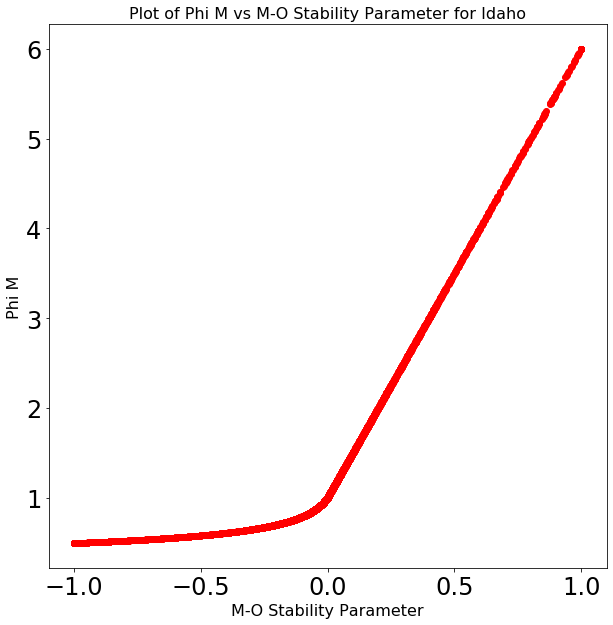

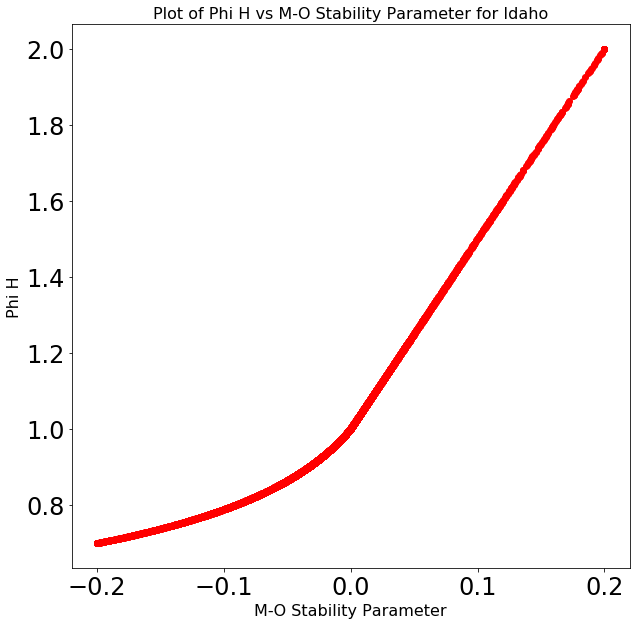

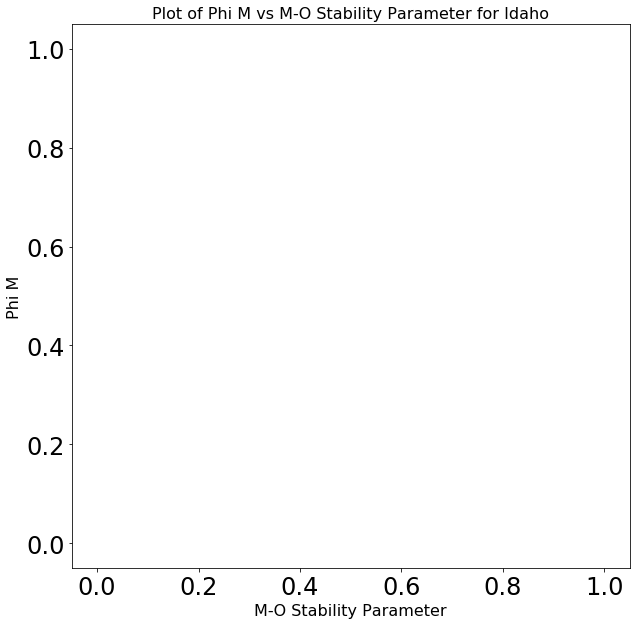

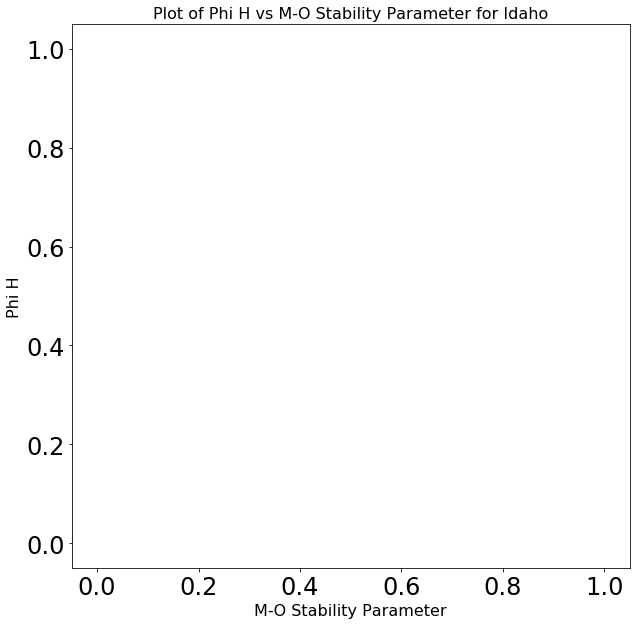

In [383]:
# Test the MO Similarity on the test dataset for the RF Predictions #
#--- Inputs
# Wind velocity at 10 m
u10 = datasetTest['10m U-Wind m/s']
v10 = datasetTest['10m V-Wind m/s']

# Skin temperature and temperature at 2 m
tsk = datasetTest['2m Temp K']
t2  = datasetTest['10m Temp K'] 

# Set variable to compute saturation mixing ratio at the surface.
# datasetTest['0m RH %'] = 100
#
# Ground mixing ratio and mixing ratio at 2 m
#qsfc, vap_pressure, sat_vap_pressure = mixing_ratio(datasetTest['2m Temp K']-273.15, 
#                    datasetTest['0m RH %'], datasetTest['2m Pressure hPa'])
q2, vap_pressure, sat_vap_pressure    = mixing_ratio(datasetTest['10m Temp K']-273.15, 
                    datasetTest['2m RH %'], datasetTest['2m Pressure hPa'])

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

qsfc = saturation_mixing_ratio(datasetTest['2m Temp K'], datasetTest['2m Pressure hPa'])



qsfc = qsfc / 1000
q2 = q2 /1000
#
# Surface pressure 
psfc = datasetTest['2m Pressure hPa']
#
# Momentum roughness length, heat flux roughness and reference level
z0=0.01 # might want to go back to 0.1 
zt0=0.001 
z10=10.0 
z2=2.0

# Outside the range of M-O Similarity Theory
phim=[]
zolm=[]
phih=[]
zolh=[]
t_2_out=[]
t_sk_out=[]
ustar_out=[]
tstar_out=[]
pred_ustar_out = []
pred_tstar_out = []
actual_ustar_out = []
actual_tstar_out = []
qstar_out = []

# Within the range of M-O Similarity Theory
phimO=[]
zolmO=[]
phihO=[]
zolhO=[]
t_2_in=[]
t_sk_in=[]
ustar_in=[]
tstar_in=[]
pred_ustar_in = []
pred_tstar_in = []
pred_qstar_in = []
actual_ustar_in = []
actual_tstar_in = []
actual_qstar_in = []
qstar_in = []

#ustar,tstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10,v10,tsk,t2,qsfc,q2,psfc,z0,zt0)
#
for i, val in enumerate(u10):
    ustar,tstar,qstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10.iloc[i],v10.iloc[i],tsk.iloc[i],t2.iloc[i],qsfc.iloc[i],q2.iloc[i],psfc.iloc[i],mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0)
    if ((zeta10 < -2.) | (zeta10 > 1.)):
        phimO.append(phim10)
        zolmO.append(zeta10)
        phihO.append(phih2)
        zolhO.append(zeta2)
        t_2_out.append(t2.iloc[i])
        t_sk_out.append(tsk.iloc[i])
        ustar_out.append(ustar)
        tstar_out.append(tstar)
        qstar_out.append(qstar)
        pred_ustar_out.append(predictionsF[i])
        pred_tstar_out.append(predictionsT[i])
        pred_qstar_out.append(predictionsM[i])
        actual_ustar_out.append(test_labelsF.iloc[i])
        actual_tstar_out.append(test_labelsT.iloc[i])
        actual_qstar_out.append(test_labelsM.iloc[i])
        
    else:
        phim.append(phim10)
        zolm.append(zeta10)
        phih.append(phih2)
        zolh.append(zeta2)
        t_2_in.append(t2.iloc[i])
        t_sk_in.append(tsk.iloc[i])
        ustar_in.append(ustar)
        tstar_in.append(tstar)
        qstar_in.append(qstar)
        pred_ustar_in.append(predictionsF[i])
        pred_tstar_in.append(predictionsT[i])
        pred_qstar_in.append(predictionsM[i])
        actual_ustar_in.append(test_labelsF.iloc[i])
        actual_tstar_in.append(test_labelsT.iloc[i])
        actual_qstar_in.append(test_labelsM.iloc[i])
#
p=plt.plot(zolm,phim,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolh,phih,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()
p=plt.plot(zolmO,phimO,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolhO,phihO,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()

(array([ 107.,  401.,  740., 1598., 2655., 2933., 1992.,  855.,  388.,
         101.]),
 array([836.30814 , 839.104976, 841.901812, 844.698648, 847.495484,
        850.29232 , 853.089156, 855.885992, 858.682828, 861.479664,
        864.2765  ]),
 <a list of 10 Patch objects>)

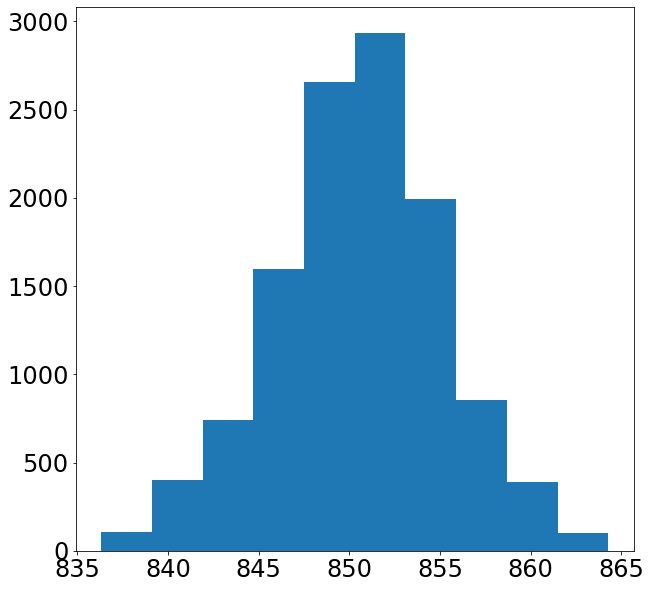

In [384]:
plt.hist(datasetTest['2m Pressure hPa'])

(array([  290.,   652.,  2824., 11165., 27756., 65041., 77227., 46351.,
        17120.,  3379.]),
 array([ 971.4 ,  978.52,  985.64,  992.76,  999.88, 1007.  , 1014.12,
        1021.24, 1028.36, 1035.48, 1042.6 ]),
 <a list of 10 Patch objects>)

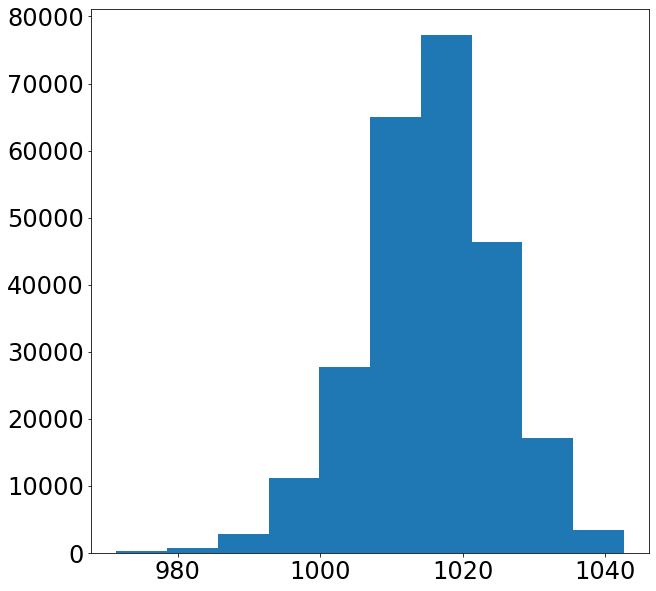

In [385]:
plt.hist(datasetTestC['2m Pressure hPa'])

(array([3026., 3530., 2340., 1104.,  711.,  579.,  239.,  146.,   79.,
          16.]),
 array([0.00052942, 0.00601915, 0.01150888, 0.01699861, 0.02248834,
        0.02797806, 0.03346779, 0.03895752, 0.04444725, 0.04993698,
        0.05542671]),
 <a list of 10 Patch objects>)

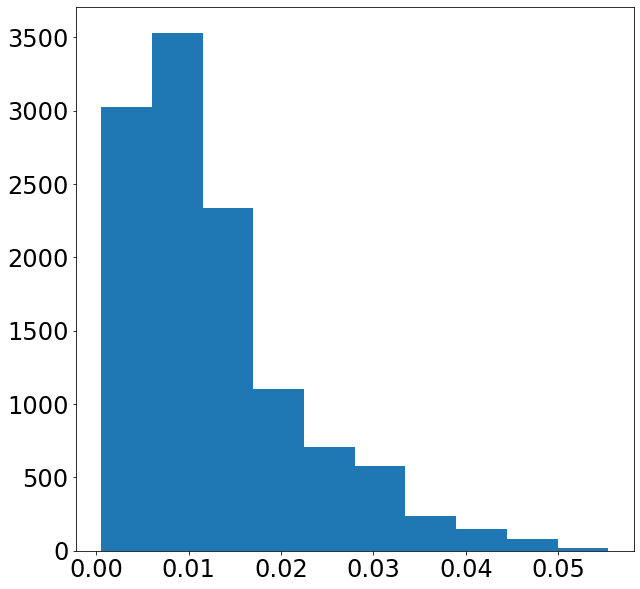

In [386]:
plt.hist(qsfc)

(array([1.004e+03, 3.974e+03, 3.351e+03, 1.648e+03, 1.101e+03, 5.050e+02,
        1.330e+02, 4.000e+01, 1.300e+01, 1.000e+00]),
 array([0.00033918, 0.00197979, 0.00362041, 0.00526102, 0.00690163,
        0.00854225, 0.01018286, 0.01182347, 0.01346409, 0.0151047 ,
        0.01674531]),
 <a list of 10 Patch objects>)

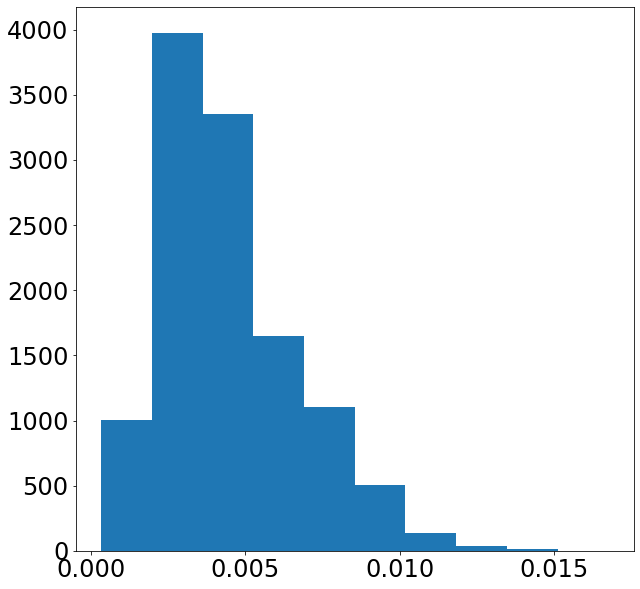

In [387]:
plt.hist(q2)

(array([2124., 3215., 2603., 1504.,  906.,  739.,  351.,  192.,  109.,
          27.]),
 array([ 0.79779942,  6.88092313, 12.96404684, 19.04717056, 25.13029427,
        31.21341798, 37.29654169, 43.37966541, 49.46278912, 55.54591283,
        61.62903654]),
 <a list of 10 Patch objects>)

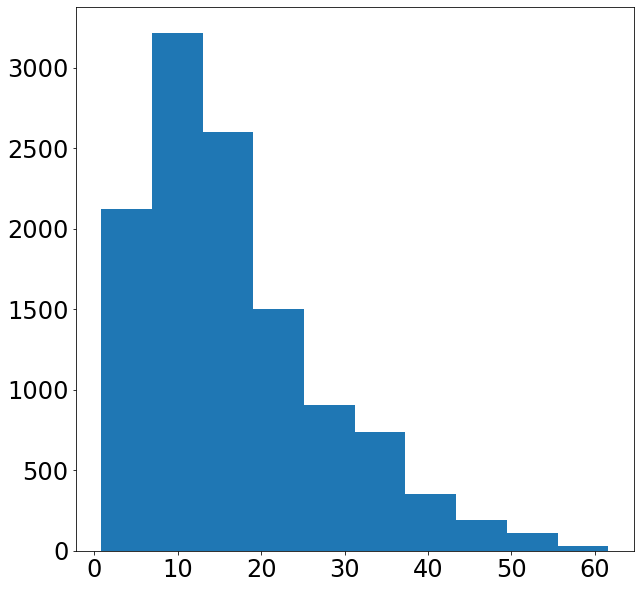

In [388]:
plt.hist(sat_vap_pressure)

(array([2731., 3446., 2438., 1210.,  742.,  642.,  290.,  156.,   96.,
          19.]),
 array([ 0.72596887,  7.61291377, 14.49985866, 21.38680356, 28.27374845,
        35.16069335, 42.04763824, 48.93458314, 55.82152803, 62.70847293,
        69.59541782]),
 <a list of 10 Patch objects>)

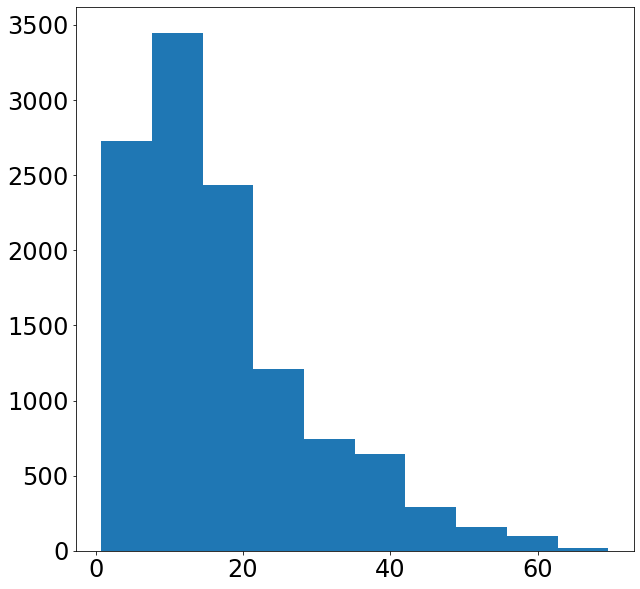

In [389]:

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

sfc_sat_vap_pres = saturation_vapor_pressure(datasetTest['2m Temp K'])
plt.hist(sfc_sat_vap_pres)

The R^2 value is... 0.7993318885127603


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


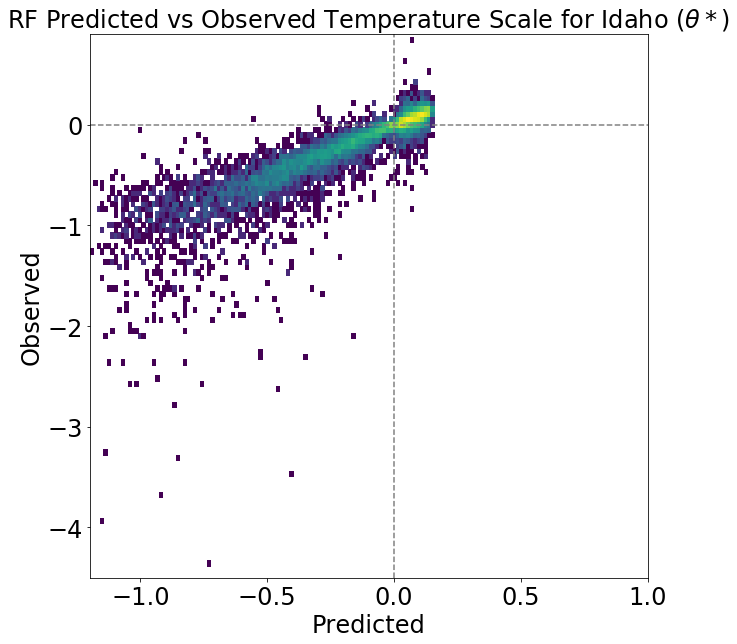

In [390]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.7529448789575623


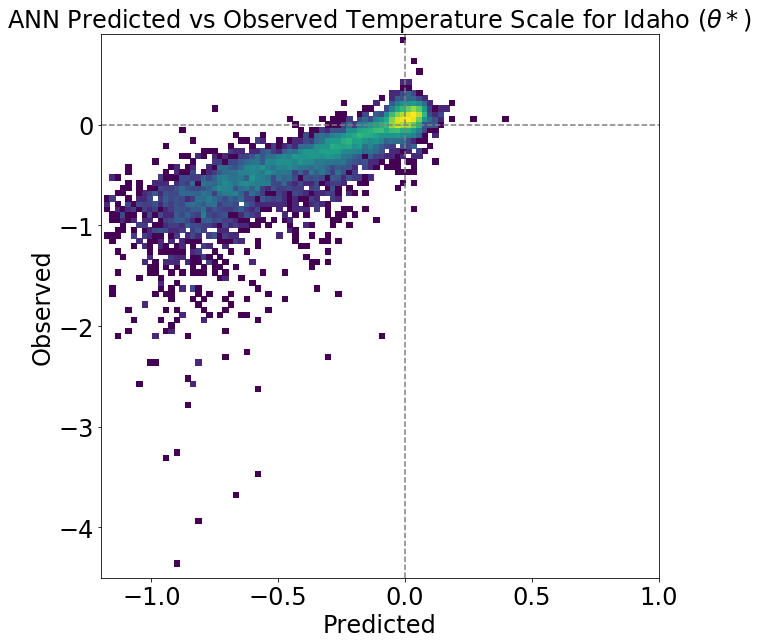

In [391]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.2840832719994306


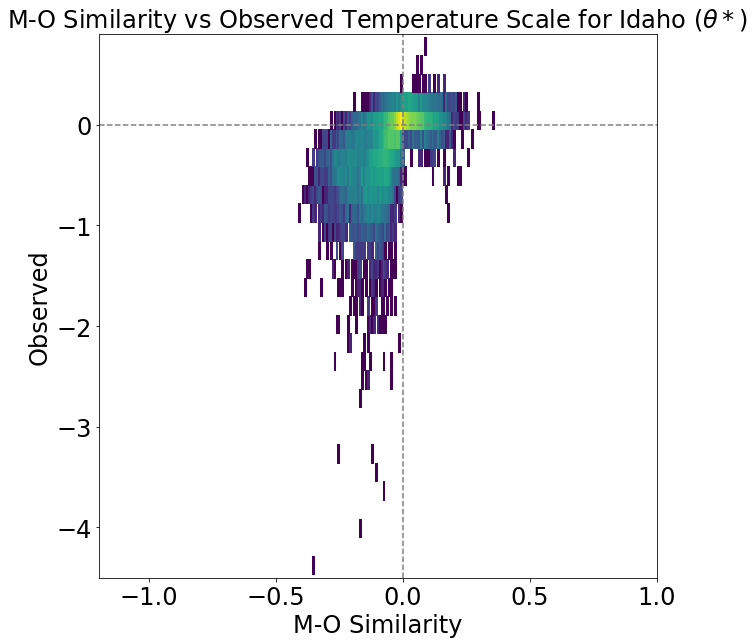

MAE for MO Similarity on T-Scale...
0.20098393561159536


In [392]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
y = np.array(actual_tstar_in)
x = np.array(tstar_in) 
#x = x[y>-5] # Filter out a bad data point
#y = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_tscale_idaho.png')
plt.show()

print("MAE for MO Similarity on T-Scale...")
errorsMO_TI_C = abs(x - y)
print(np.mean(errorsMO_TI_C))

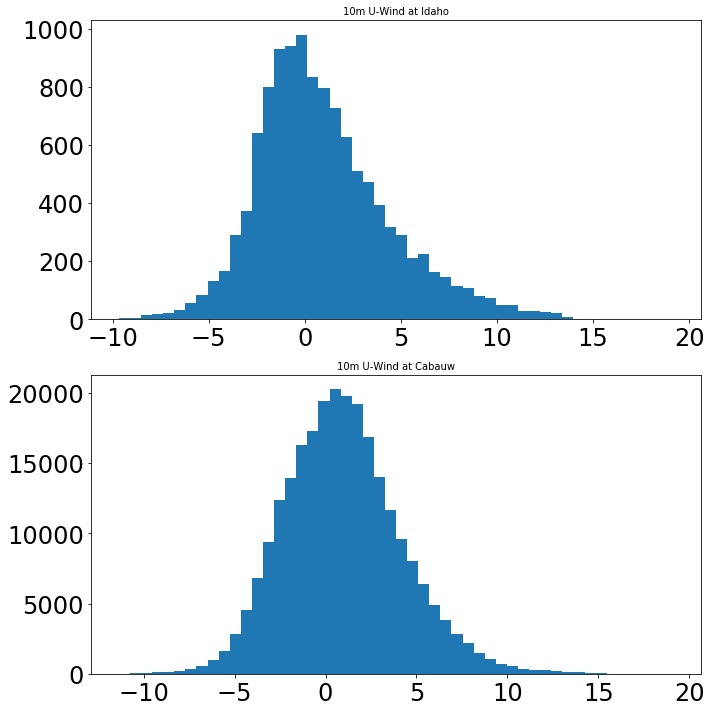

In [393]:
plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(datasetTest['10m U-Wind m/s'],bins=50)
        ax.set_title('10m U-Wind at Idaho', size = 10)
    elif i == 2:
        ax.hist(datasetTestC['10m U-Wind m/s'],bins=50)
        ax.set_title('10m U-Wind at Cabauw', size = 10)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

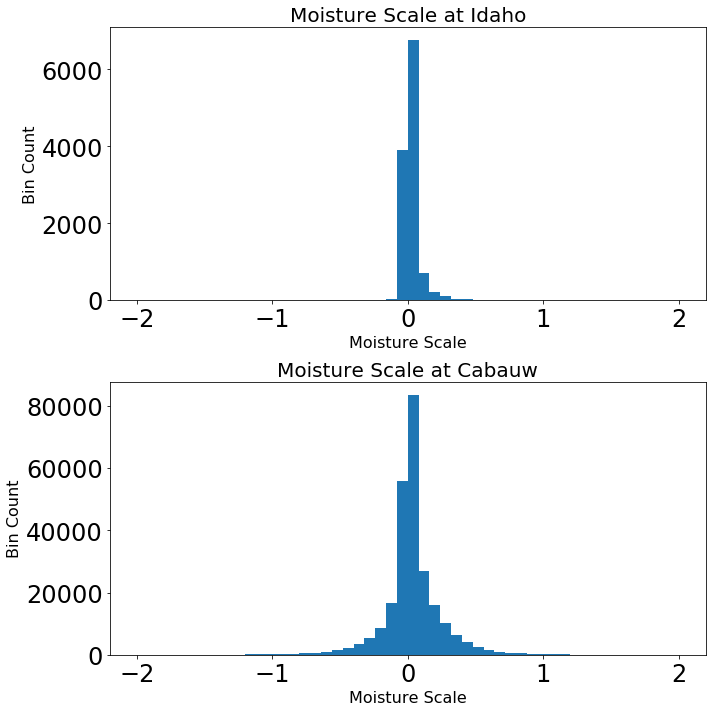

In [394]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(MoistureScaleTest,range =(-2, 2),bins=50)
        ax.set_title('Moisture Scale at Idaho', size = 20)
        ax.set_xlabel('Moisture Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    elif i == 2:
        ax.hist(MoistureScaleTestC,range =(-2, 2),bins=50)
        ax.set_title('Moisture Scale at Cabauw', size = 20)
        ax.set_xlabel('Moisture Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

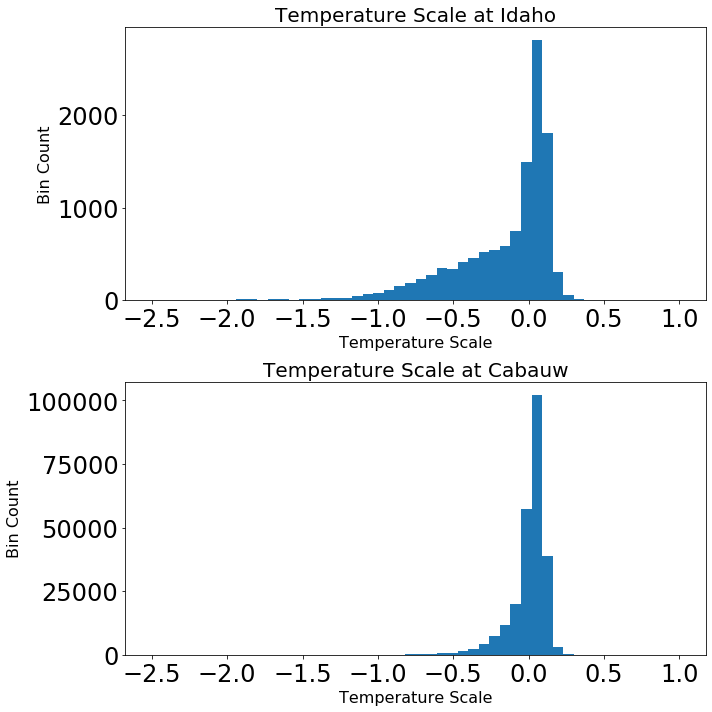

In [395]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(TemperatureScaleTest,range =(-2.5, 1),bins=50)
        ax.set_title('Temperature Scale at Idaho', size = 20)
        ax.set_xlabel('Temperature Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    elif i == 2:
        ax.hist(TemperatureScaleTestC,range =(-2.5, 1),bins=50)
        ax.set_title('Temperature Scale at Cabauw', size = 20)
        ax.set_xlabel('Temperature Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

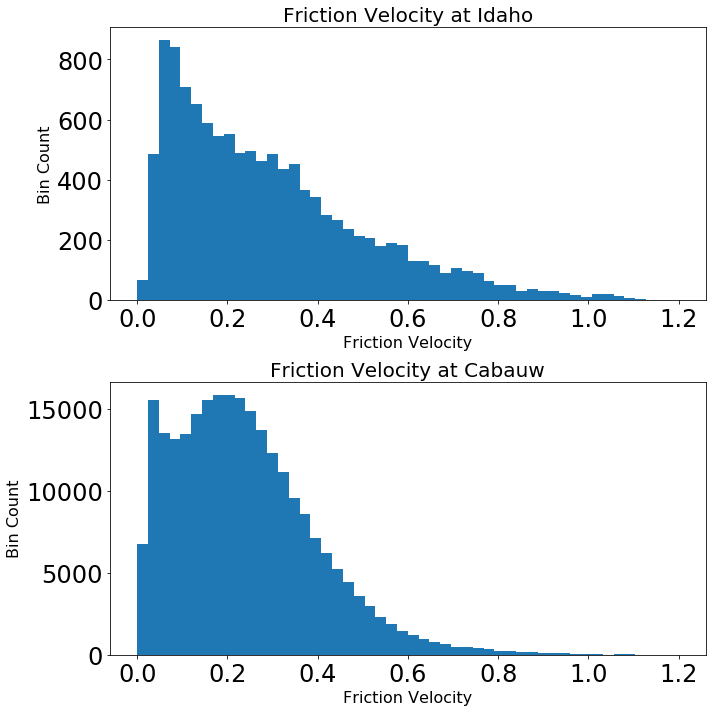

In [396]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(FrictionVelocityTest,range =(0, 1.2),bins=50)
        ax.set_title('Friction Velocity at Idaho', size = 20)
        ax.set_xlabel('Friction Velocity', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
        
    elif i == 2:
        ax.hist(FrictionVelocityTestC,range =(0, 1.2),bins=50)
        ax.set_title('Friction Velocity at Cabauw', size = 20)
        ax.set_xlabel('Friction Velocity', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

The R^2 value is... 0.40952677019779915


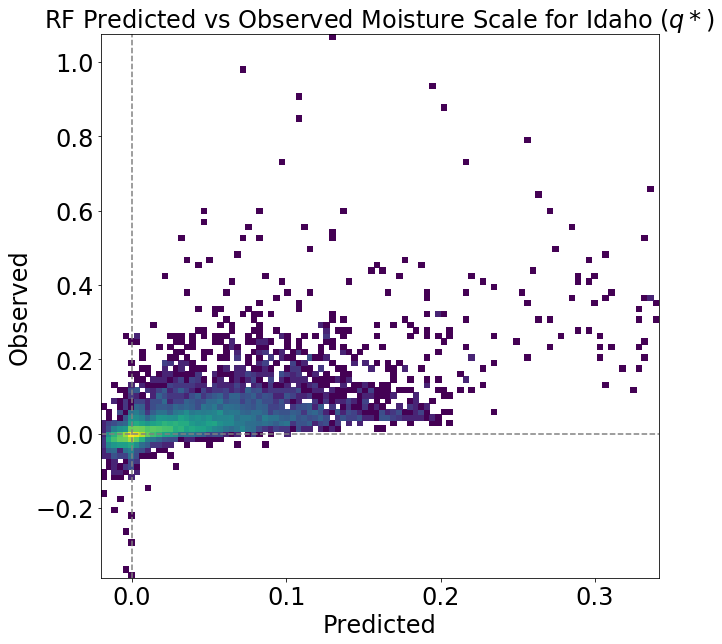

In [397]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.161262651997129


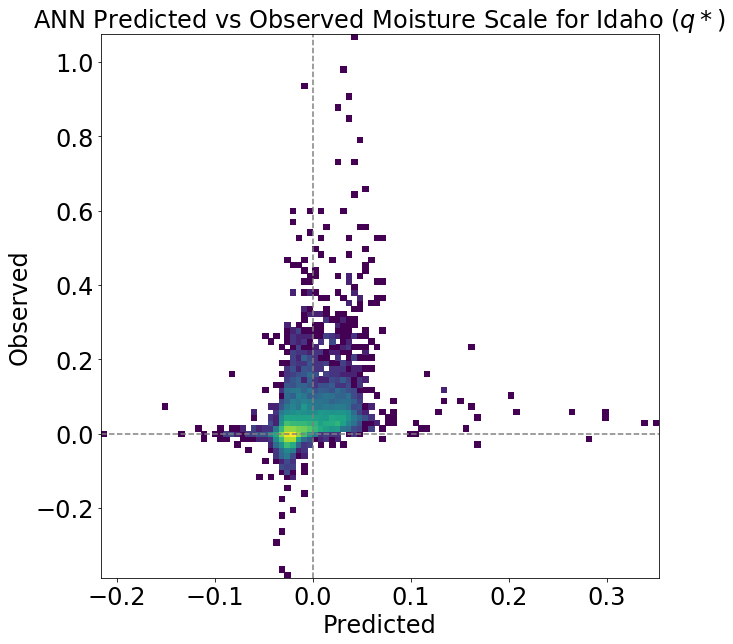

In [398]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.010937914322400103


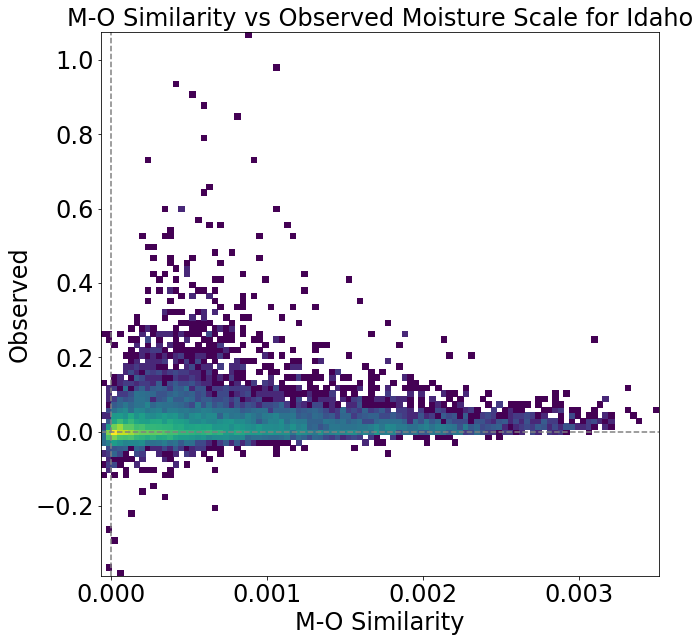

MAE for MO Similarity on Moisture Scale...
0.032242921057041386


In [399]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]

x = np.array(qstar_in)
y = np.array(actual_qstar_in) 

y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Moisture Scale for Idaho', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_mscale_idaho.png')
plt.show()

print("MAE for MO Similarity on Moisture Scale...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

The R^2 value is... 0.9082101794062303


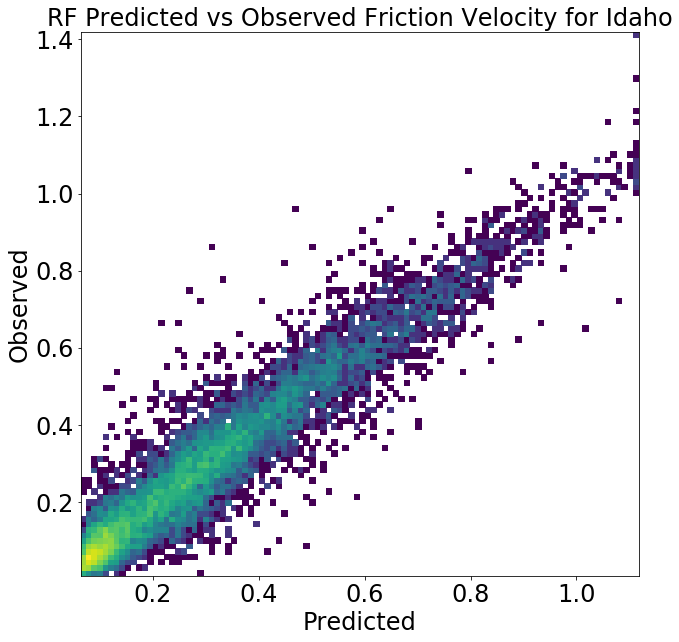

In [400]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.8257103740404184


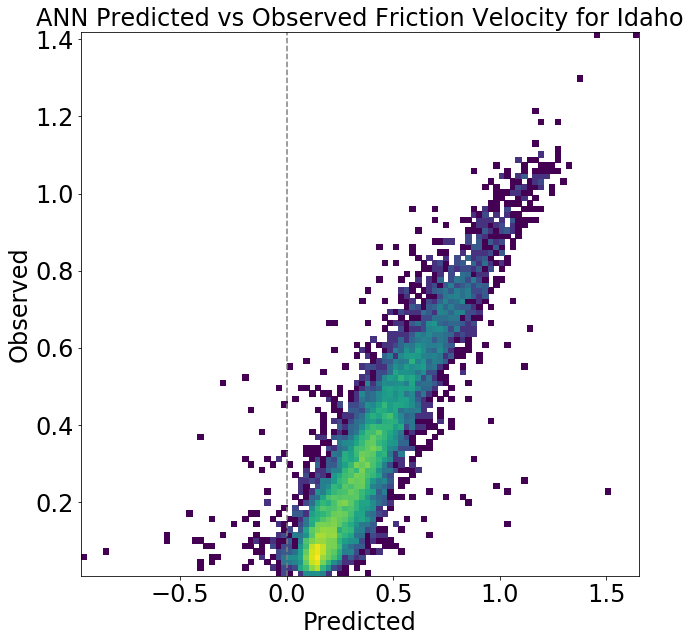

In [401]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.8352667468016726


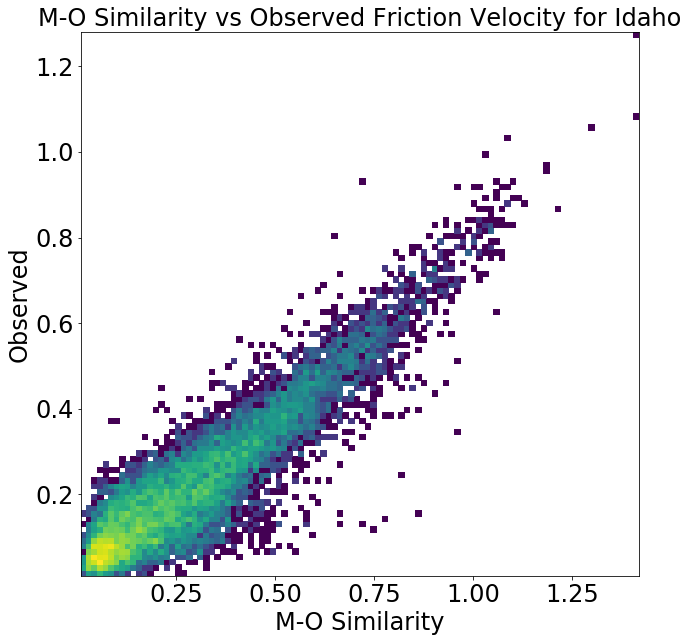

MAE for MO Similarity on Friction Velocity...
0.0905073390109177


In [402]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_ustar_in)
y = np.array(ustar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_friction-velocity_idaho.png')
plt.show()

print("MAE for MO Similarity on Friction Velocity...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

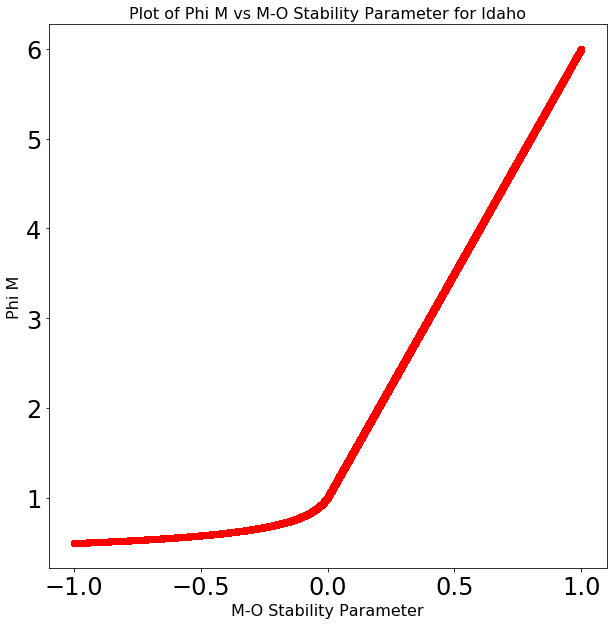

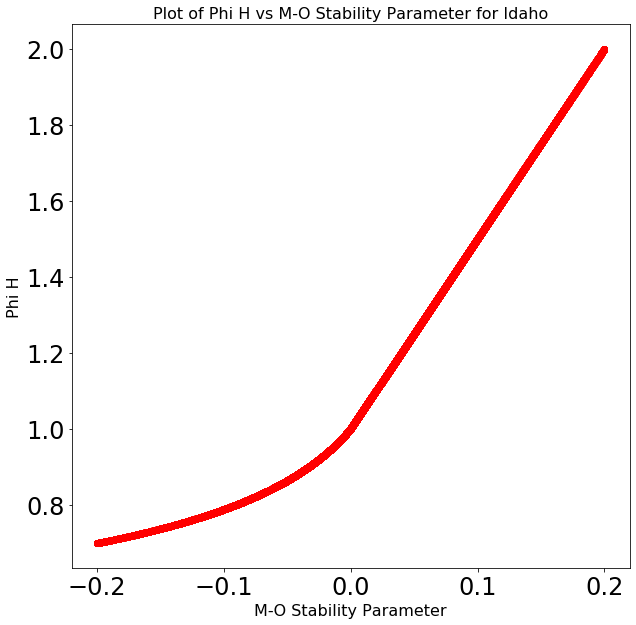

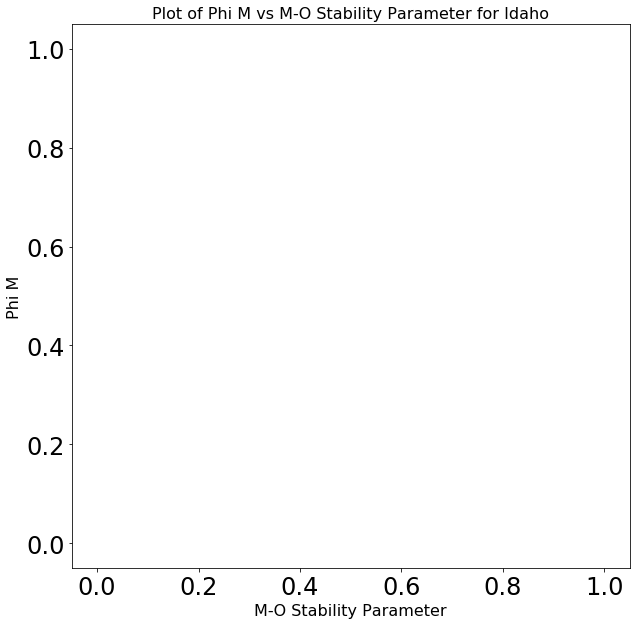

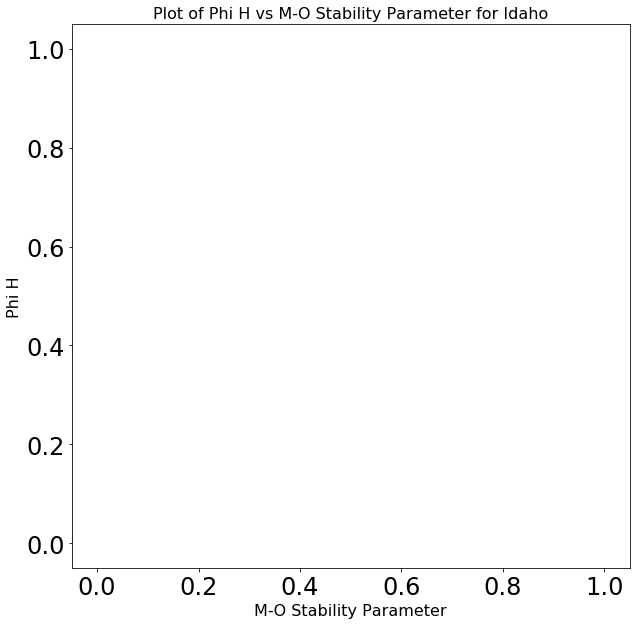

In [403]:
# Test the MO Similarity on the test dataset for the RF Predictions #
#--- Inputs
# Wind velocity at 10 m
u10 = datasetTestC['10m U-Wind m/s']
v10 = datasetTestC['10m V-Wind m/s']

# Skin temperature and temperature at 2 m
tsk = datasetTestC['2m Temp K']
t2  = datasetTestC['10m Temp K'] 
#
# Ground mixing ratio and mixing ratio at 2 m
#qsfc, vap_pressure, sat_vap_pressure = mixing_ratio(datasetTestC['2m Temp K']-273.15, 
#                    datasetTestC['2m RH %'], datasetTestC['2m Pressure hPa'])
q2, vap_pressure, sat_vap_pressure    = mixing_ratio(datasetTestC['10m Temp K']-273.15, 
                    datasetTestC['2m RH %'], datasetTestC['2m Pressure hPa'])

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

qsfc = saturation_mixing_ratio(datasetTestC['2m Temp K'], datasetTestC['2m Pressure hPa'])

qsfc = qsfc / 1000
q2 = q2 /1000
#
# Surface pressure 
psfc = datasetTestC['2m Pressure hPa']
#
# Momentum roughness length, heat flux roughness and reference level
z0=0.01 # might want to go back to 0.1 
zt0=0.001 
z10=10.0 
z2=2.0

# Outside the range of M-O Similarity Theory
phim=[]
zolm=[]
phih=[]
zolh=[]
t_2_out=[]
t_sk_out=[]
ustar_out=[]
tstar_out=[]
pred_ustar_out = []
pred_tstar_out = []
actual_ustar_out = []
actual_tstar_out = []
qstar_out = []

# Within the range of M-O Similarity Theory
phimO=[]
zolmO=[]
phihO=[]
zolhO=[]
t_2_in=[]
t_sk_in=[]
ustar_in=[]
tstar_in=[]
pred_ustar_in = []
pred_tstar_in = []
pred_qstar_in = []
actual_ustar_in = []
actual_tstar_in = []
actual_qstar_in = []
qstar_in = []

#ustar,tstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10,v10,tsk,t2,qsfc,q2,psfc,z0,zt0)
#
for i, val in enumerate(u10):
    ustar,tstar,qstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10.iloc[i],v10.iloc[i],tsk.iloc[i],t2.iloc[i],qsfc.iloc[i],q2.iloc[i],psfc.iloc[i],mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0)
    if ((zeta10 < -2.) | (zeta10 > 1.)):
        phimO.append(phim10)
        zolmO.append(zeta10)
        phihO.append(phih2)
        zolhO.append(zeta2)
        t_2_out.append(t2.iloc[i])
        t_sk_out.append(tsk.iloc[i])
        ustar_out.append(ustar)
        tstar_out.append(tstar)
        qstar_out.append(qstar)
        pred_ustar_out.append(predictionsFC[i])
        pred_tstar_out.append(predictionsTC[i])
        pred_qstar_out.append(predictionsMC[i])
        actual_ustar_out.append(test_labelsFC.iloc[i])
        actual_tstar_out.append(test_labelsTC.iloc[i])
        actual_qstar_out.append(test_labelsMC.iloc[i])
        
    else:
        phim.append(phim10)
        zolm.append(zeta10)
        phih.append(phih2)
        zolh.append(zeta2)
        t_2_in.append(t2.iloc[i])
        t_sk_in.append(tsk.iloc[i])
        ustar_in.append(ustar)
        tstar_in.append(tstar)
        qstar_in.append(qstar)
        pred_ustar_in.append(predictionsFC[i])
        pred_tstar_in.append(predictionsTC[i])
        pred_qstar_in.append(predictionsMC[i])
        actual_ustar_in.append(test_labelsFC.iloc[i])
        actual_tstar_in.append(test_labelsTC.iloc[i])
        actual_qstar_in.append(test_labelsMC.iloc[i])
#
p=plt.plot(zolm,phim,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolh,phih,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()
p=plt.plot(zolmO,phimO,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolhO,phihO,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()

(array([4.1980e+03, 3.6530e+04, 8.7662e+04, 6.6172e+04, 4.0417e+04,
        1.4140e+04, 2.3530e+03, 3.1200e+02, 1.7000e+01, 4.0000e+00]),
 array([2.62334400e-05, 2.24406489e-03, 4.46189634e-03, 6.67972780e-03,
        8.89755925e-03, 1.11153907e-02, 1.33332222e-02, 1.55510536e-02,
        1.77688851e-02, 1.99867165e-02, 2.22045480e-02]),
 <a list of 10 Patch objects>)

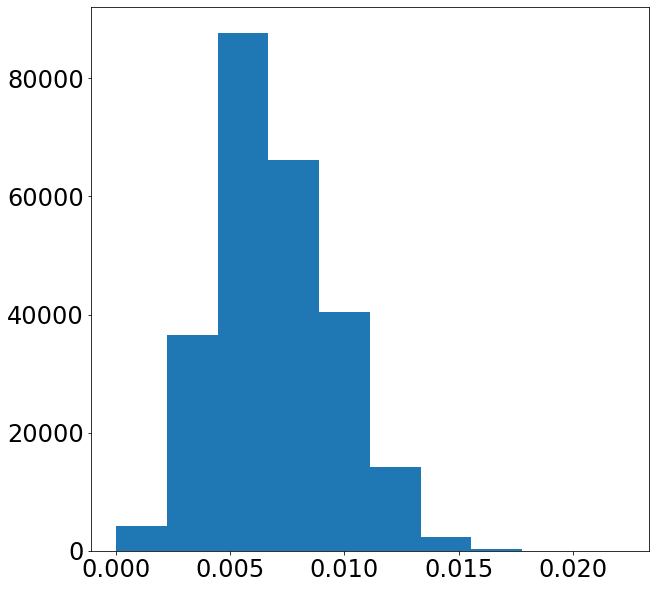

In [404]:
plt.hist(q2)

(array([2.0929e+04, 9.9592e+04, 7.3755e+04, 3.8879e+04, 1.2460e+04,
        4.1670e+03, 1.3510e+03, 3.8700e+02, 2.2100e+02, 6.4000e+01]),
 array([0.00078271, 0.00426558, 0.00774845, 0.01123133, 0.0147142 ,
        0.01819707, 0.02167994, 0.02516281, 0.02864568, 0.03212856,
        0.03561143]),
 <a list of 10 Patch objects>)

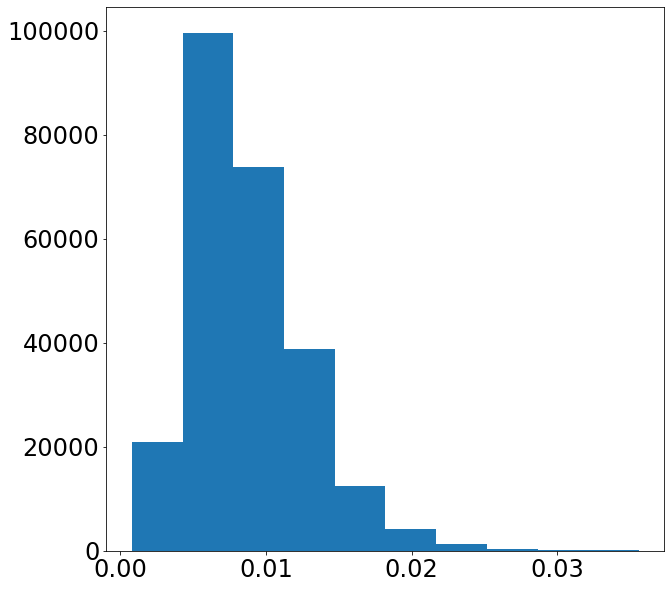

In [405]:
plt.hist(qsfc)

(array([1.7794e+04, 9.4931e+04, 7.3560e+04, 4.3737e+04, 1.4542e+04,
        4.8170e+03, 1.6510e+03, 4.3400e+02, 2.6800e+02, 7.1000e+01]),
 array([ 1.30895084,  6.64476984, 11.98058885, 17.31640786, 22.65222686,
        27.98804587, 33.32386488, 38.65968388, 43.99550289, 49.3313219 ,
        54.6671409 ]),
 <a list of 10 Patch objects>)

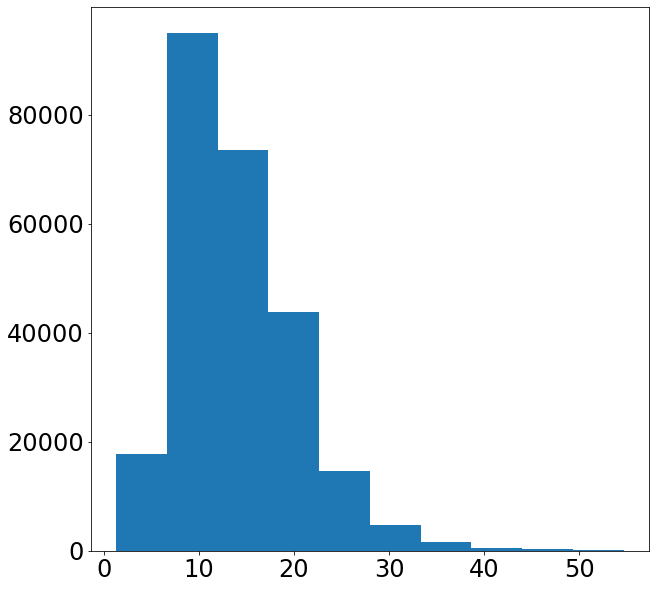

In [406]:
svp2m = saturation_vapor_pressure(tsk)
plt.hist(svp2m)

(array([16816., 87651., 72714., 49281., 16916.,  5524.,  1962.,   548.,
          289.,   104.]),
 array([ 1.87325896,  6.74436456, 11.61547016, 16.48657576, 21.35768136,
        26.22878696, 31.09989256, 35.97099816, 40.84210376, 45.71320936,
        50.58431496]),
 <a list of 10 Patch objects>)

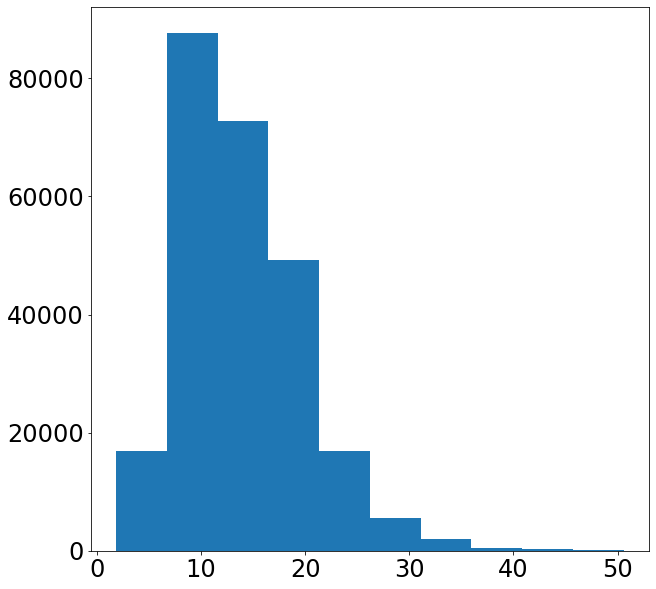

In [407]:
plt.hist(sat_vap_pressure)

The R^2 value is... 0.8214520565975113


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


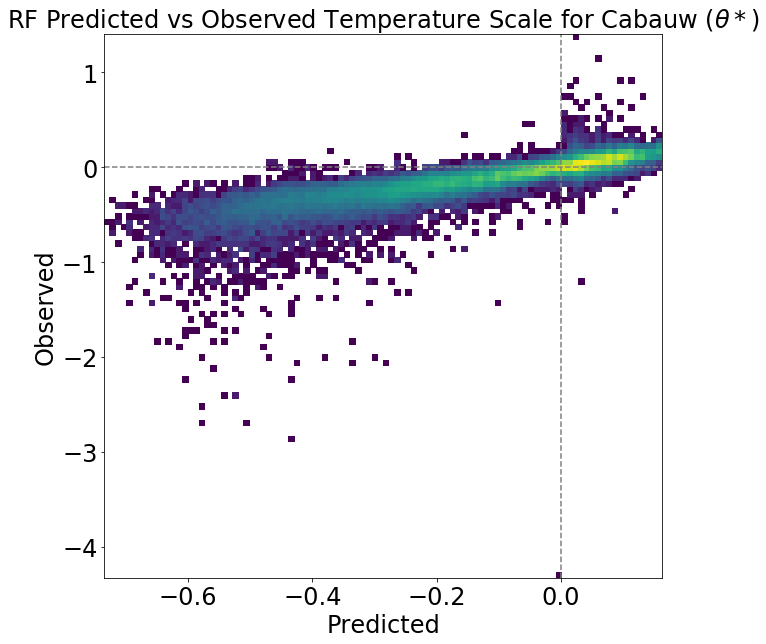

In [408]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTC
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Observed_tscale_cabauw.png')
plt.show()

The R^2 value is... 0.8133425330072132


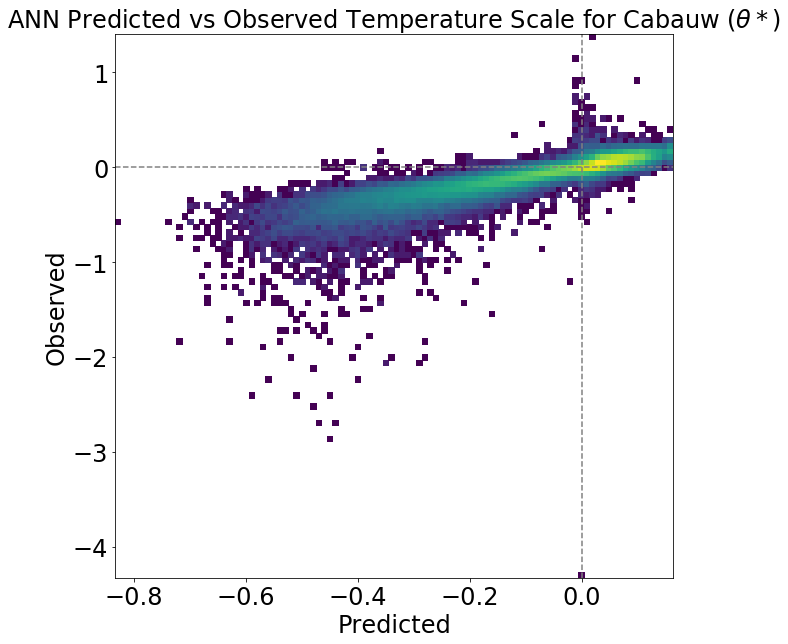

In [409]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTC
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Observed_tscale_cabauw.png')
plt.show()

The R^2 value is... 0.33536794699167227


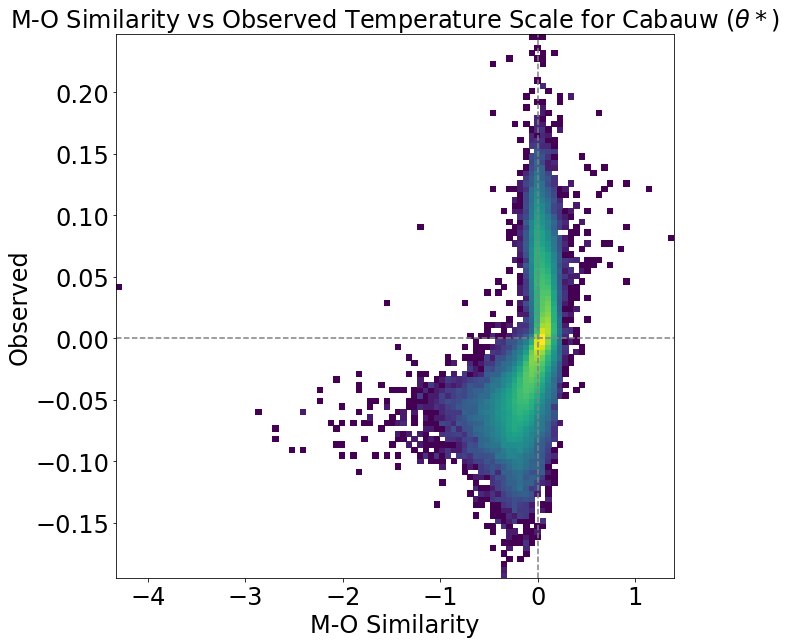

MAE for MO Similarity on T-Scale...
0.07216939656535057


In [410]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_tstar_in)
y = np.array(tstar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_tscale_cabauw.png')
plt.show()

print("MAE for MO Similarity on T-Scale...")
errorsMO_T_C = abs(x - y)
print(np.mean(errorsMO_T_C))

The R^2 value is... 0.7294804463089447


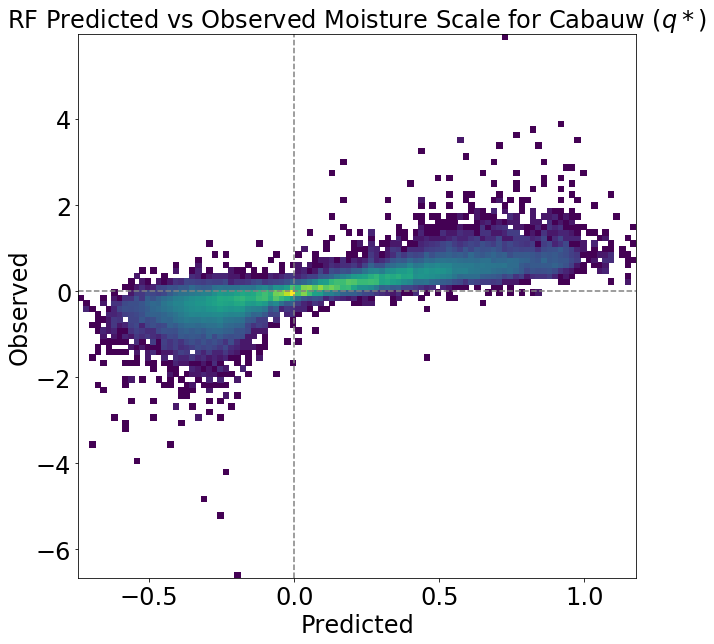

In [411]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMC
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.7191391783012213


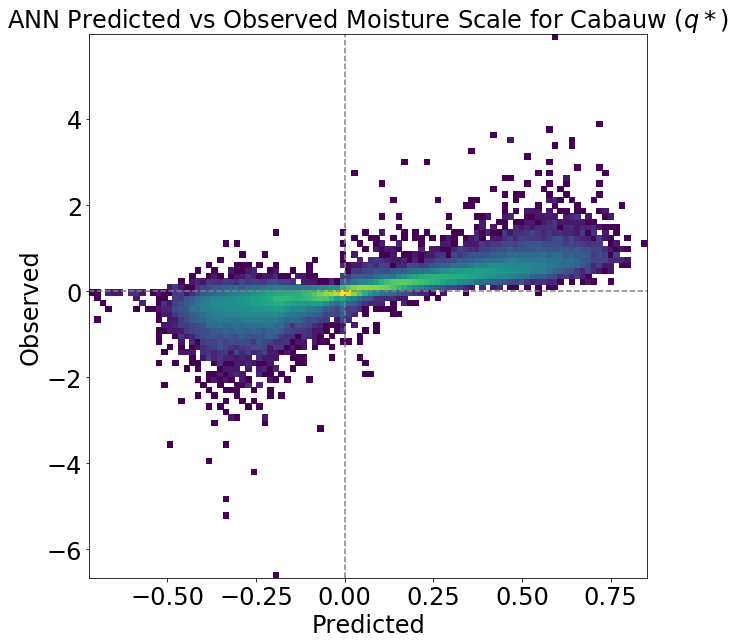

In [412]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMC
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.34068872973947245


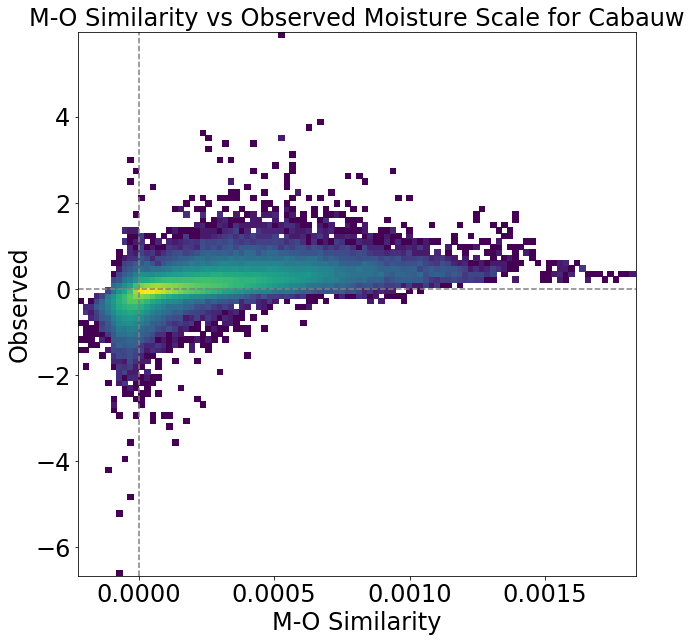

MAE for MO Similarity on Moisture Scale...
0.13400556220761356


In [413]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]

x = np.array(qstar_in)
y = np.array(actual_qstar_in) 

y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Moisture Scale for Cabauw', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_mscale_cabauw.png')
plt.show()

print("MAE for MO Similarity on Moisture Scale...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

The R^2 value is... 0.9301292729451742


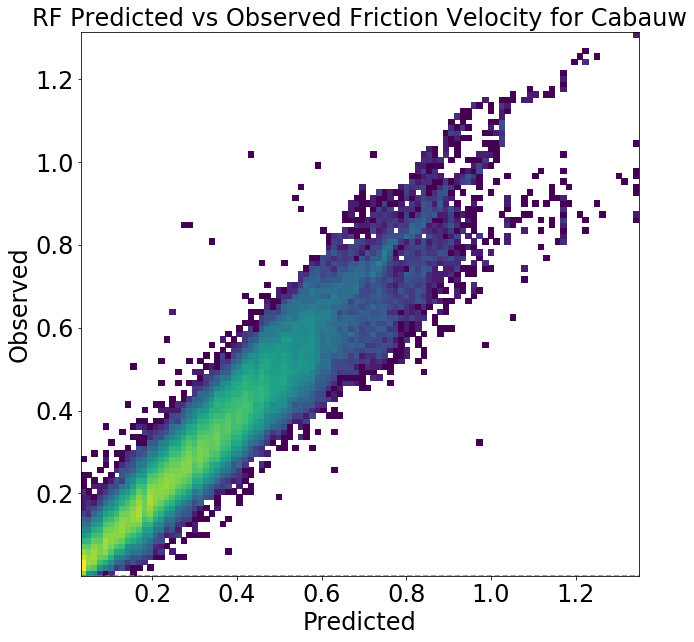

In [414]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFC
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_friction-velocity_cabauw.png')
plt.show()

The R^2 value is... 0.9332584126131479


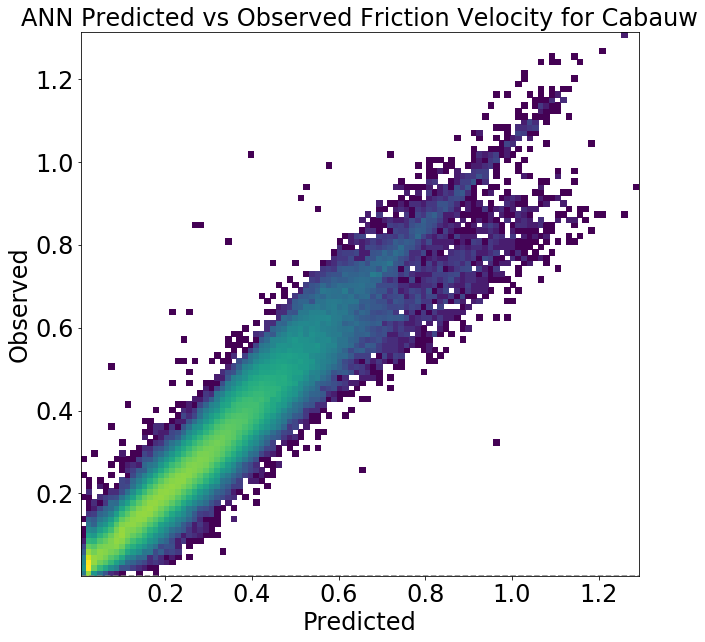

In [415]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFC
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_friction-velocity_cabauw.png')
plt.show()

The R^2 value is... 0.8924903359154351


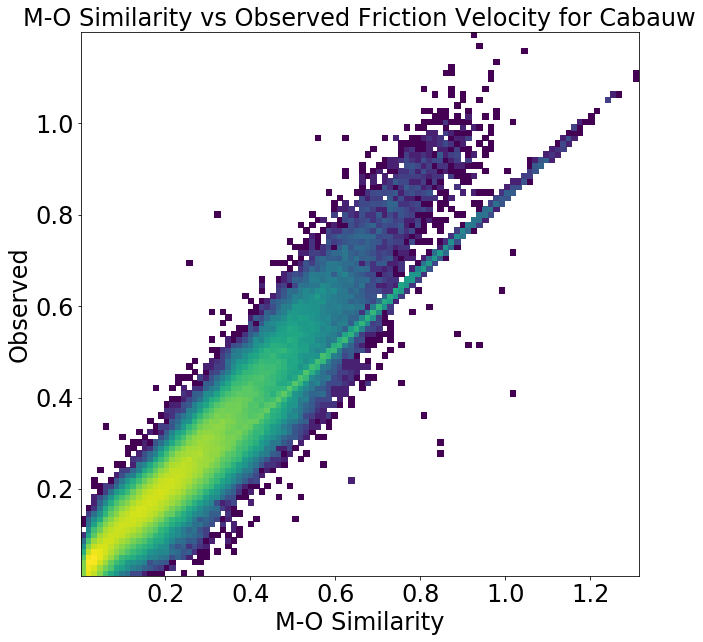

MAE for MO Similarity on Friction Velocity...
0.03976506941872512


In [416]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_ustar_in)
y = np.array(ustar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_friction-velocity_cabauw.png')
plt.show()

print("MAE for MO Similarity on Friction Velocity...")
errorsMO_FV_C = abs(x - y)
print(np.mean(errorsMO_FV_C))


In [417]:
# Use the forest's predict method on the test data
predictionsMI_C = rfM.predict(test_featuresMC.iloc[:,0:16])
predictionsTI_C = rfT.predict(test_featuresTC.iloc[:,0:16])
predictionsFI_C = rfF.predict(test_featuresFC.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMI_C = abs(predictionsMI_C - test_labelsMC)
errorsTI_C = abs(predictionsTI_C - test_labelsTC)
errorsFI_C = abs(predictionsFI_C - test_labelsFC)
# Print out the mean absolute error (mae)
print('Results below for RF trained on Idaho and applied to Cabauw')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMI_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTI_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFI_C), 4))


Results below for RF trained on Idaho and applied to Cabauw
Mean Absolute Error for predicting Moisture Scale: 0.1122
Mean Absolute Error for predicting Temperature Scale: 0.0487
Mean Absolute Error for predicting Friction Velocity: 0.073


In [418]:
# Use the forest's predict method on the test data
ANNpredictionsMI_C = ANN_M.predict(np.asarray(test_featuresMC.iloc[:,0:16]))
ANNpredictionsTI_C = ANN_T.predict(np.asarray(test_featuresTC.iloc[:,0:16]))
ANNpredictionsFI_C = ANN_F.predict(np.asarray(test_featuresFC.iloc[:,0:16]))


ANNpredictionsMI_C = ANNpredictionsMI_C.reshape(len(ANNpredictionsMI_C,))
ANNpredictionsTI_C = ANNpredictionsTI_C.reshape(len(ANNpredictionsTI_C,))
ANNpredictionsFI_C = ANNpredictionsFI_C.reshape(len(ANNpredictionsFI_C,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMI_C = abs(ANNpredictionsMI_C - test_labelsMC)
ANNerrorsTI_C = abs(ANNpredictionsTI_C - test_labelsTC)
ANNerrorsFI_C = abs(ANNpredictionsFI_C - test_labelsFC)
# Print out the mean absolute error (mae)
print('Results below for ANN trained on Idaho and applied to Cabauw')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMI_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTI_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFI_C), 4))

Results below for ANN trained on Idaho and applied to Cabauw
Mean Absolute Error for predicting Moisture Scale: 0.6584
Mean Absolute Error for predicting Temperature Scale: 1.0757
Mean Absolute Error for predicting Friction Velocity: 3.3626


In [468]:
print(np.median(ANNerrorsTI_C))

0.4370791227010669


The R^2 value is... 0.7701536211754917


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


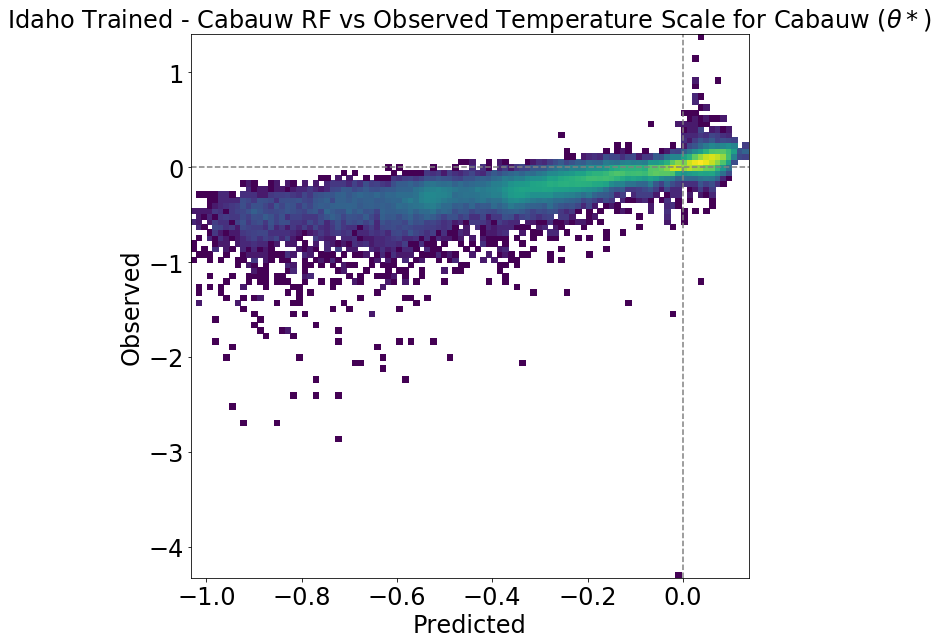

In [419]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTI_C
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_tscale_cabauw.png')
plt.show()

The R^2 value is... 0.6201385219212413


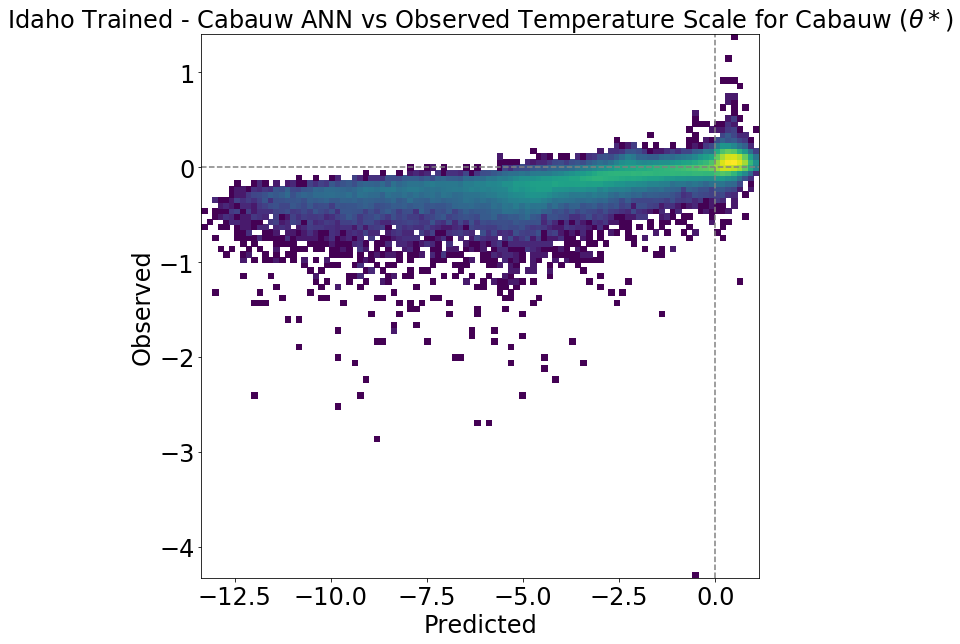

In [420]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTI_C
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Idaho-on-Cabauw_Observed_tscale_cabauw.png')
plt.show()

The R^2 value is... 0.4921762504750218


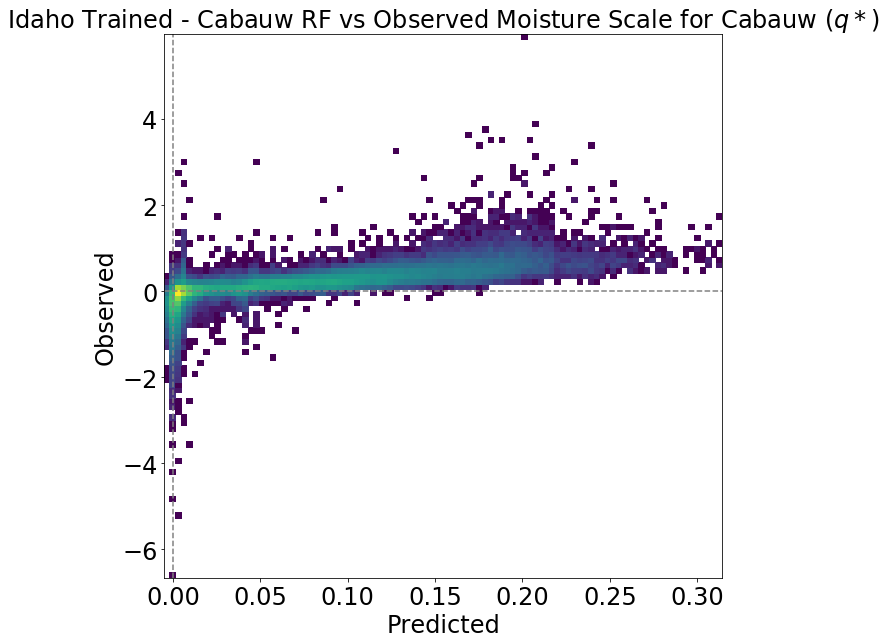

In [421]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMI_C
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.07439238987989465


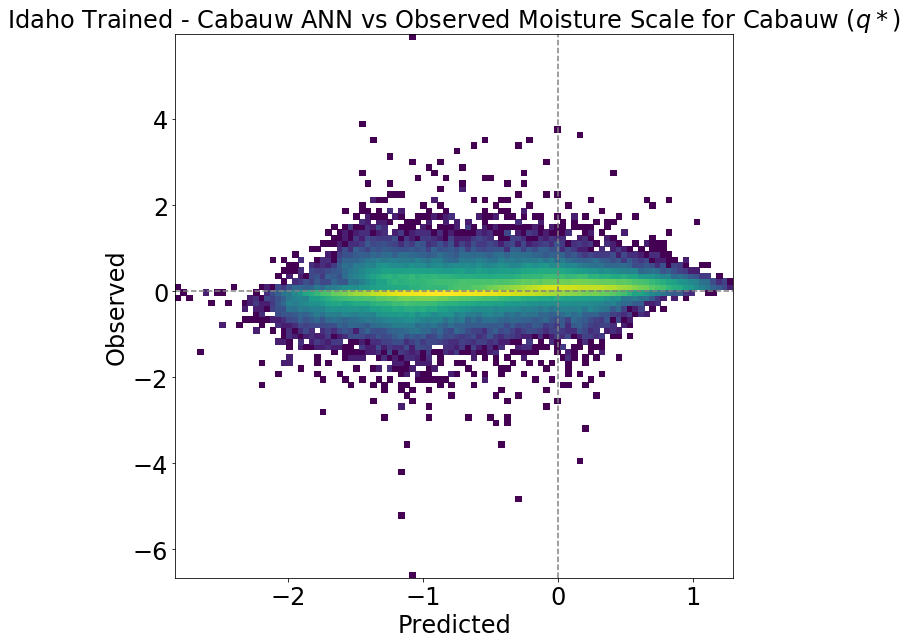

In [422]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMI_C
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
plt.savefig('ANN_Idaho-on-Cabauw_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.9048183383234842


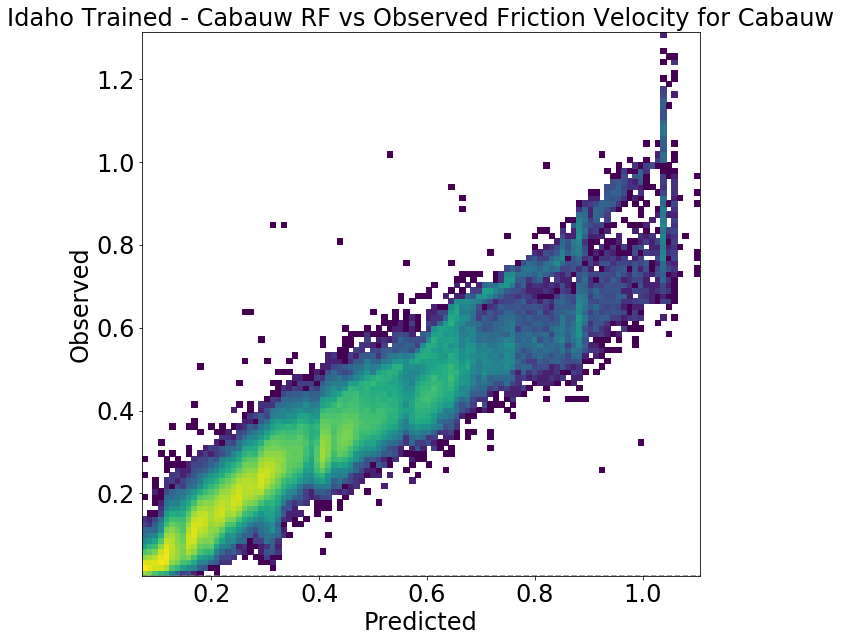

In [423]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFI_C
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_friction-velocity_cabauw.png')
plt.show()

The R^2 value is... 0.00416069602852991


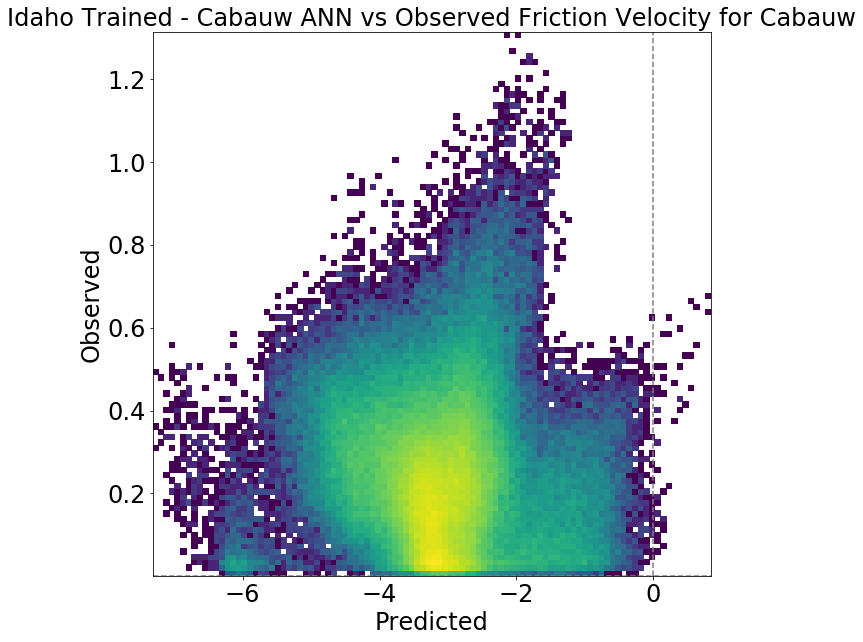

In [424]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFI_C
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Idaho-on-Cabauw_Observed_friction-velocity_cabauw.png')
plt.show()

In [425]:
# Use the forest's predict method on the test data
predictionsMC_I = rfMC.predict(test_featuresM.iloc[:,0:16])
predictionsTC_I = rfTC.predict(test_featuresT.iloc[:,0:16])
predictionsFC_I = rfFC.predict(test_featuresF.iloc[:,0:16])


######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMC_I = abs(predictionsMC_I - test_labelsM)
errorsTC_I = abs(predictionsTC_I - test_labelsT)
errorsFC_I = abs(predictionsFC_I - test_labelsF)
# Print out the mean absolute error (mae)
print('results are for RF Cabauw trained and Idaho predicted:')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMC_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTC_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFC_I), 4))


results are for RF Cabauw trained and Idaho predicted:
Mean Absolute Error for predicting Moisture Scale: 0.2822
Mean Absolute Error for predicting Temperature Scale: 0.1389
Mean Absolute Error for predicting Friction Velocity: 0.0941


In [426]:
# Use the forest's predict method on the test data
ANNpredictionsMC_I = ANN_MC.predict(np.asarray(test_featuresM.iloc[:,0:16]))
ANNpredictionsTC_I = ANN_TC.predict(np.asarray(test_featuresT.iloc[:,0:16]))
ANNpredictionsFC_I = ANN_FC.predict(np.asarray(test_featuresF.iloc[:,0:16]))

ANNpredictionsMC_I = ANNpredictionsMC_I.reshape(len(ANNpredictionsMC_I,))
ANNpredictionsTC_I = ANNpredictionsTC_I.reshape(len(ANNpredictionsTC_I,))
ANNpredictionsFC_I = ANNpredictionsFC_I.reshape(len(ANNpredictionsFC_I,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC_I = abs(ANNpredictionsMC_I - test_labelsM)
ANNerrorsTC_I = abs(ANNpredictionsTC_I - test_labelsT)
ANNerrorsFC_I = abs(ANNpredictionsFC_I - test_labelsF)
# Print out the mean absolute error (mae)
print('results are for ANN Cabauw trained and Idaho predicted:')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC_I), 4))


results are for ANN Cabauw trained and Idaho predicted:
Mean Absolute Error for predicting Moisture Scale: 0.3262
Mean Absolute Error for predicting Temperature Scale: 0.2748
Mean Absolute Error for predicting Friction Velocity: 0.2381


The R^2 value is... 0.7587030335380971


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


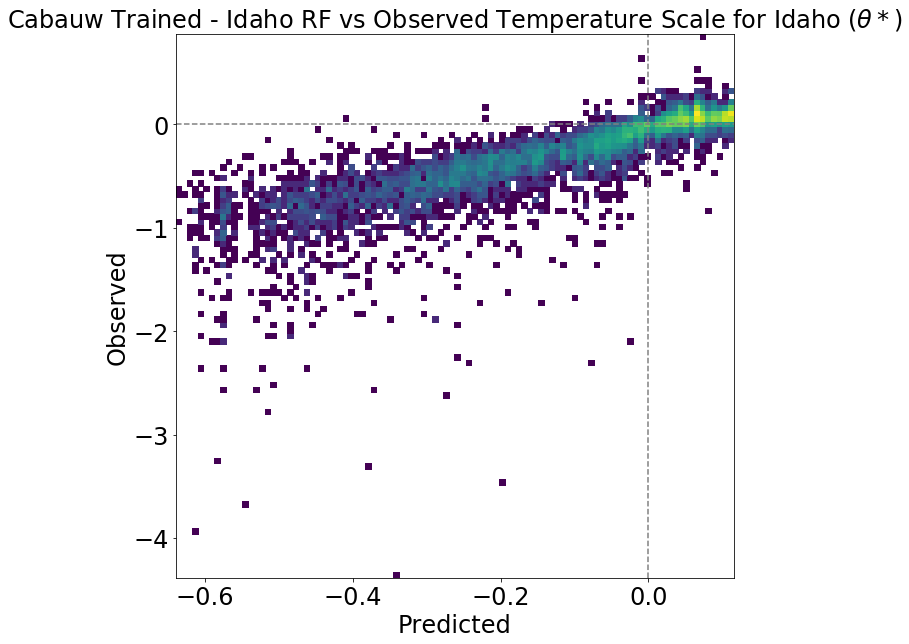

In [427]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTC_I
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.002646127035214109


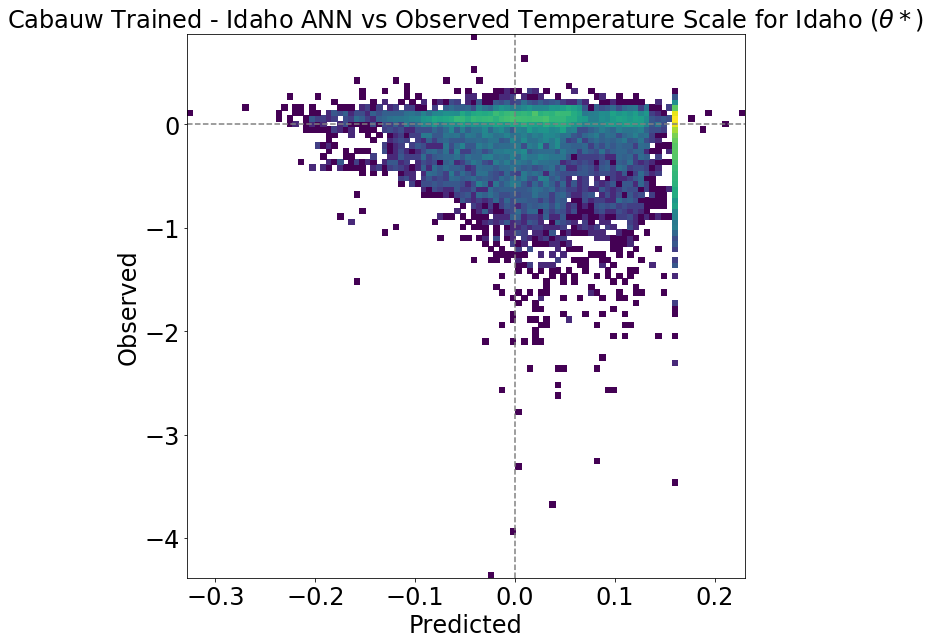

In [428]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTC_I
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.21943504407999243


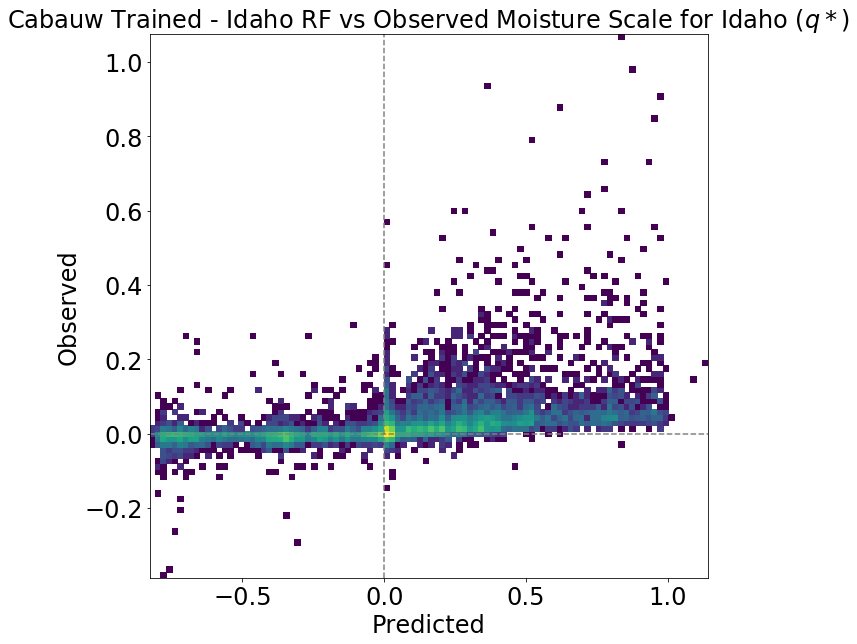

In [429]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMC_I
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.25927427321198787


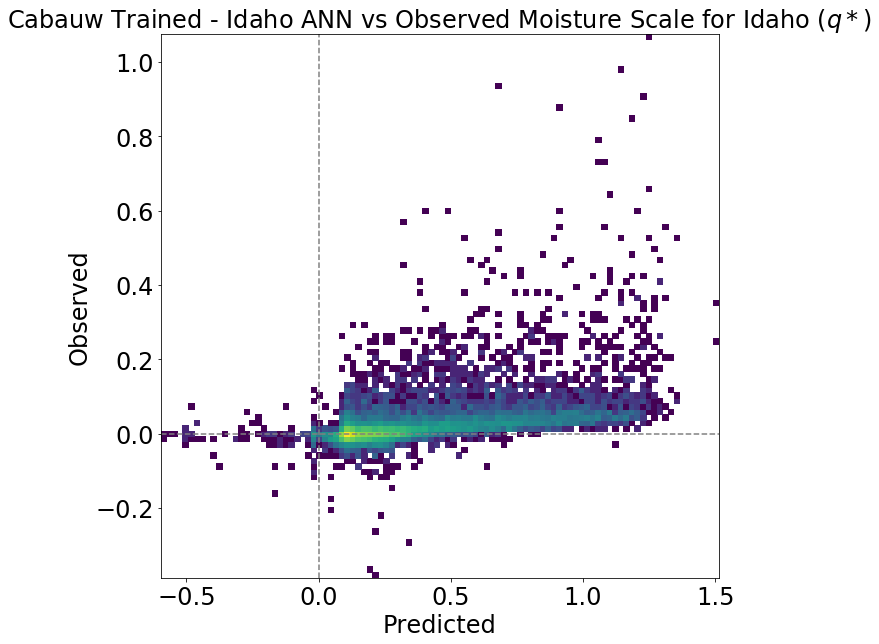

In [430]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMC_I
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.876504269101724


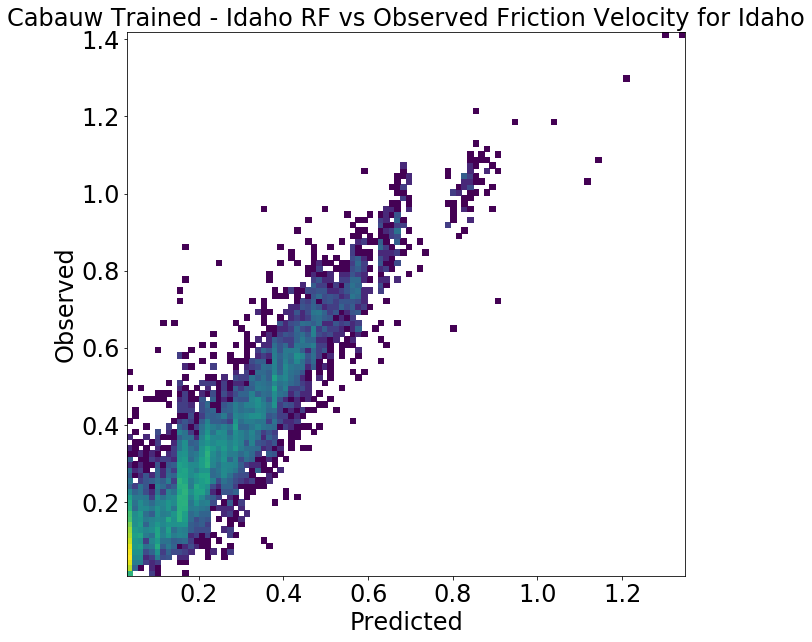

In [431]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFC_I
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.34574859070184316


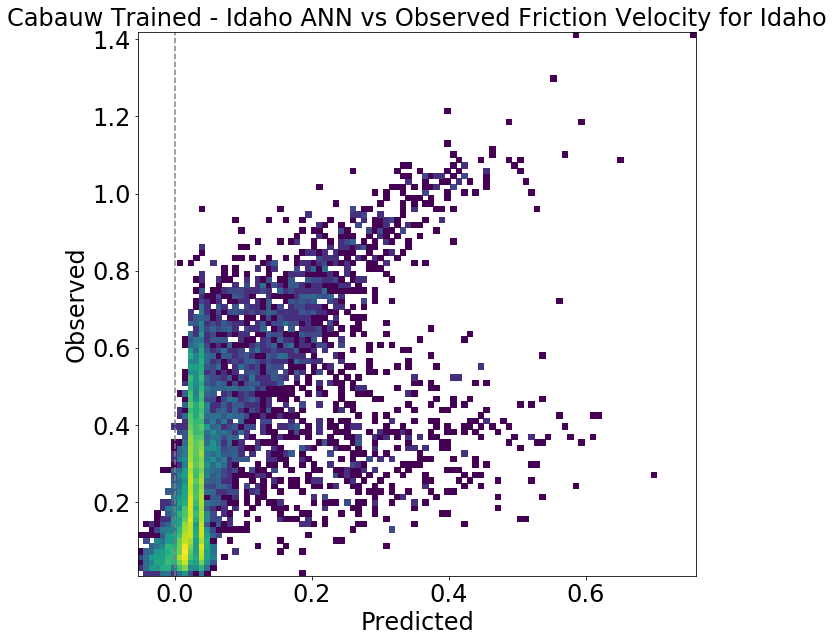

In [432]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFC_I
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_friction-velocity_idaho.png')
plt.show()

In [433]:
## Add training datasets together and predicted on combined test datasets
trainingM = [train_featuresM.iloc[:,0:16],train_featuresMC.iloc[:,0:16]]
trainM = pd.concat(trainingM)
trainingF = [train_featuresF.iloc[:,0:16],train_featuresFC.iloc[:,0:16]]
trainF = pd.concat(trainingF)
trainingT = [train_featuresT.iloc[:,0:16],train_featuresTC.iloc[:,0:16]]
trainT = pd.concat(trainingT)

testingM = [test_featuresM.iloc[:,0:16],test_featuresMC.iloc[:,0:16]]
testM = pd.concat(testingM)
testingF = [test_featuresF.iloc[:,0:16],test_featuresFC.iloc[:,0:16]]
testF = pd.concat(testingF)
testingT = [test_featuresT.iloc[:,0:16],test_featuresTC.iloc[:,0:16]]
testT = pd.concat(testingT)

training_labelsM = [train_labelsM,train_labelsMC]
train_labelsMA = pd.concat(training_labelsM)
training_labelsF = [train_labelsF,train_labelsFC]
train_labelsFA = pd.concat(training_labelsF)
training_labelsT = [train_labelsT,train_labelsTC]
train_labelsTA = pd.concat(training_labelsT)

testing_labelsM = [test_labelsM,test_labelsMC]
test_labelsMA = pd.concat(testing_labelsM)
testing_labelsF = [test_labelsF,test_labelsFC]
test_labelsFA = pd.concat(testing_labelsF)
testing_labelsT = [test_labelsT,test_labelsTC]
test_labelsTA = pd.concat(testing_labelsT)

In [434]:
print(np.shape(train_labelsM))
print(np.shape(train_labelsMC))
print(np.shape(train_featuresM))
print(np.shape(train_featuresMC))

(28918,)
(403140,)
(28918, 16)
(403140, 21)


In [435]:
######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
rfM_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfT_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfF_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
# Train the model on training data
rfM_All.fit(trainM, train_labelsMA)
rfF_All.fit(trainF, train_labelsFA)
rfT_All.fit(trainT, train_labelsTA)

# Use the forest's predict method on the test data
predictionsM_All = rfM_All.predict(testM)
predictionsT_All = rfT_All.predict(testT)
predictionsF_All = rfF_All.predict(testF)

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All = abs(predictionsM_All - test_labelsMA)
errorsT_All = abs(predictionsT_All - test_labelsTA)
errorsF_All = abs(predictionsF_All - test_labelsFA)
# Print out the mean absolute error (mae)
print('MAES for RF trained on all')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All), 4))

MAES for RF trained on all
Mean Absolute Error for predicting Moisture Scale: 0.054
Mean Absolute Error for predicting Temperature Scale: 0.0331
Mean Absolute Error for predicting Friction Velocity: 0.0328


In [436]:
print(np.shape(ANNpredictionsMC_All))
print(np.shape(testM))

(263575,)
(263575, 16)


In [437]:
ANN_MC_All = build_model(np.asarray(trainM))
ANN_TC_All = build_model(np.asarray(trainT))
ANN_FC_All = build_model(np.asarray(trainF))

# Train the model on training data
historyMC_All = ANN_MC_All.fit(np.asarray(trainM), np.asarray(train_labelsMA), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyFC_All = ANN_FC_All.fit(np.asarray(trainF), np.asarray(train_labelsFA), epochs=EPOCHS, validation_split=0.2,verbose=0)
historyTC_All = ANN_TC_All.fit(np.asarray(trainT), np.asarray(train_labelsTA), epochs=EPOCHS, validation_split=0.2,verbose=0)

# Use the forest's predict method on the test data
ANNpredictionsMC_All = ANN_MC_All.predict(np.asarray(testM))
ANNpredictionsTC_All = ANN_TC_All.predict(np.asarray(testT))
ANNpredictionsFC_All = ANN_FC_All.predict(np.asarray(testF))

ANNpredictionsMC_All = ANNpredictionsMC_All.reshape(len(ANNpredictionsMC_All,))
ANNpredictionsTC_All = ANNpredictionsTC_All.reshape(len(ANNpredictionsTC_All,))
ANNpredictionsFC_All = ANNpredictionsFC_All.reshape(len(ANNpredictionsFC_All,))


In [438]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC_All = abs(ANNpredictionsMC_All - test_labelsMA)
ANNerrorsTC_All = abs(ANNpredictionsTC_All - test_labelsTA)
ANNerrorsFC_All = abs(ANNpredictionsFC_All - test_labelsFA)
# Print out the mean absolute error (mae)
print('MAES for ANNs trained on call')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC_All), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC_All), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC_All), 4))

MAES for ANNs trained on call
Mean Absolute Error for predicting Moisture Scale: 0.0561
Mean Absolute Error for predicting Temperature Scale: 0.0338
Mean Absolute Error for predicting Friction Velocity: 0.034


In [439]:
# Use the RF-All to predict the Idaho and Cabauw Test Datasets
predictionsM_Idaho_All = rfM_All.predict(test_featuresM.iloc[:,0:16])
predictionsT_Idaho_All = rfT_All.predict(test_featuresT.iloc[:,0:16])
predictionsF_Idaho_All = rfF_All.predict(test_featuresF.iloc[:,0:16])

predictionsM_Cabauw_All = rfM_All.predict(test_featuresMC.iloc[:,0:16])
predictionsT_Cabauw_All = rfT_All.predict(test_featuresTC.iloc[:,0:16])
predictionsF_Cabauw_All = rfF_All.predict(test_featuresFC.iloc[:,0:16])

# Use the ANN-All to predict the Idaho and Cabauw Test Datasets
ANNpredictionsM_Idaho_All = ANN_MC_All.predict(np.asarray(test_featuresM.iloc[:,0:16]))
ANNpredictionsT_Idaho_All = ANN_TC_All.predict(np.asarray(test_featuresT.iloc[:,0:16]))
ANNpredictionsF_Idaho_All = ANN_FC_All.predict(np.asarray(test_featuresF.iloc[:,0:16]))

ANNpredictionsM_Idaho_All = ANNpredictionsM_Idaho_All.reshape(len(ANNpredictionsM_Idaho_All,))
ANNpredictionsT_Idaho_All = ANNpredictionsT_Idaho_All.reshape(len(ANNpredictionsT_Idaho_All,))
ANNpredictionsF_Idaho_All = ANNpredictionsF_Idaho_All.reshape(len(ANNpredictionsF_Idaho_All,))

ANNpredictionsM_Cabauw_All = ANN_MC_All.predict(np.asarray(test_featuresMC.iloc[:,0:16]))
ANNpredictionsT_Cabauw_All = ANN_TC_All.predict(np.asarray(test_featuresTC.iloc[:,0:16]))
ANNpredictionsF_Cabauw_All = ANN_FC_All.predict(np.asarray(test_featuresFC.iloc[:,0:16]))

ANNpredictionsM_Cabauw_All = ANNpredictionsM_Cabauw_All.reshape(len(ANNpredictionsM_Cabauw_All,))
ANNpredictionsT_Cabauw_All = ANNpredictionsT_Cabauw_All.reshape(len(ANNpredictionsT_Cabauw_All,))
ANNpredictionsF_Cabauw_All = ANNpredictionsF_Cabauw_All.reshape(len(ANNpredictionsF_Cabauw_All,))

In [440]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All_C = abs(predictionsM_Cabauw_All - test_labelsMC)
errorsT_All_C = abs(predictionsT_Cabauw_All - test_labelsTC)
errorsF_All_C = abs(predictionsF_Cabauw_All - test_labelsFC)
# Print out the mean absolute error (mae)
print('RF for Cabauw trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All_C), 4))

# Calculate the absolute errors
ANNerrorsM_All_C = abs(ANNpredictionsM_Cabauw_All - test_labelsMC)
ANNerrorsT_All_C = abs(ANNpredictionsT_Cabauw_All - test_labelsTC)
ANNerrorsF_All_C = abs(ANNpredictionsF_Cabauw_All - test_labelsFC)
# Print out the mean absolute error (mae)
print('ANN for Cabauw trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM_All_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT_All_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF_All_C), 4))

RF for Cabauw trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0552
Mean Absolute Error for predicting Temperature Scale: 0.0308
Mean Absolute Error for predicting Friction Velocity: 0.032
ANN for Cabauw trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0573
Mean Absolute Error for predicting Temperature Scale: 0.0313
Mean Absolute Error for predicting Friction Velocity: 0.0331


In [441]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All_I = abs(predictionsM_Idaho_All - test_labelsM)
errorsT_All_I = abs(predictionsT_Idaho_All - test_labelsT)
errorsF_All_I = abs(predictionsF_Idaho_All - test_labelsF)
# Print out the mean absolute error (mae)
print('RF for Idaho trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All_I), 4))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsM_All_I = abs(ANNpredictionsM_Idaho_All - test_labelsM)
ANNerrorsT_All_I = abs(ANNpredictionsT_Idaho_All - test_labelsT)
ANNerrorsF_All_I = abs(ANNpredictionsF_Idaho_All - test_labelsF)
# Print out the mean absolute error (mae)
print('ANN for Idaho trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM_All_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT_All_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF_All_I), 4))

RF for Idaho trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0294
Mean Absolute Error for predicting Temperature Scale: 0.0826
Mean Absolute Error for predicting Friction Velocity: 0.0518
ANN for Idaho trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0306
Mean Absolute Error for predicting Temperature Scale: 0.087
Mean Absolute Error for predicting Friction Velocity: 0.0531


The R^2 value is... 0.7954570724867629


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


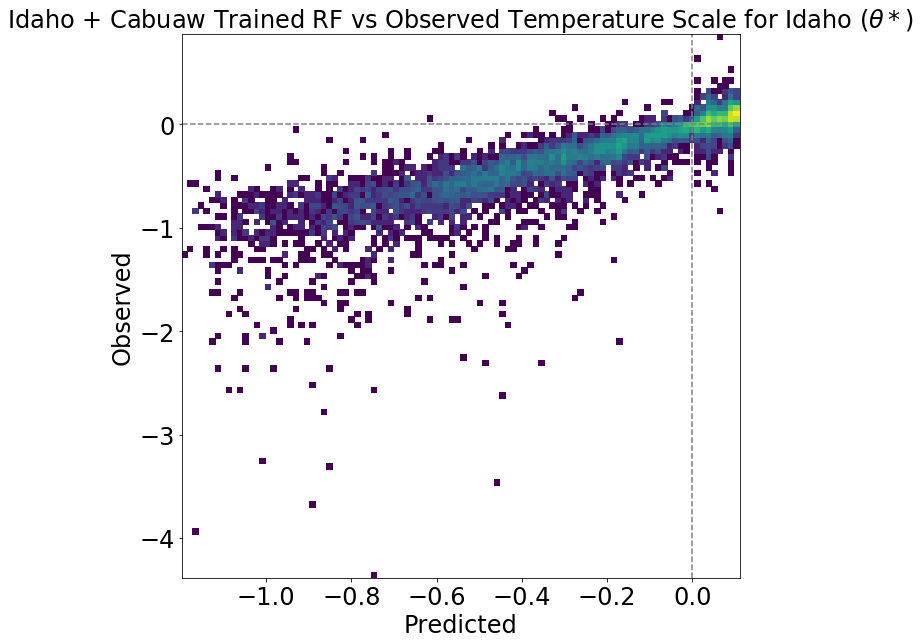

In [442]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT_Idaho_All
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7839440326784866


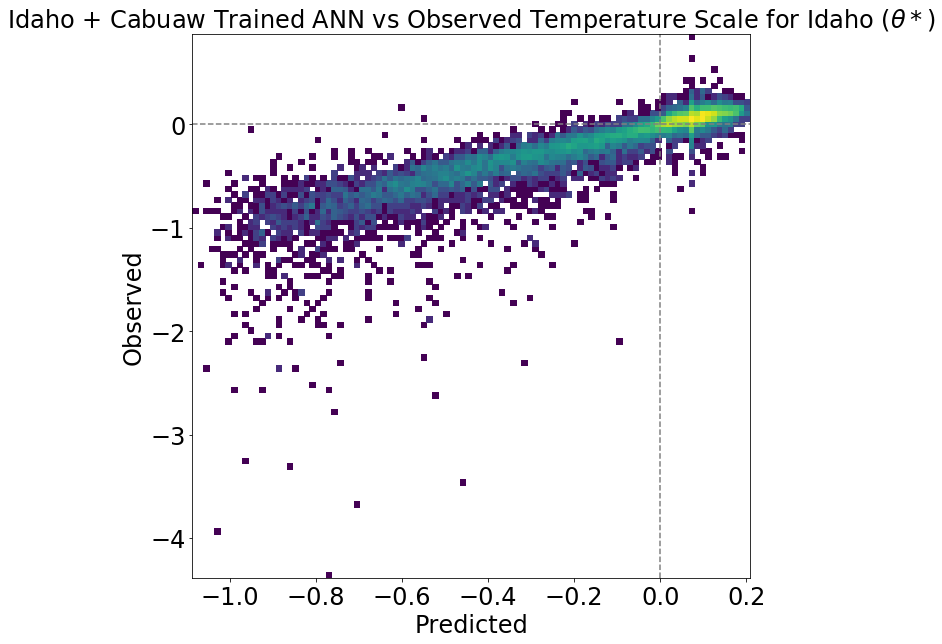

In [443]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT_Idaho_All
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_tscale.png')
plt.show()

The R^2 value is... 0.24516255087555866


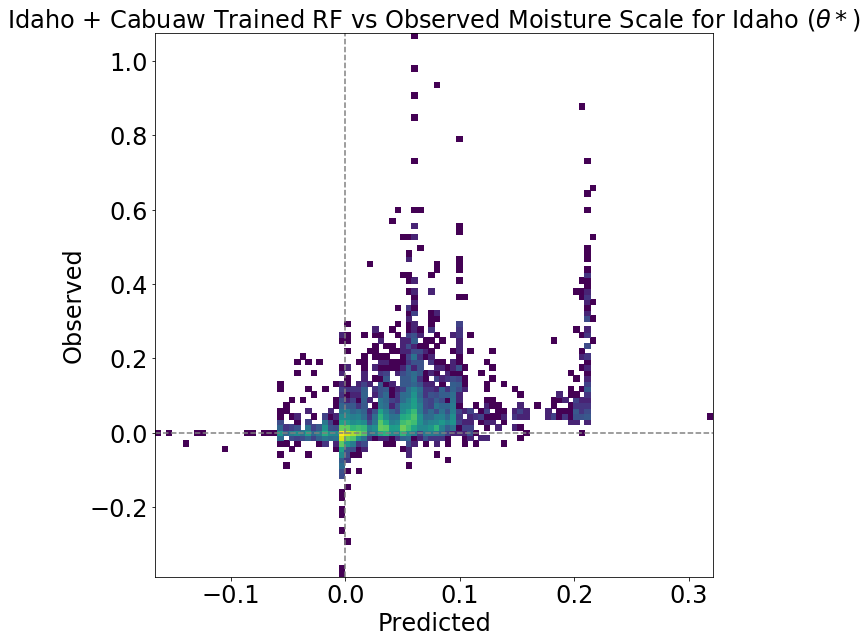

In [444]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM_Idaho_All
y = test_labelsM
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Moisture Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_mscale.png')
plt.show()

The R^2 value is... 0.3154384313058464


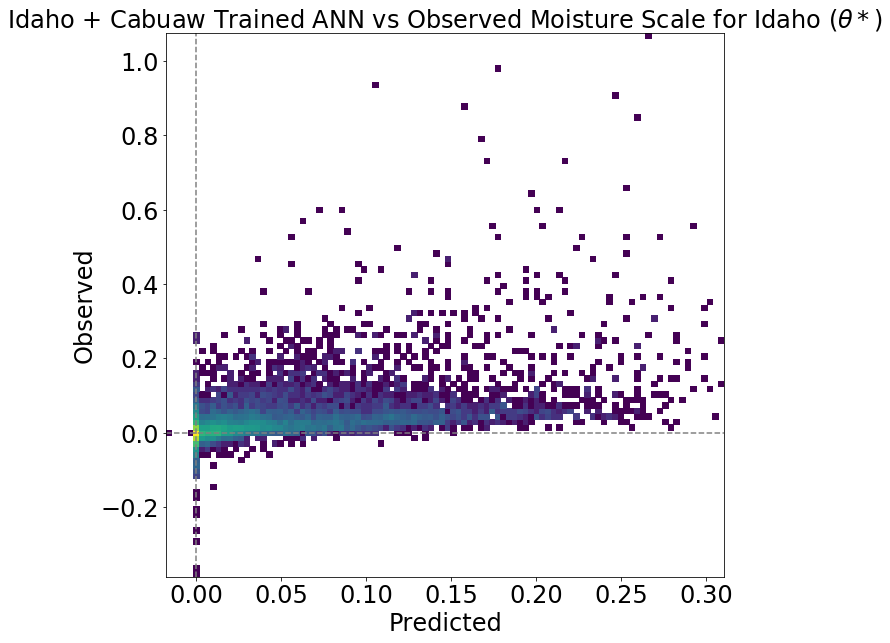

In [445]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM_Idaho_All
y = test_labelsM
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Moisture Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_mscale.png')
plt.show()

The R^2 value is... 0.8887763261130883


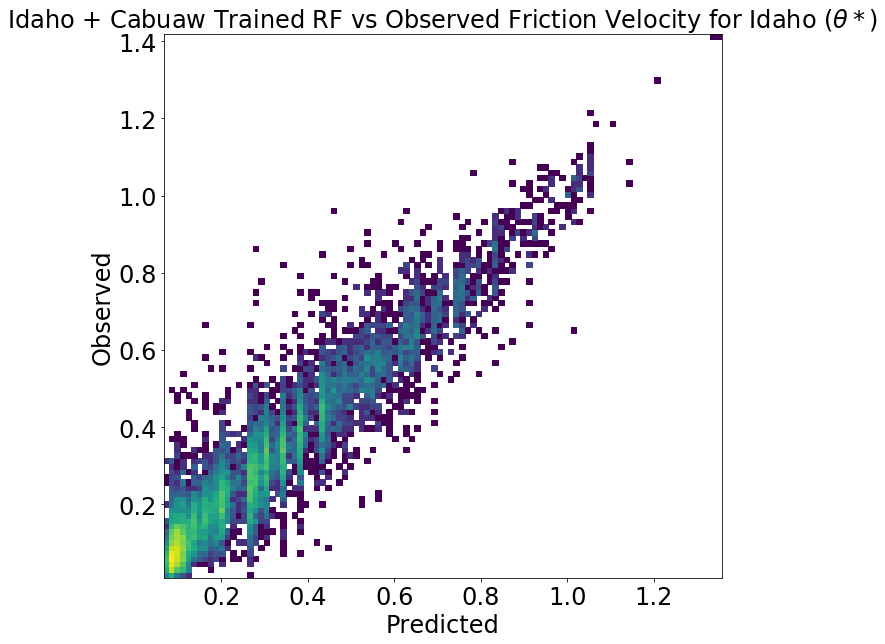

In [446]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF_Idaho_All
y = test_labelsF
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Friction Velocity for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8955673967154788


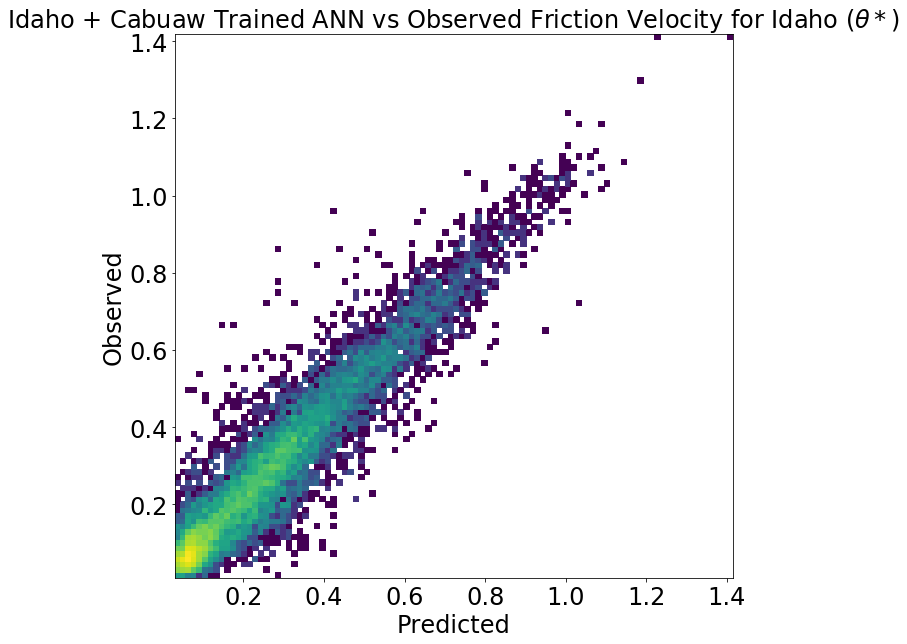

In [447]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF_Idaho_All
y = test_labelsF
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Friction Velocity for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8160811318049878


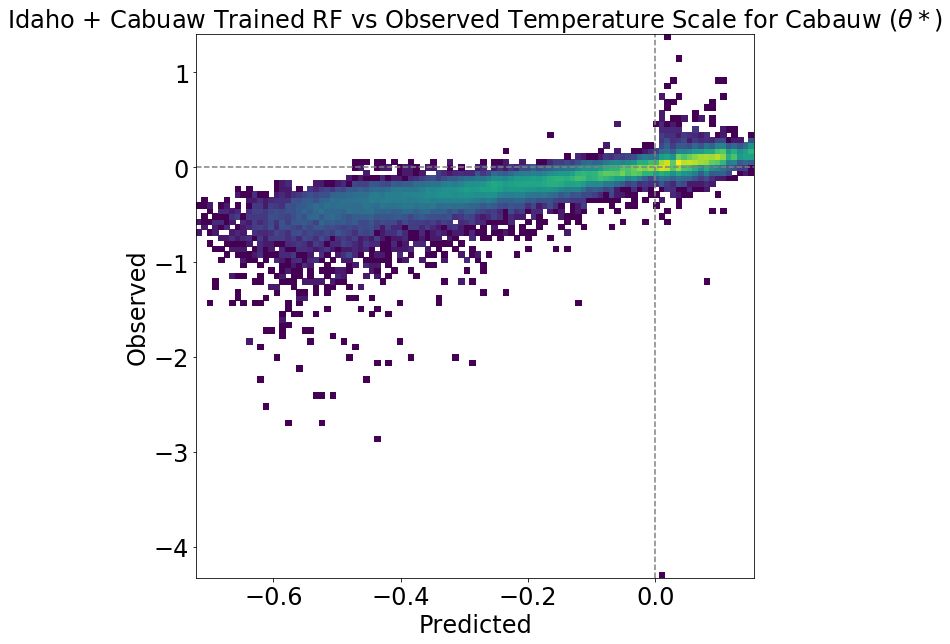

In [448]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT_Cabauw_All
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_tscale.png')
plt.show()

The R^2 value is... 0.8023072221087385


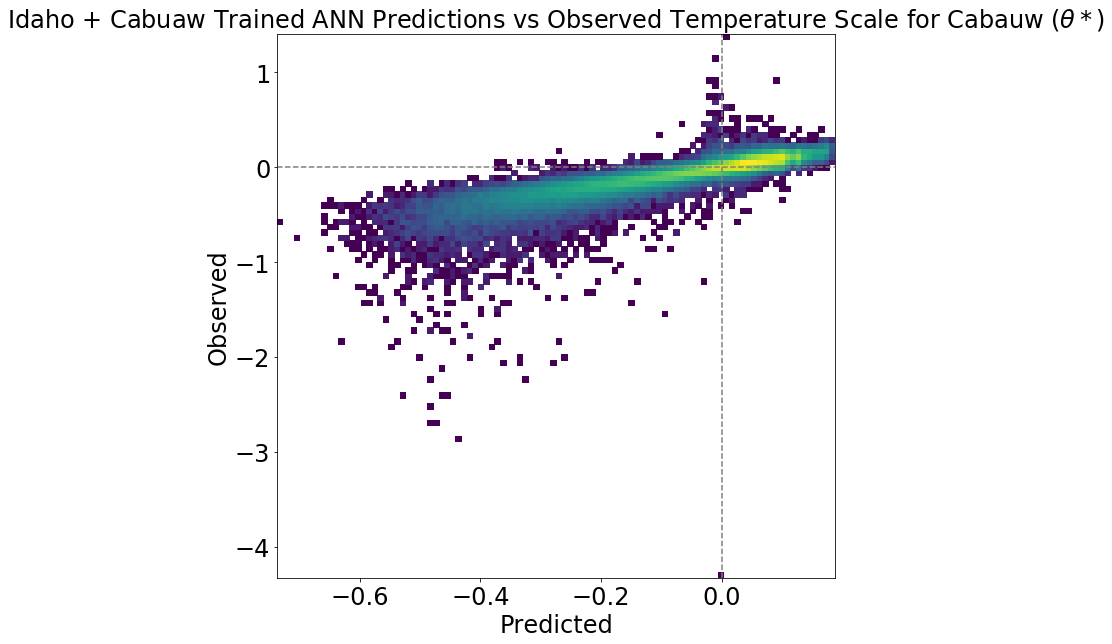

In [449]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT_Cabauw_All
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN Predictions vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7326985692497611


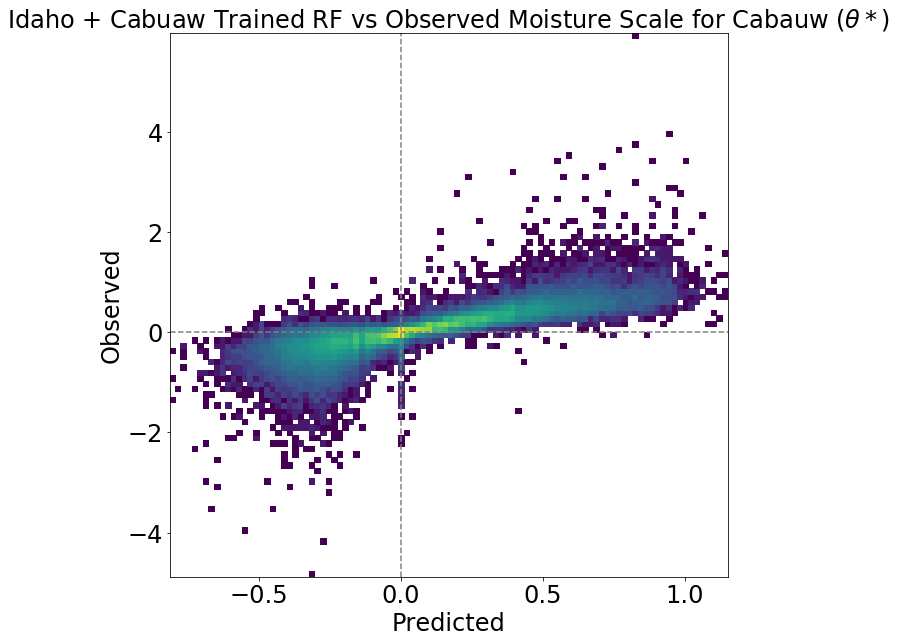

In [450]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM_Cabauw_All
y = test_labelsMC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Moisture Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_mscale.png')
plt.show()

The R^2 value is... 0.7162078476656472


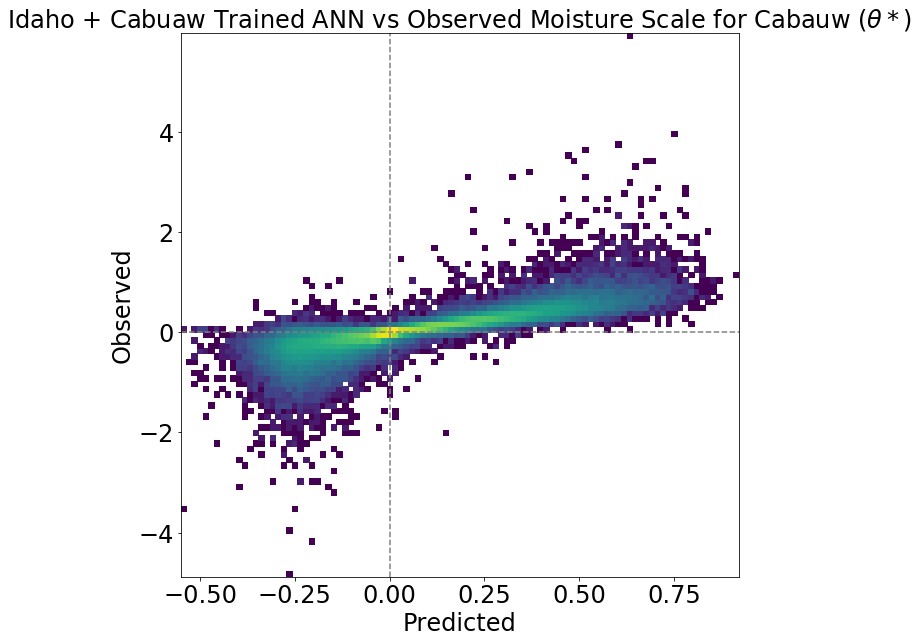

In [451]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM_Cabauw_All
y = test_labelsMC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Moisture Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_mscale.png')
plt.show()

The R^2 value is... 0.9281857312455808


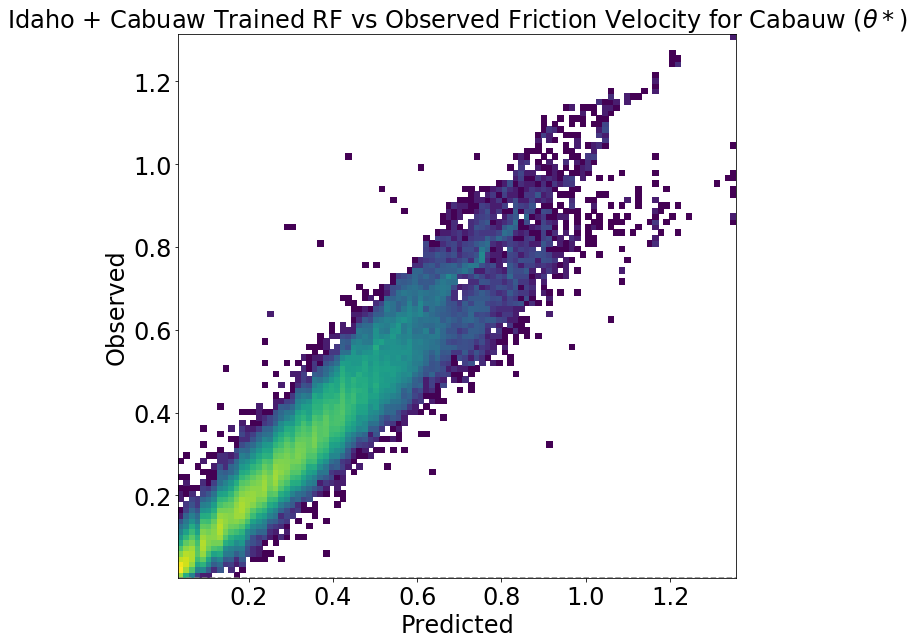

In [452]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF_Cabauw_All
y = test_labelsFC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Friction Velocity for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.9301802884067307


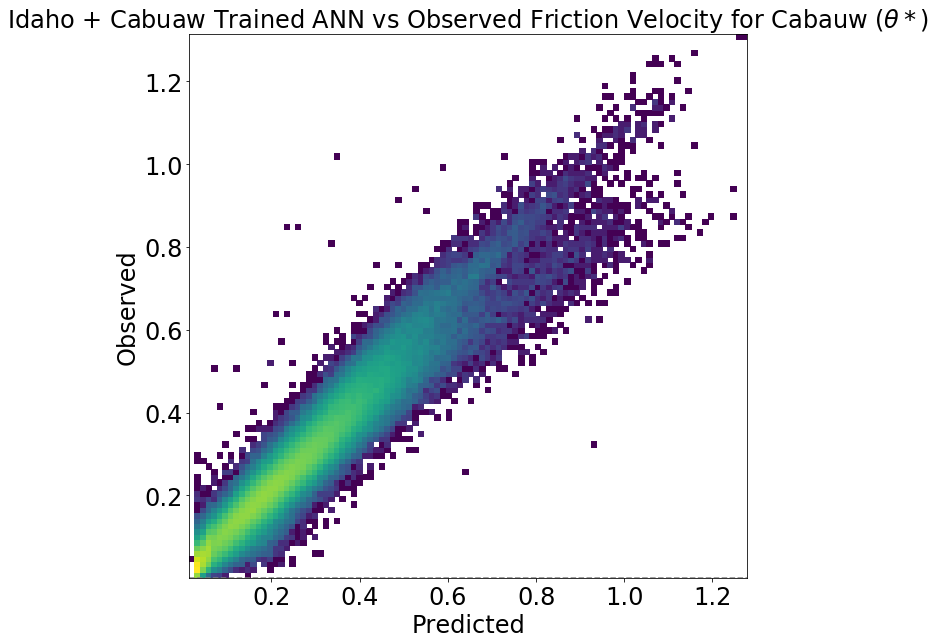

In [453]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF_Cabauw_All
y = test_labelsFC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Friction Velocity for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_friction-velocity.png')
plt.show()

In [454]:
# Split results by Bulk Richardson Number
TestCF = datasetTestC
TestCF['FrictionVelocityTestC'] = FrictionVelocityTestC
TestCM = datasetTestC
TestCM['MoistureScaleTestC'] = MoistureScaleTestC
TestCT = datasetTestC
TestCT['TemperatureScaleTestC'] = TemperatureScaleTestC

test_featuresMC_Neg = TestCM.loc[TestCM['10m Bulk Richardson']<0]
test_labelsMC_Neg = test_featuresMC_Neg['MoistureScaleTestC']
test_featuresMC_Neg = test_featuresMC_Neg.drop(columns=['MoistureScaleTestC'])
test_featuresMC_Pos = TestCM.loc[TestCM['10m Bulk Richardson']>0]
test_labelsMC_Pos = test_featuresMC_Pos['MoistureScaleTestC']
test_featuresMC_Pos = test_featuresMC_Pos.drop(columns=['MoistureScaleTestC'])
predMC_Neg = rfMC.predict(test_featuresMC_Neg.iloc[:,0:16]) 
predMC_Pos = rfMC.predict(test_featuresMC_Pos.iloc[:,0:16])
ANNpredMC_Neg = ANN_MC.predict(np.asarray(test_featuresMC_Neg.iloc[:,0:16])) 
ANNpredMC_Pos = ANN_MC.predict(np.asarray(test_featuresMC_Pos.iloc[:,0:16]))

ANNpredMC_Neg = ANNpredMC_Neg.reshape(len(ANNpredMC_Neg,))
ANNpredMC_Pos = ANNpredMC_Pos.reshape(len(ANNpredMC_Pos,))

test_featuresTC_Neg = TestCT.loc[TestCT['10m Bulk Richardson']<0]
test_labelsTC_Neg = test_featuresTC_Neg['TemperatureScaleTestC']
test_featuresTC_Neg = test_featuresTC_Neg.drop(columns=['TemperatureScaleTestC'])
test_featuresTC_Pos = TestCT.loc[TestCT['10m Bulk Richardson']>0]
test_labelsTC_Pos = test_featuresTC_Pos['TemperatureScaleTestC']
test_featuresTC_Pos = test_featuresTC_Pos.drop(columns=['TemperatureScaleTestC'])
predTC_Neg = rfTC.predict(test_featuresTC_Neg.iloc[:,0:16])  
predTC_Pos = rfTC.predict(test_featuresTC_Pos.iloc[:,0:16]) 
ANNpredTC_Neg = ANN_TC.predict(np.asarray(test_featuresTC_Neg.iloc[:,0:16]))  
ANNpredTC_Pos = ANN_TC.predict(np.asarray(test_featuresTC_Pos.iloc[:,0:16])) 

ANNpredTC_Neg = ANNpredTC_Neg.reshape(len(ANNpredTC_Neg,))
ANNpredTC_Pos = ANNpredTC_Pos.reshape(len(ANNpredTC_Pos,))

test_featuresFC_Neg = TestCF.loc[TestCF['10m Bulk Richardson']<0]
test_labelsFC_Neg = test_featuresFC_Neg['FrictionVelocityTestC']
test_featuresFC_Neg = test_featuresFC_Neg.drop(columns=['FrictionVelocityTestC'])
test_featuresFC_Pos = TestCF.loc[TestCF['10m Bulk Richardson']>0]
test_labelsFC_Pos = test_featuresFC_Pos['FrictionVelocityTestC']
test_featuresFC_Pos = test_featuresFC_Pos.drop(columns=['FrictionVelocityTestC'])
predFC_Neg = rfFC.predict(test_featuresFC_Neg.iloc[:,0:16])  
predFC_Pos = rfFC.predict(test_featuresFC_Pos.iloc[:,0:16])  
ANNpredFC_Neg = ANN_FC.predict(np.asarray(test_featuresFC_Neg.iloc[:,0:16]))  
ANNpredFC_Pos = ANN_FC.predict(np.asarray(test_featuresFC_Pos.iloc[:,0:16]))

ANNpredFC_Neg = ANNpredFC_Neg.reshape(len(ANNpredFC_Neg,))
ANNpredFC_Pos = ANNpredFC_Pos.reshape(len(ANNpredFC_Pos,))

The R^2 value is... 0.9454392203306208


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


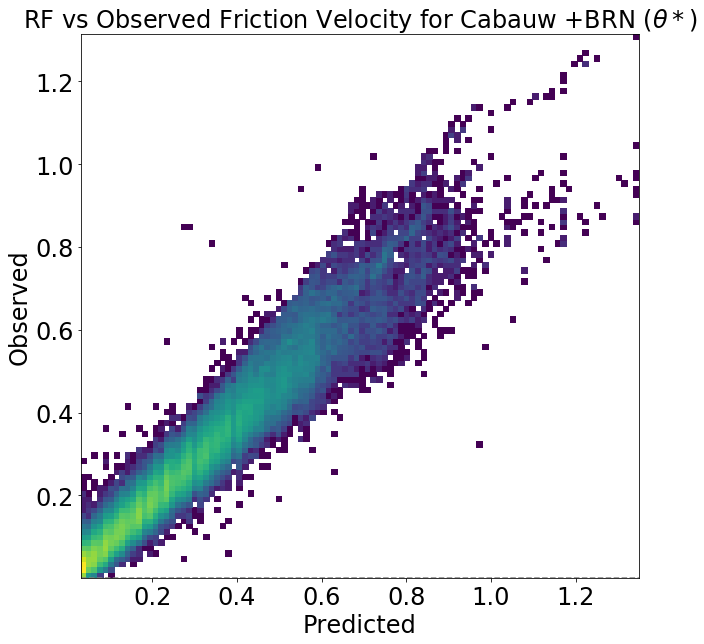

In [455]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predFC_Pos
y = test_labelsFC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Friction Velocity for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.9465163296810595


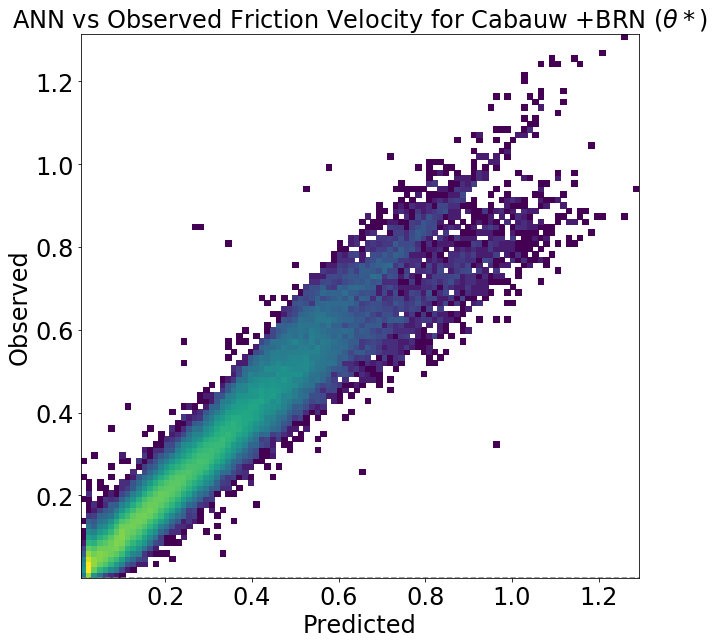

In [456]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredFC_Pos
y = test_labelsFC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Friction Velocity for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8894722676939197


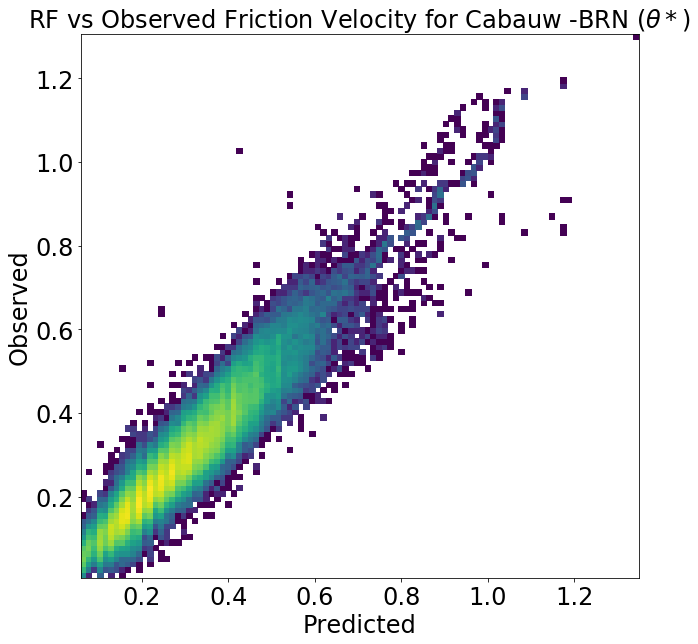

In [457]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predFC_Neg
y = test_labelsFC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Friction Velocity for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8951226939850279


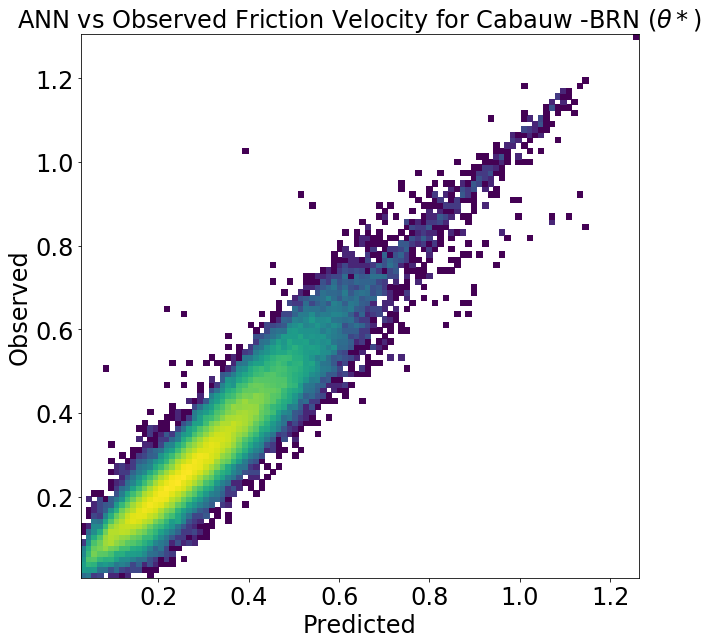

In [458]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredFC_Neg
y = test_labelsFC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Friction Velocity for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.49967421807161294


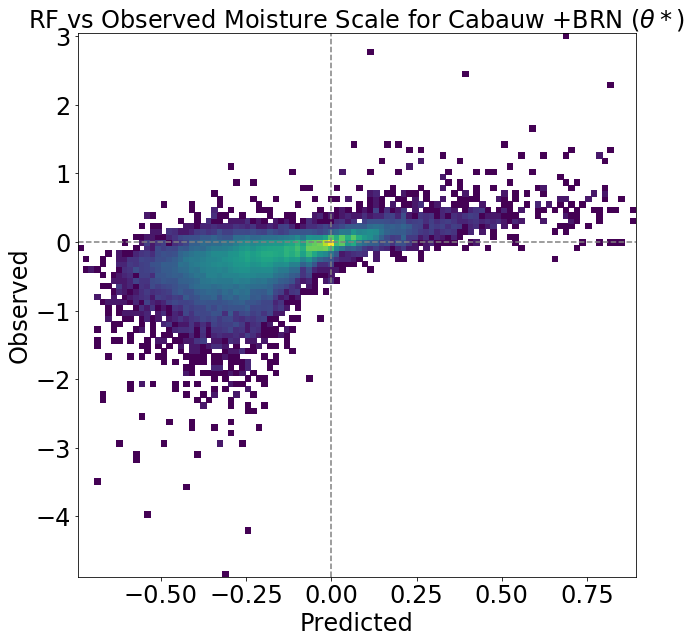

In [459]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predMC_Pos
y = test_labelsMC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Moisture Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.45923483796871245


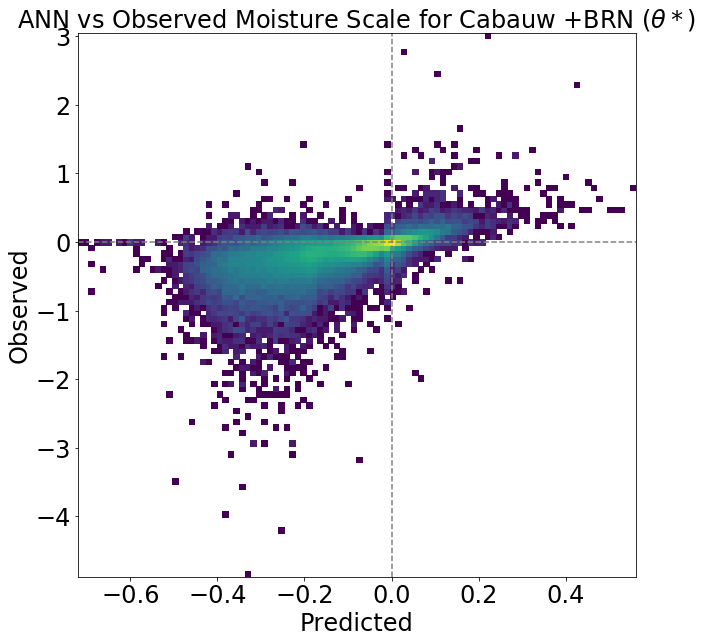

In [460]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredMC_Pos
y = test_labelsMC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Moisture Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.7652387601746068


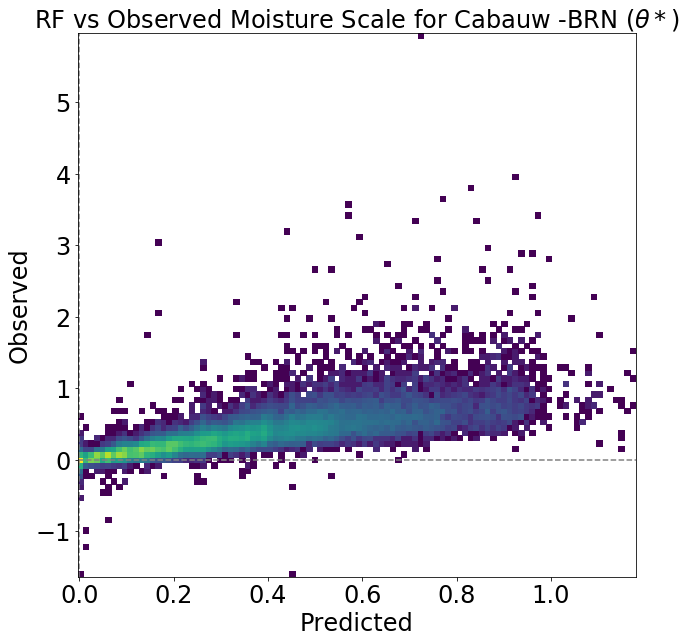

In [461]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predMC_Neg
y = test_labelsMC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Moisture Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.776398938904772


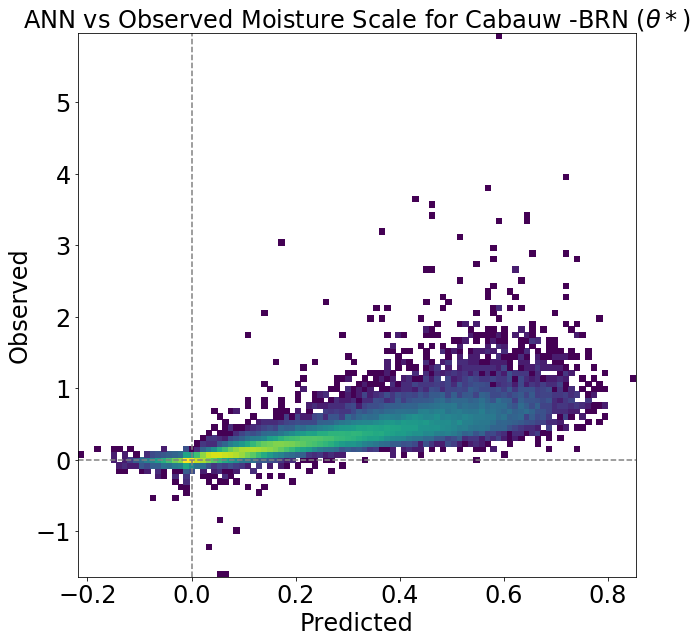

In [462]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredMC_Neg
y = test_labelsMC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Moisture Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.437443938684861


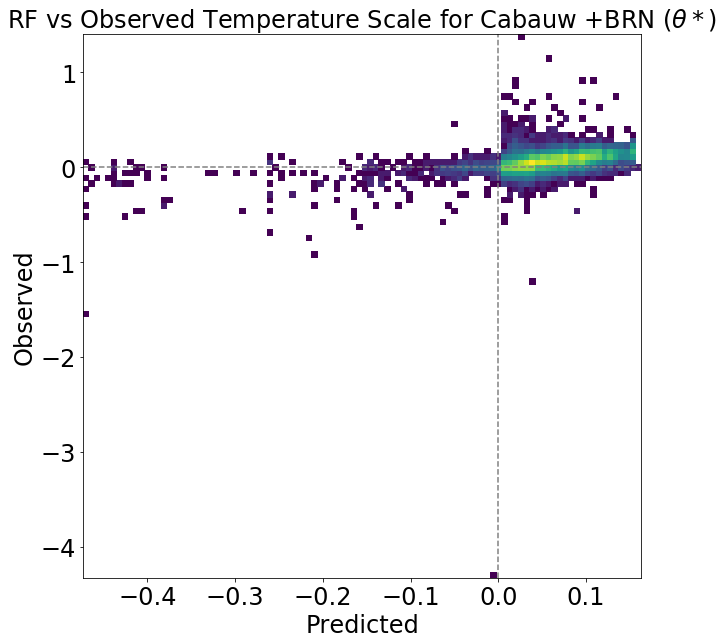

In [463]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predTC_Pos
y = test_labelsTC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Temperature Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.3968970786357464


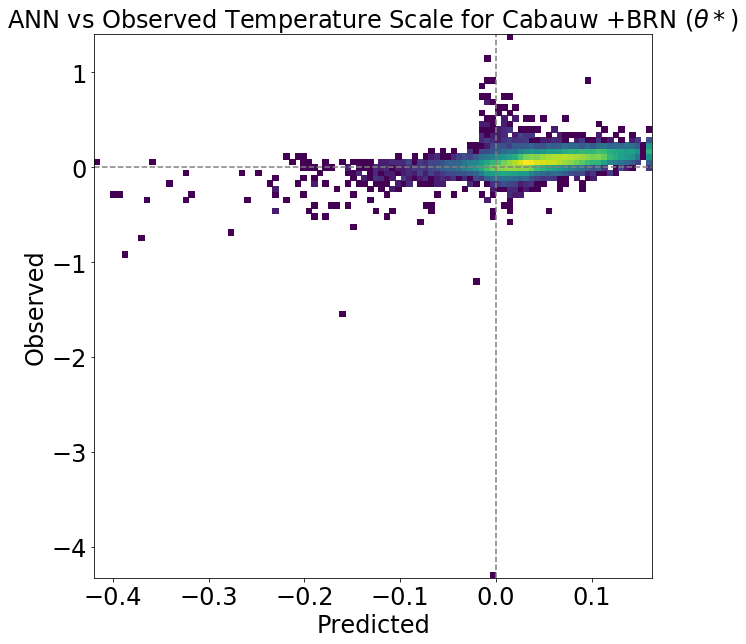

In [464]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredTC_Pos
y = test_labelsTC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Temperature Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7726103025583706


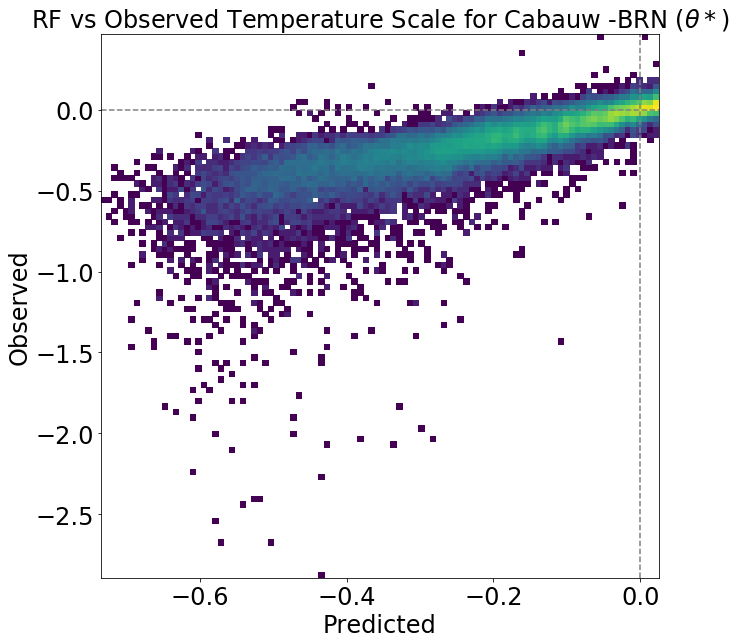

In [465]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predTC_Neg
y = test_labelsTC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Temperature Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7705589169363223


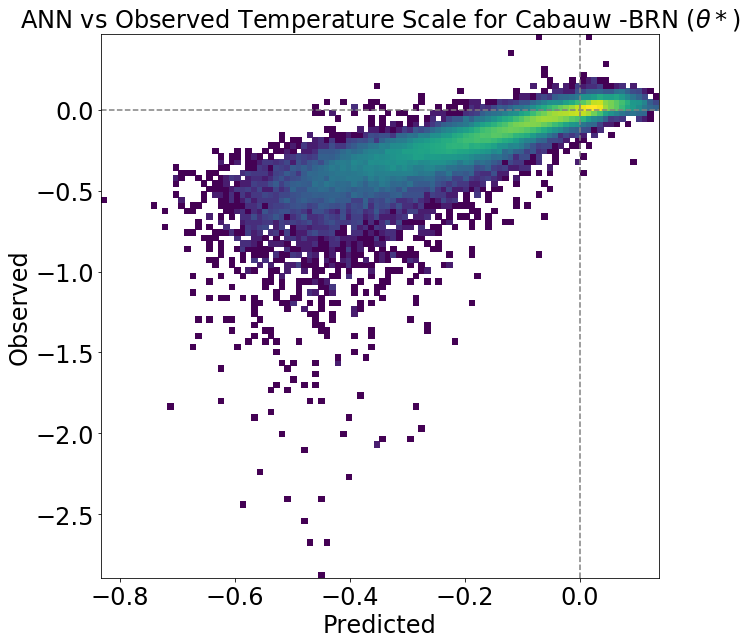

In [466]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredTC_Neg
y = test_labelsTC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Temperature Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_tscale.png')
plt.show()

In [53]:
# Predict whether the temperature scale is postive or negative, and then train separate Regime-Dependent-RF's (RD-RFs)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
t_scale_class = RandomForestClassifier(n_estimators = 10, n_jobs=4, max_features="sqrt",
                                       min_samples_split=2,min_samples_leaf=1, class_weight="balanced")
t_scale_class.fit(train_featuresT.iloc[:,0:19], np.where(train_labelsT >= 0, 1, -1))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [74]:
# Compute the confusion matrix
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
t_scale_sign_preds = t_scale_class.predict(test_featuresT.iloc[:,0:19])
test_sign_labels = np.where(test_labelsT >= 0, 1, -1)
print("Confusion matrix comparing test data labels and predictions")
confusion_matrix(test_sign_labels, t_scale_sign_preds)

Confusion matrix comparing test data labels and predictions


array([[5530,  635],
       [ 297, 5308]])

In [85]:
# Train random forest on negative temperature scales
t_scale_neg_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
neg_t_scale = train_labelsT < 0
train_data = train_featuresT.iloc[:,0:19]
input_cols = featuresF
t_scale_neg_reg.fit(train_data.loc[neg_t_scale, input_cols], 
                    np.log(-train_labelsT[neg_t_scale]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [86]:
# Train random forest on positive temperature scales
t_scale_pos_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
pos_t_scale = train_labelsT > 0
t_scale_pos_reg.fit(train_data.loc[pos_t_scale, input_cols], 
                    np.log(train_labelsT[pos_t_scale]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [87]:
# Make predictions on test data
test_data = test_featuresF.iloc[:,0:19]
t_scale_pos_preds = t_scale_pos_reg.predict(test_data[input_cols])
t_scale_neg_preds = t_scale_neg_reg.predict(test_data[input_cols])

In [88]:
# Combine both positive and negative predictions
t_scale_combined_preds = np.where(t_scale_sign_preds > 0, np.exp(t_scale_pos_preds), -np.exp(t_scale_neg_preds))

Text(0.5,0,'MAE: 0.0795 R$^2$: 0.659')

/home/dgagne/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


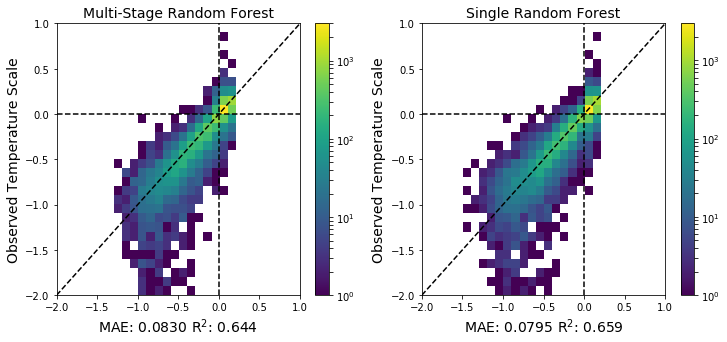

In [89]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(t_scale_combined_preds, test_labelsT, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()
plt.title("Multi-Stage Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
mae_rf_multi = mean_absolute_error(test_labelsT, t_scale_combined_preds)
r2_rf_multi = r2_score(test_labelsT, t_scale_combined_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_multi, r2_rf_multi), fontsize=14)
plt.subplot(1, 2, 2)
rf_t_scale_preds = predictionsT
plt.hist2d(rf_t_scale_preds, test_labelsT, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')

plt.title("Single Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
plt.colorbar()

mae_rf_single = mean_absolute_error(test_labelsT, rf_t_scale_preds)
r2_rf_single = r2_score(test_labelsT, rf_t_scale_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_single, r2_rf_single), fontsize=14)

Confusion matrix comparing test data labels and predictions
[[1827 2113]
 [ 559 7271]]


Text(0.5,0,'MAE: 0.0237 R$^2$: 0.426')

/home/dgagne/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


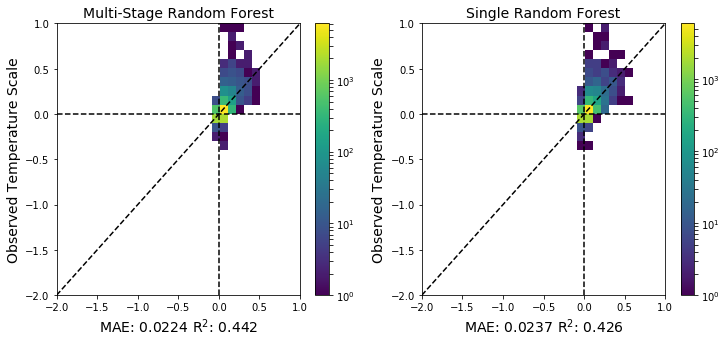

In [98]:
# Predict whether the temperature scale is postive or negative, and then train separate Regime-Dependent-RF's (RD-RFs)
m_scale_class = RandomForestClassifier(n_estimators = 50, n_jobs=4, max_features="sqrt",
                                       min_samples_split=2,min_samples_leaf=1, class_weight="balanced")
m_scale_class.fit(train_featuresM.iloc[:,0:19], np.where(train_labelsM >= 0, 1, -1))

# Compute the confusion matrix
m_scale_sign_preds = m_scale_class.predict(test_featuresM.iloc[:,0:19])
test_sign_labels = np.where(test_labelsM >= 0, 1, -1)
print("Confusion matrix comparing test data labels and predictions")
print(confusion_matrix(test_sign_labels, m_scale_sign_preds))

# Train random forest on negative temperature scales
m_scale_neg_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
neg_m_scale = train_labelsM < 0
train_data = train_featuresM.iloc[:,0:19]
input_cols = featuresF
m_scale_neg_reg.fit(train_data.loc[neg_m_scale, input_cols], 
                    np.log(-train_labelsM[neg_m_scale]))

# Train random forest on positive temperature scales
m_scale_pos_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
pos_m_scale = train_labelsM > 0
m_scale_pos_reg.fit(train_data.loc[pos_m_scale, input_cols], 
                    np.log(train_labelsM[pos_m_scale]))

# Make predictions on test data
test_data = test_featuresM.iloc[:,0:19]
m_scale_pos_preds = m_scale_pos_reg.predict(test_data[input_cols])
m_scale_neg_preds = m_scale_neg_reg.predict(test_data[input_cols])
# Combine both positive and negative predictions
m_scale_combined_preds = np.where(m_scale_sign_preds > 0, np.exp(m_scale_pos_preds), -np.exp(m_scale_neg_preds))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(m_scale_combined_preds, test_labelsM, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()
plt.title("Multi-Stage Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
mae_rf_multi = mean_absolute_error(test_labelsM, m_scale_combined_preds)
r2_rf_multi = r2_score(test_labelsM, m_scale_combined_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_multi, r2_rf_multi), fontsize=14)
plt.subplot(1, 2, 2)
rf_m_scale_preds = predictionsM
plt.hist2d(rf_m_scale_preds, test_labelsM, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')

plt.title("Single Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
plt.colorbar()

mae_rf_single = mean_absolute_error(test_labelsM, rf_m_scale_preds)
r2_rf_single = r2_score(test_labelsM, rf_m_scale_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_single, r2_rf_single), fontsize=14)